#### code to plot the radiosonde profiles compared to the arthus data
#### author Claudia Acquistapace
#### goal: plot radiosonde selected profiles, regrid arthus data on the radiosonde grid and compare the data
#### date: 21/12/2021


In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import glob
from myFunctions import lcl
from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import atmos
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker


# settings for plots and output directories
dict_plot_settings = {
    'plot_ticks'   :32,
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :32,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']
matplotlib.rc('xtick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots


In [2]:

# reading radiosondes
path_RS = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/radiosondes_atalante/case_1/'
file_list_RS = [path_RS+'EUREC4A_Atalante_Vaisala-RS_L2_v3.0.0.nc', path_RS+'EUREC4A_Atalante_Meteomodem-RS_L2_v3.0.0.nc']
path_out = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/'
# +
# read radiosonde from vaisala
data_RS_vaisala = xr.open_dataset(file_list_RS[0])

# read time of the launch for all radiosondes
time_launch = pd.to_datetime(data_RS_vaisala.launch_time.values)
sounding_id = data_RS_vaisala.sounding.values

# find indeces for the cold patch
ind = np.where((time_launch > datetime(2020,2,2,0,0,0)) * (time_launch < datetime(2020,2,3,23,59,59)))[0]
start = sounding_id[ind[0]]
end = sounding_id[ind[-1]]

# selecting data_RS
data_vaisala_sel = data_RS_vaisala.sel(sounding=slice(start, end))


# +
# read radiosonde from meteogram
data_RS_meteo = xr.open_dataset(file_list_RS[1])

# read time of the launch for all radiosondes
time_launch = pd.to_datetime(data_RS_meteo.launch_time.values)
sounding_id = data_RS_meteo.sounding.values

# find indeces for the cold patch
ind = np.where((time_launch > datetime(2020,2,2,0,0,0)) * (time_launch < datetime(2020,2,3,23,59,59)))[0]
start = sounding_id[ind[0]]
end = sounding_id[ind[-1]]

# selecting data_RS
data_meteo_sel = data_RS_meteo.sel(sounding=slice(start, end))


# +
# merging the two selected datasets
data_patch = xr.merge([data_vaisala_sel, data_meteo_sel])


def f_preprocess_rsdata(data_patch):
    
    # re-ordering files in temporal order
    sounding_id = pd.to_datetime(data_patch.launch_time.values)

    # re-ordering and saving order of indeces in ind_sorted
    soundings_strings_sorted = np.sort(sounding_id)
    ind_sorted = np.argsort(sounding_id)

    # building legend strings
    n_soundings = len(soundings_strings_sorted)
    legend_string = []
    for ind_file in range(n_soundings):
        legend_string.append(str(soundings_strings_sorted[ind_file])[8:10]+' - '+str(soundings_strings_sorted[ind_file])[11:13]+':'+str(soundings_strings_sorted[ind_file])[14:16]+' UTC')


    # assigning launch_time as main coordinate instead of sounding string
    data_swap = data_patch.swap_dims({"sounding": "launch_time"})

    # sorting by launch time the radiosonde profiles.
    data_swap = data_swap.reindex(launch_time=sorted(data_swap.launch_time.values))#("launch_time", ascending=True)

    return(data_swap)


vaisala_rs = f_preprocess_rsdata(data_vaisala_sel)
meteomodem_rs = f_preprocess_rsdata(data_meteo_sel)



/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


In [3]:
# reading arthus data 

# variable list
var_list =['T','WVMR','VW','LHF','SHF']

T_dict = {
     'var_name'  : 'T',
     'var_string': 'Temperature',
     'var_units' : ' $^{\circ}$K',
     'var_min'   : 290.,
     'var_max'   : 310.,
     'thr_min'   : 280.,
     'thr_max'   : 330.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Air temperature: 28/01-04/02'}

WVMR_dict = {
     'var_name'  : 'MR',
     'var_string': 'Water vapor mixing ratio',
     'var_units' : ' g kg$^{-1}$',
     'var_min'   : 0.,
     'var_max'   : 30.,
     'thr_min'   : 0.,
     'thr_max'   : 30.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Water vapor mixing ratio: 28/01-04/02'}

VW_dict = {
     'var_name'  : 'VW',
     'var_string': 'Vertical velocity',
     'var_units' : ' ms$^{-1}$',
     'var_min'   : -2.,
     'var_max'   : 2.,
     'thr_min'   : -5.,
     'thr_max'   : 5.,
     'avg_time'  : '15',
     'cmap'      : 'seismic',
     'title'     : 'Vertical velocity: 28/01-04/02'}

LHF_dict = {
     'var_name'  : 'LHF',    
     'var_string': 'Latent heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -250.,
     'var_max'   : 250.,
     'thr_min'   : -250.,
     'thr_max'   : 250.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Latent heat flux: 28/01-04/02'}

SHF_dict = {
     'var_name'  : 'SHF',
     'var_string': 'Sensible heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -100.,
     'var_max'   : 100.,
     'thr_min'   : -100.,
     'thr_max'   : 100.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Sensible heat flux: 28/01-04/02'}


dict_list = [T_dict, WVMR_dict, VW_dict, LHF_dict, SHF_dict]
def f_read_data_and_merge(dict_var):
    print(dict_var['var_name'])
    arthus_files = np.sort(glob.glob( '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/'+dict_var['var_name']+'_*.nc'))
    data = xr.open_mfdataset(arthus_files)
    var = data.product_no_noise
    return(var)

T_arthus = f_read_data_and_merge(T_dict)
VWMR_arthus = f_read_data_and_merge(WVMR_dict)
VW_arthus = f_read_data_and_merge(VW_dict)
LHF_arthus = f_read_data_and_merge(LHF_dict)
SHF_arthus = f_read_data_and_merge(SHF_dict)

print(T_arthus)

T
MR
VW
LHF
SHF
<xarray.DataArray 'product_no_noise' (time: 16617, height: 57)>
dask.array<concatenate, shape=(16617, 57), dtype=float64, chunksize=(8438, 57), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-02-02T00:00:08 ... 2020-02-03T23:59:40
  * height   (height) float32 225.0 275.0 325.0 375.0 ... 2925.0 2975.0 3025.0
Attributes:
    long_name:  Temperature with noise removed
    units:       $^{\circ}$K


In [5]:
# selecting arthus times closest to radiosonde launch times
T_match_arthus_va = T_arthus.sel(time=vaisala_rs.launch_time, method='nearest')
WVMR_match_arthus_va = VWMR_arthus.sel(time=vaisala_rs.launch_time, method='nearest')
VW_match_arthus_va = VW_arthus.sel(time=vaisala_rs.launch_time, method='nearest')

# interpolating arthus data on the same height grid of the radiosonde launches
T_arthus_vaisala = T_match_arthus_va.interp(height=vaisala_rs.alt.values, method='nearest')
WVMR_arthus_vaisala = WVMR_match_arthus_va.interp(height=vaisala_rs.alt.values, method='nearest')
VW_arthus_vaisala = VW_match_arthus_va.interp(height=vaisala_rs.alt.values, method='nearest')


In [6]:
# selecting arthus times closest to radiosonde launch times
T_match_arthus_mm = T_arthus.sel(time=meteomodem_rs.launch_time, method='nearest')
WVMR_match_arthus_mm = VWMR_arthus.sel(time=meteomodem_rs.launch_time, method='nearest')
VW_match_arthus_mm = VW_arthus.sel(time=meteomodem_rs.launch_time, method='nearest')

# interpolating arthus data on the same height grid of the radiosonde launches
T_arthus_mm = T_match_arthus_mm.interp(height=meteomodem_rs.alt.values, method='nearest')
WVMR_arthus_mm = WVMR_match_arthus_mm.interp(height=meteomodem_rs.alt.values, method='nearest')
VW_arthus_mm = VW_match_arthus_mm.interp(height=meteomodem_rs.alt.values, method='nearest')


02/02/2020, 00:44:19 02/02/2020, 00:44:17
02/02/2020, 02:11:00 02/02/2020, 02:10:59
02/02/2020, 04:40:49 02/02/2020, 04:40:52
02/02/2020, 06:00:07 02/02/2020, 06:00:07
02/02/2020, 08:41:12 02/02/2020, 08:41:09
02/02/2020, 10:13:51 02/02/2020, 10:13:56
02/02/2020, 12:44:30 02/02/2020, 12:44:30
02/02/2020, 14:14:09 02/02/2020, 14:14:13
02/02/2020, 16:45:18 02/02/2020, 16:45:18
02/02/2020, 18:13:03 02/02/2020, 18:13:00
02/02/2020, 22:46:37 02/02/2020, 22:46:35
02/03/2020, 00:03:06 02/03/2020, 00:03:08
02/03/2020, 02:41:40 02/03/2020, 02:41:39
02/03/2020, 04:18:43 02/03/2020, 04:18:39
02/03/2020, 07:47:38 02/03/2020, 07:47:42
02/03/2020, 09:19:06 02/03/2020, 09:19:07
02/03/2020, 10:40:11 02/03/2020, 10:40:14
02/03/2020, 12:06:10 02/03/2020, 12:06:15
02/03/2020, 14:45:15 02/03/2020, 14:45:19
02/03/2020, 16:10:09 02/03/2020, 16:10:11


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_7851/2491160580.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,2, figsize=(24,14), constrained_layout=True)


02/03/2020, 19:20:35 02/03/2020, 19:20:38
02/03/2020, 21:02:15 02/03/2020, 21:02:12
02/03/2020, 22:44:22 02/03/2020, 22:44:18
02/02/2020, 19:32:36 02/02/2020, 19:32:36
02/02/2020, 20:15:04 02/02/2020, 20:15:00
02/02/2020, 21:00:07 02/02/2020, 21:00:07
02/02/2020, 21:49:56 02/02/2020, 21:49:58
02/02/2020, 22:40:34 02/02/2020, 22:40:30
02/02/2020, 23:36:42 02/02/2020, 23:36:46
02/03/2020, 00:29:08 02/03/2020, 00:29:09
02/03/2020, 01:21:42 02/03/2020, 01:21:42
02/03/2020, 02:04:00 02/03/2020, 02:05:13
02/03/2020, 02:54:45 02/03/2020, 02:54:49
02/03/2020, 03:46:02 02/03/2020, 03:46:02
02/03/2020, 04:36:48 02/03/2020, 04:36:44
02/03/2020, 05:40:35 02/03/2020, 05:40:37
02/03/2020, 06:27:00 02/03/2020, 06:27:05
02/03/2020, 07:18:50 02/03/2020, 07:18:48
02/03/2020, 08:02:41 02/03/2020, 08:02:44
02/03/2020, 08:48:12 02/03/2020, 08:48:11
02/03/2020, 09:37:16 02/03/2020, 09:37:12
02/03/2020, 10:21:56 02/03/2020, 10:21:59
02/03/2020, 11:09:29 02/03/2020, 11:09:28
02/03/2020, 11:58:48 02/03/2020, 1

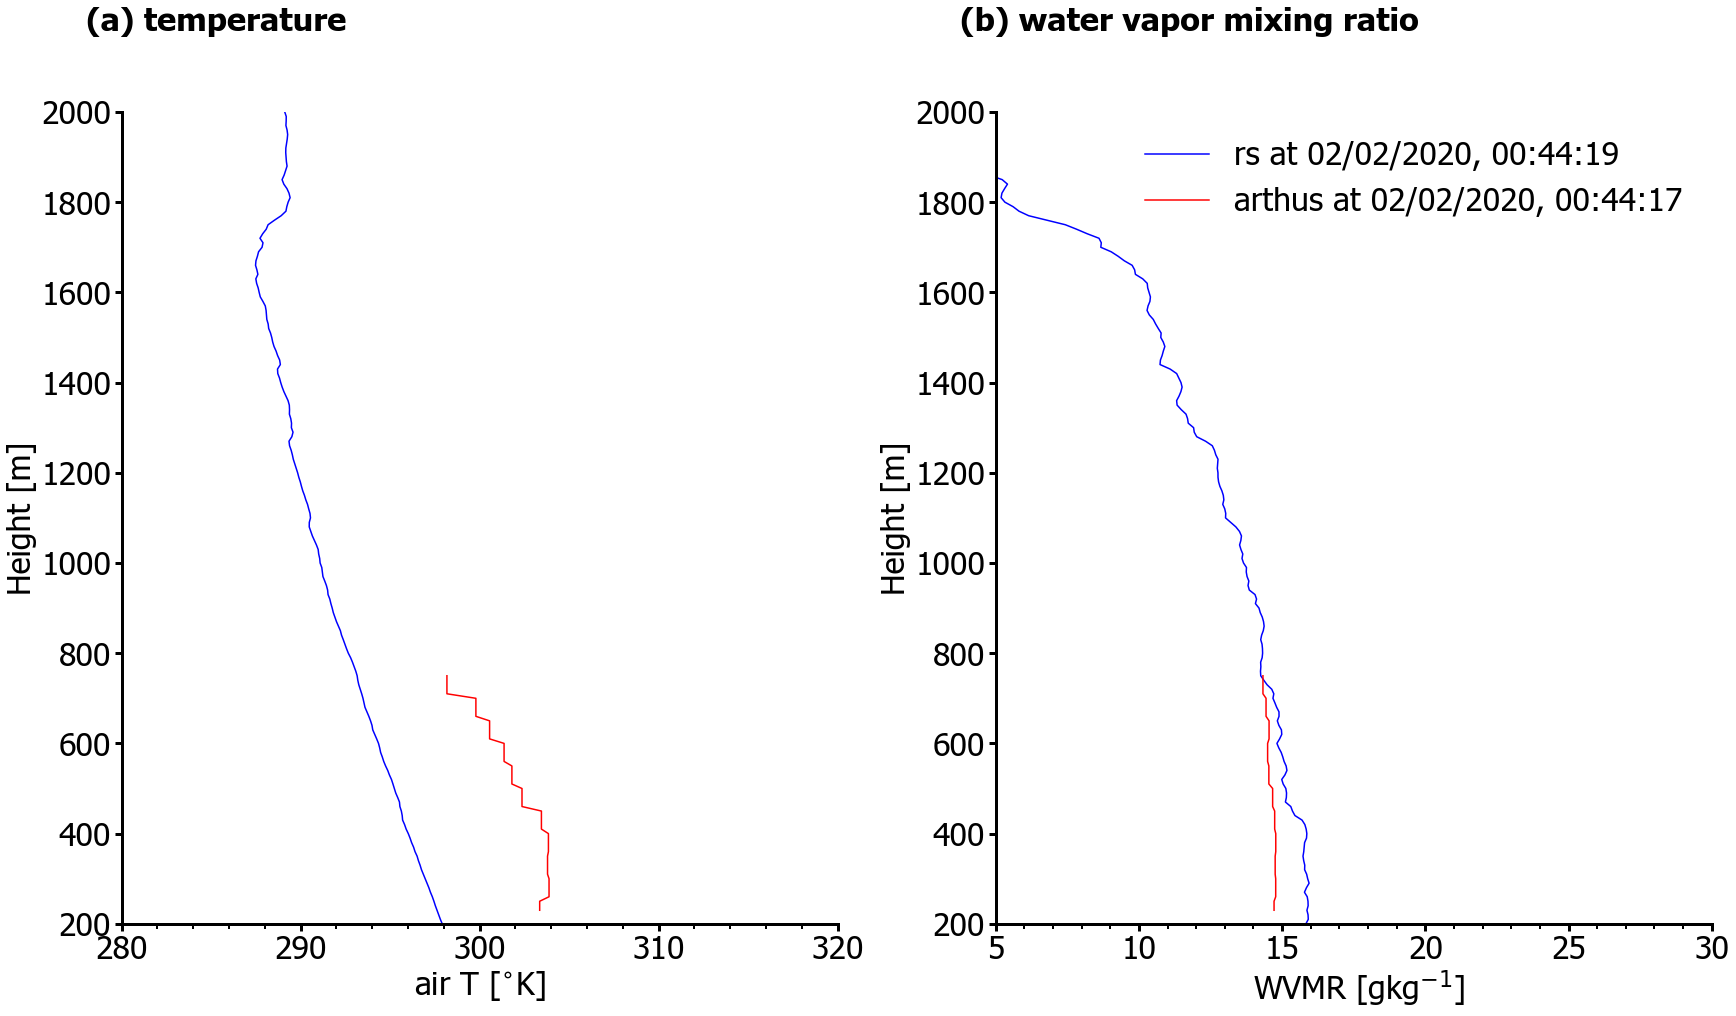

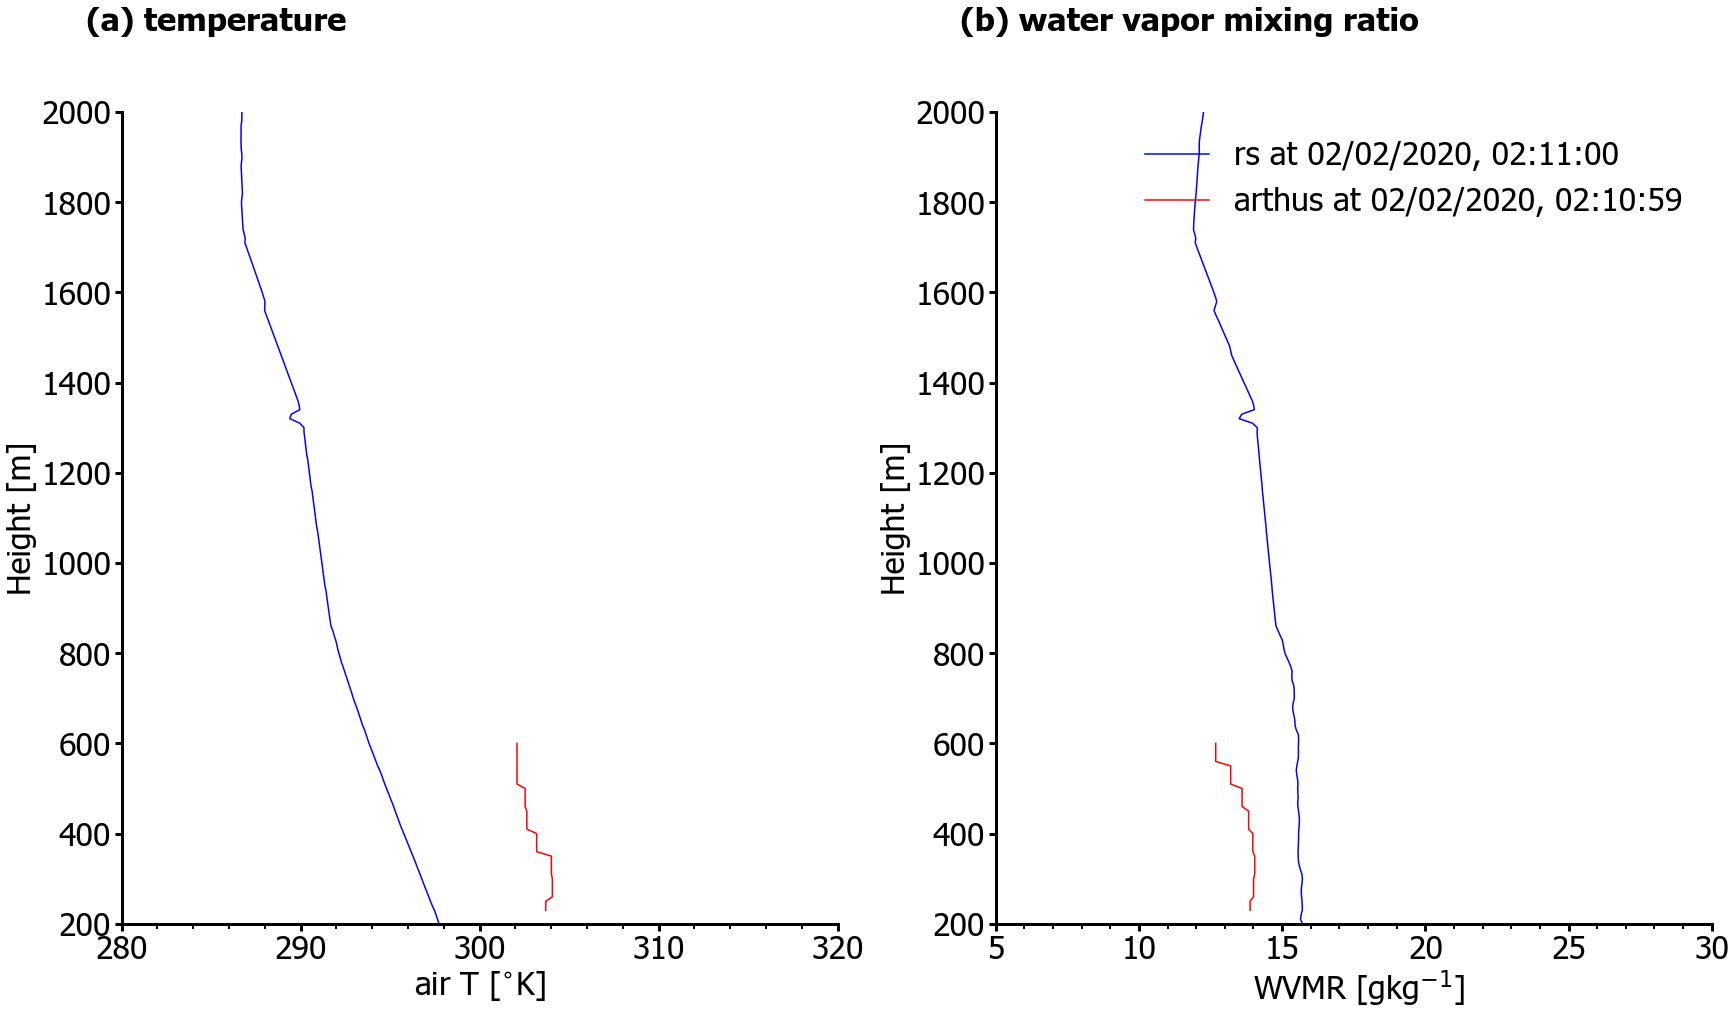

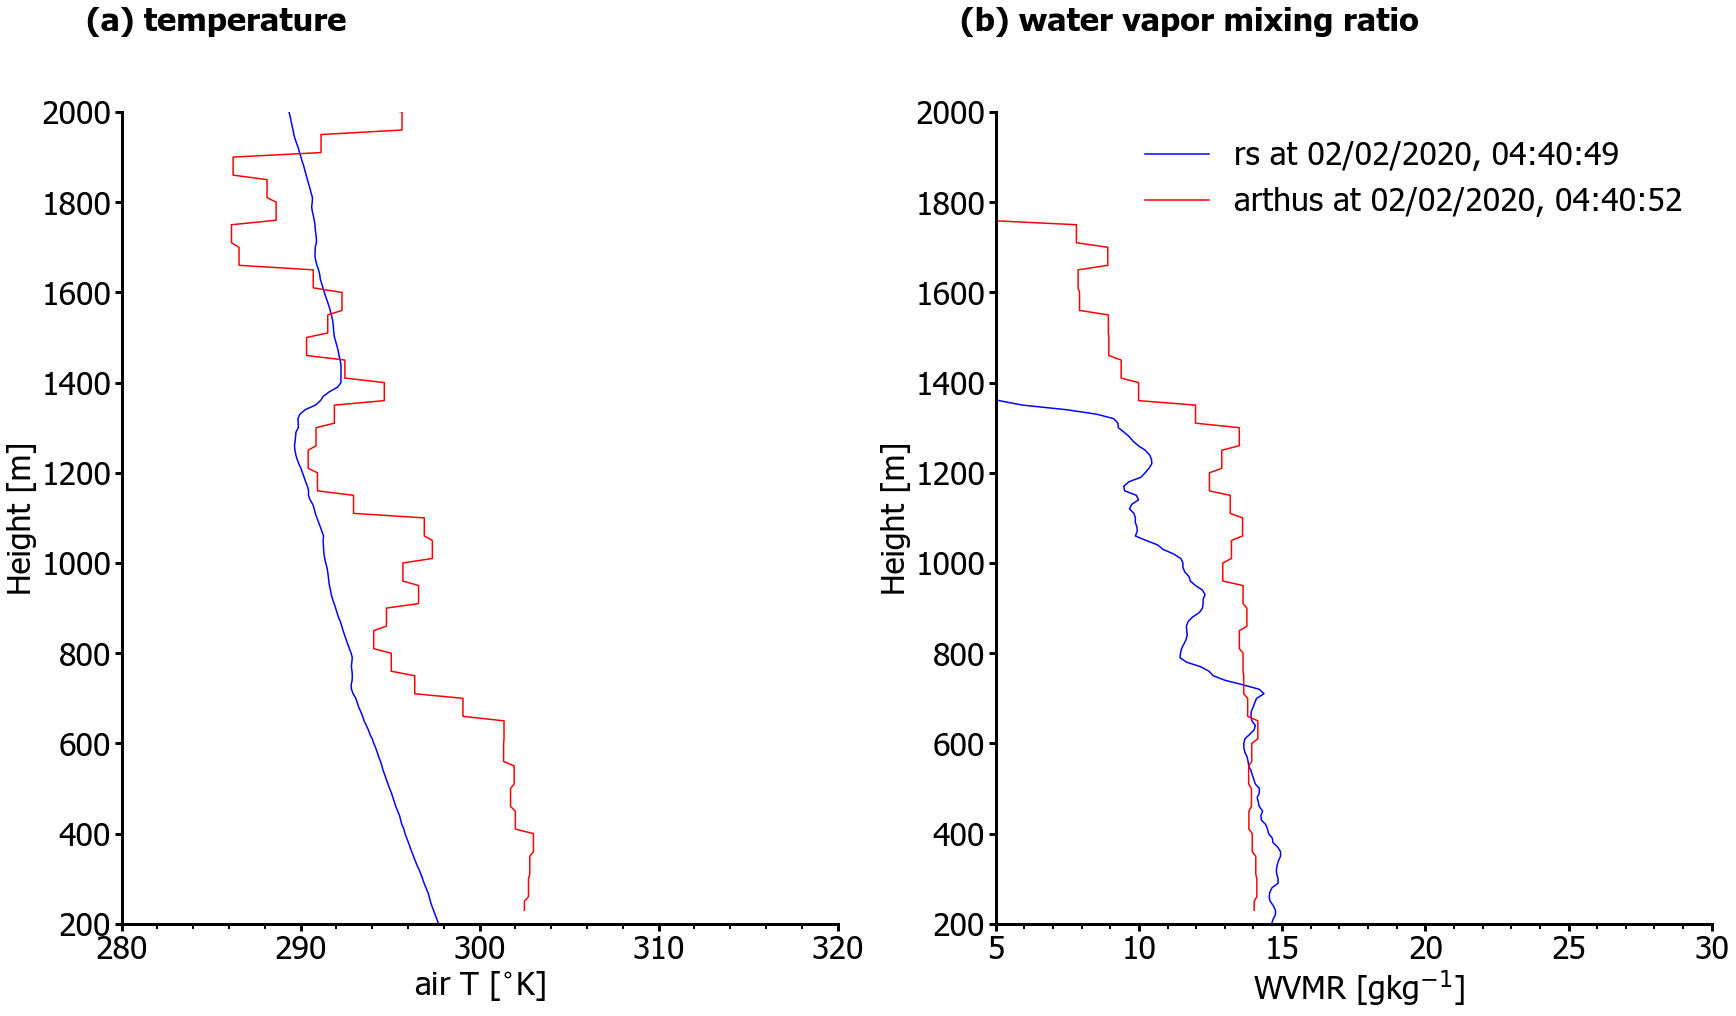

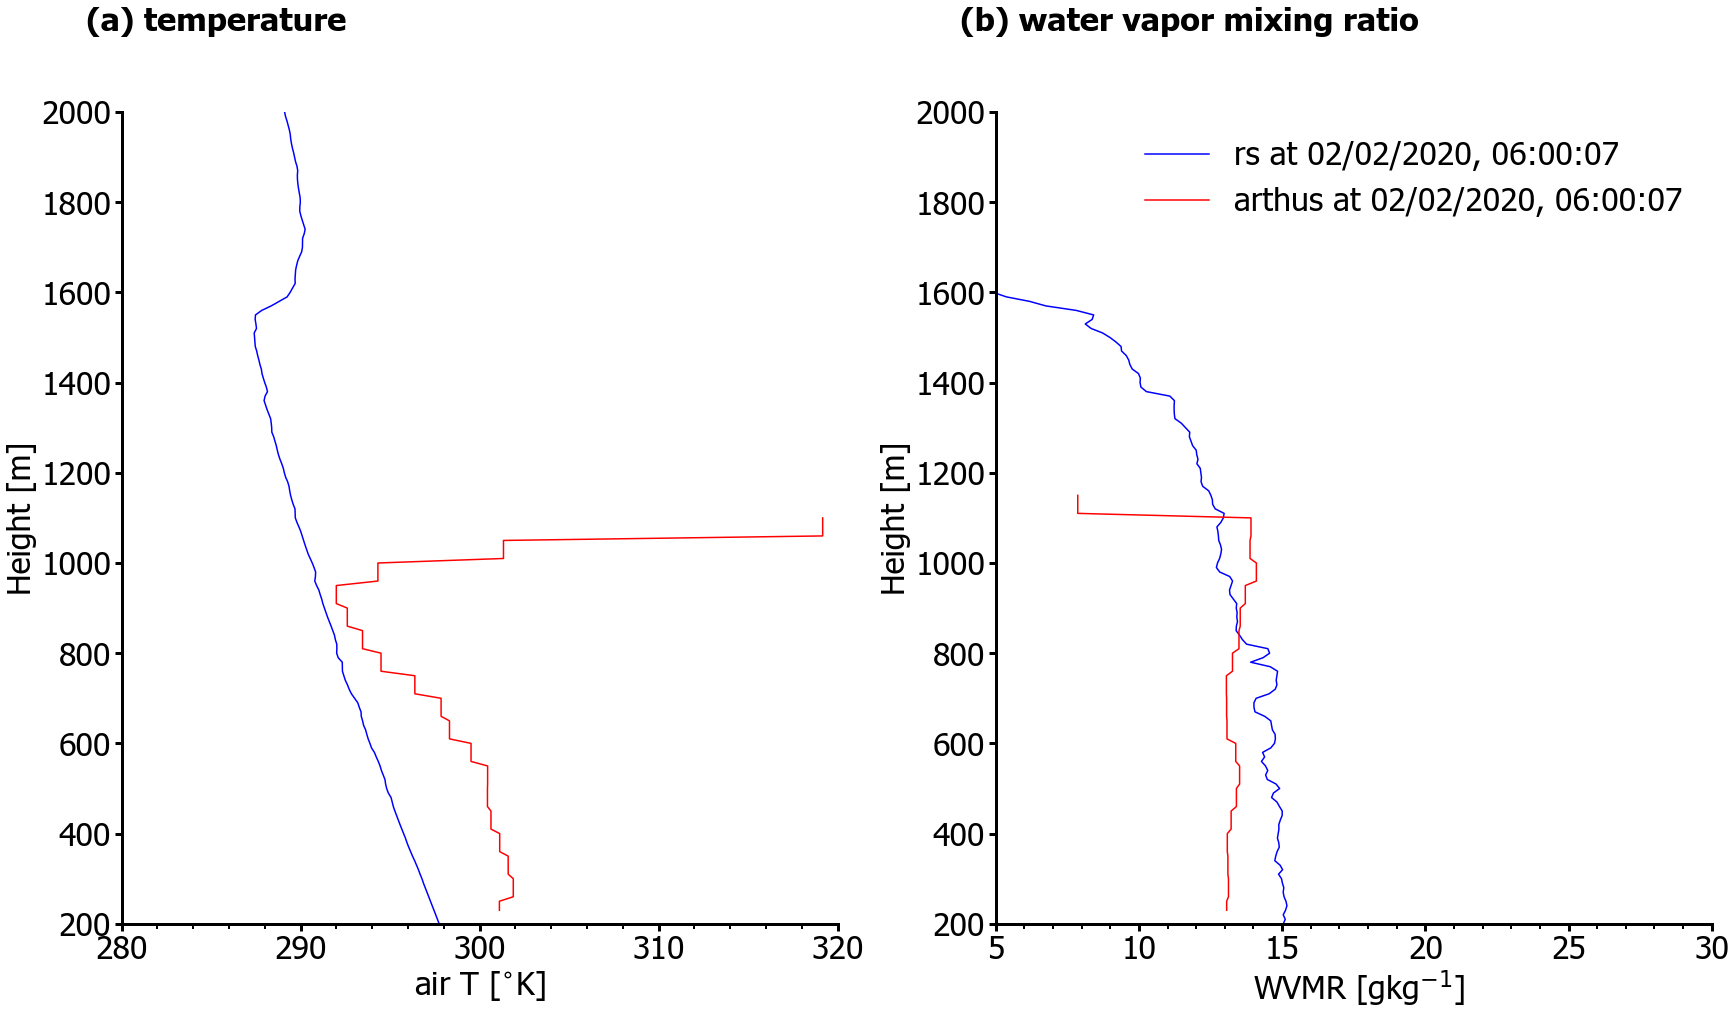

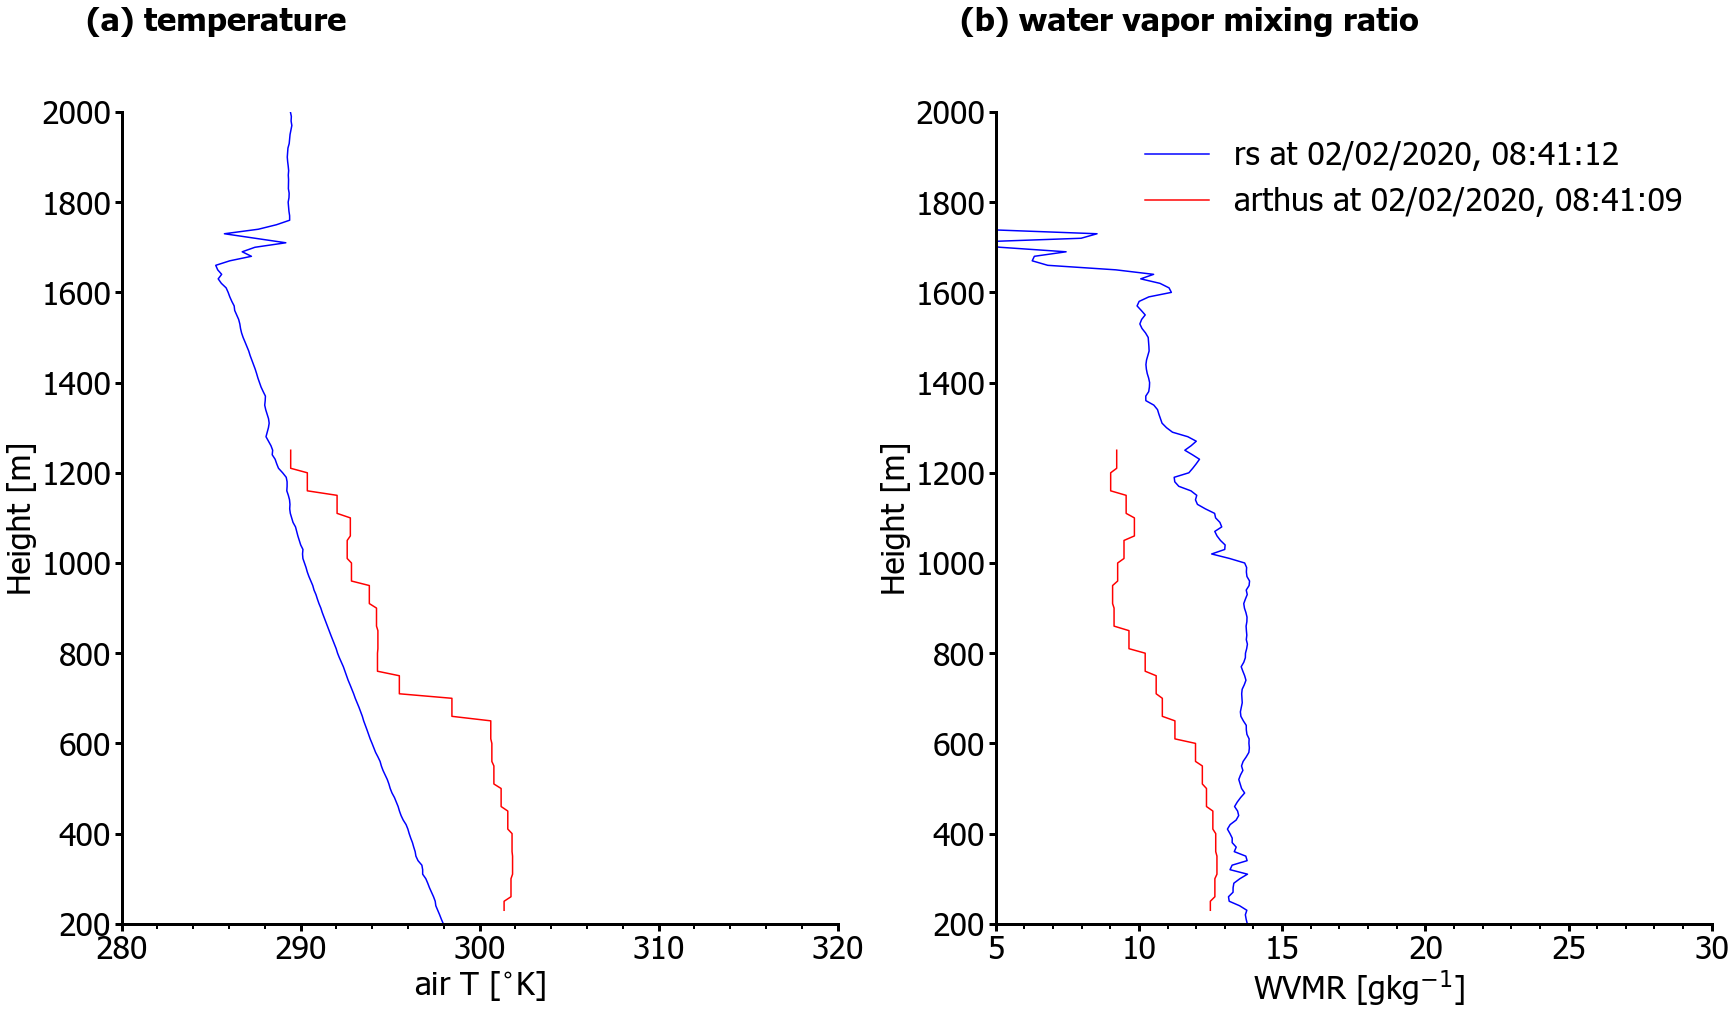

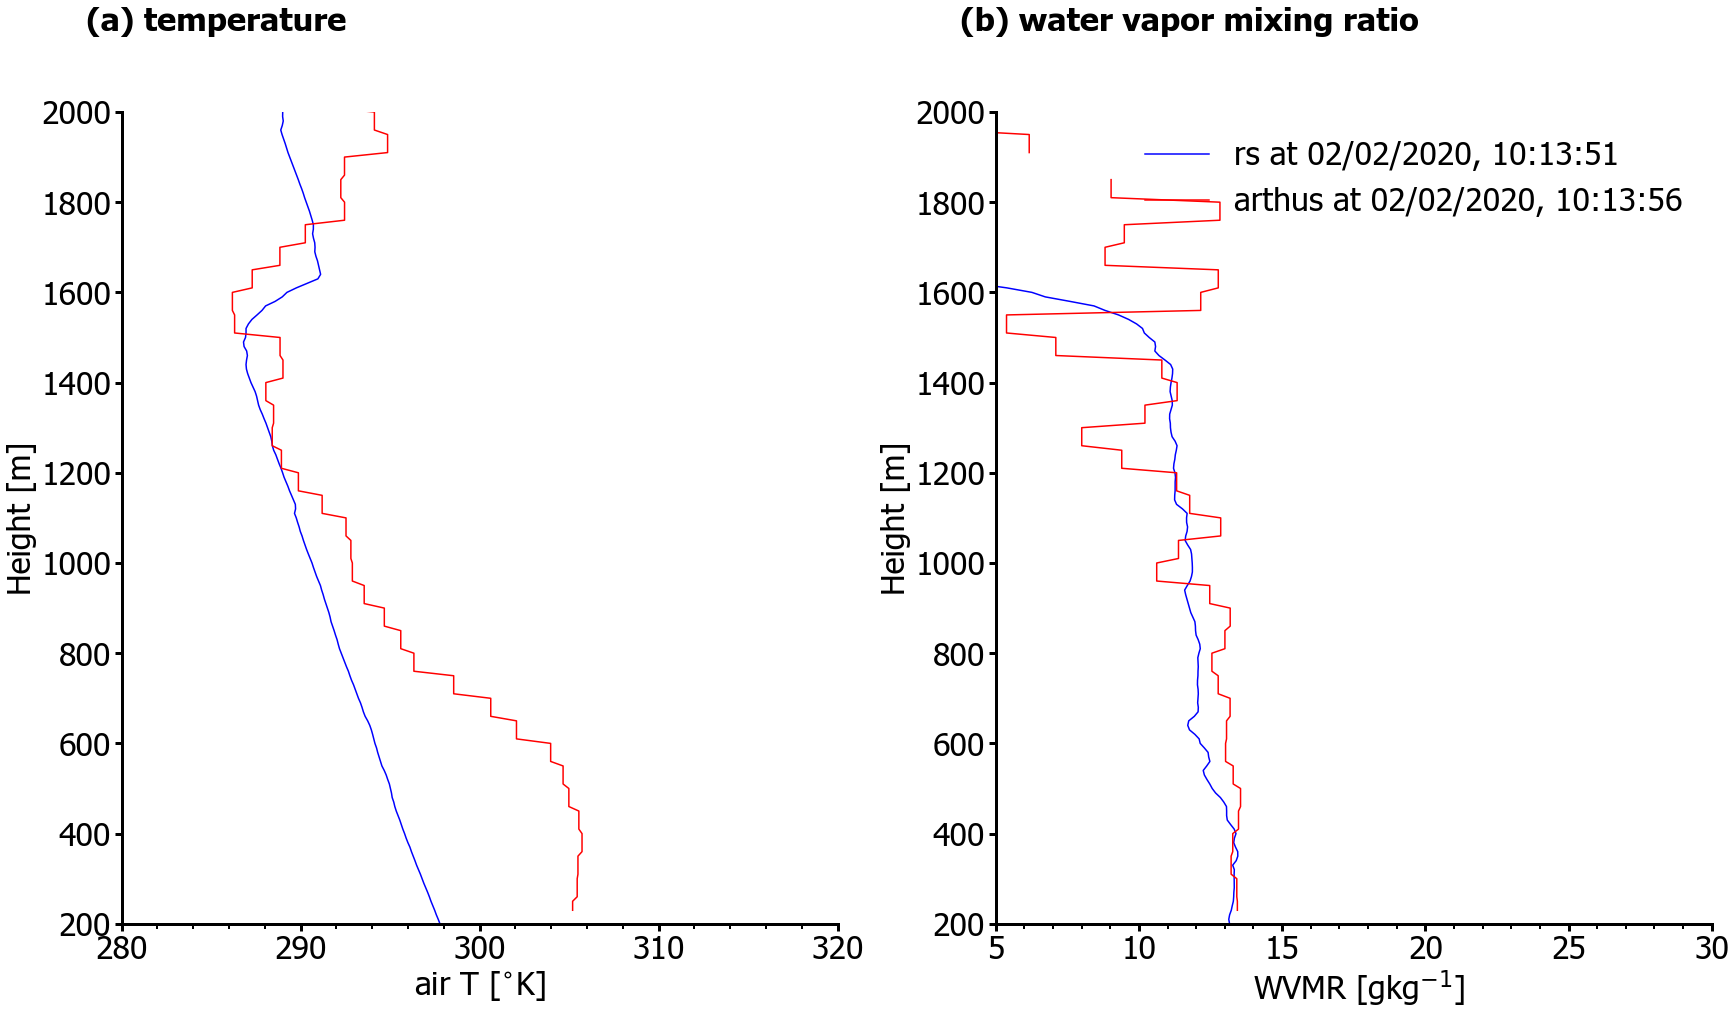

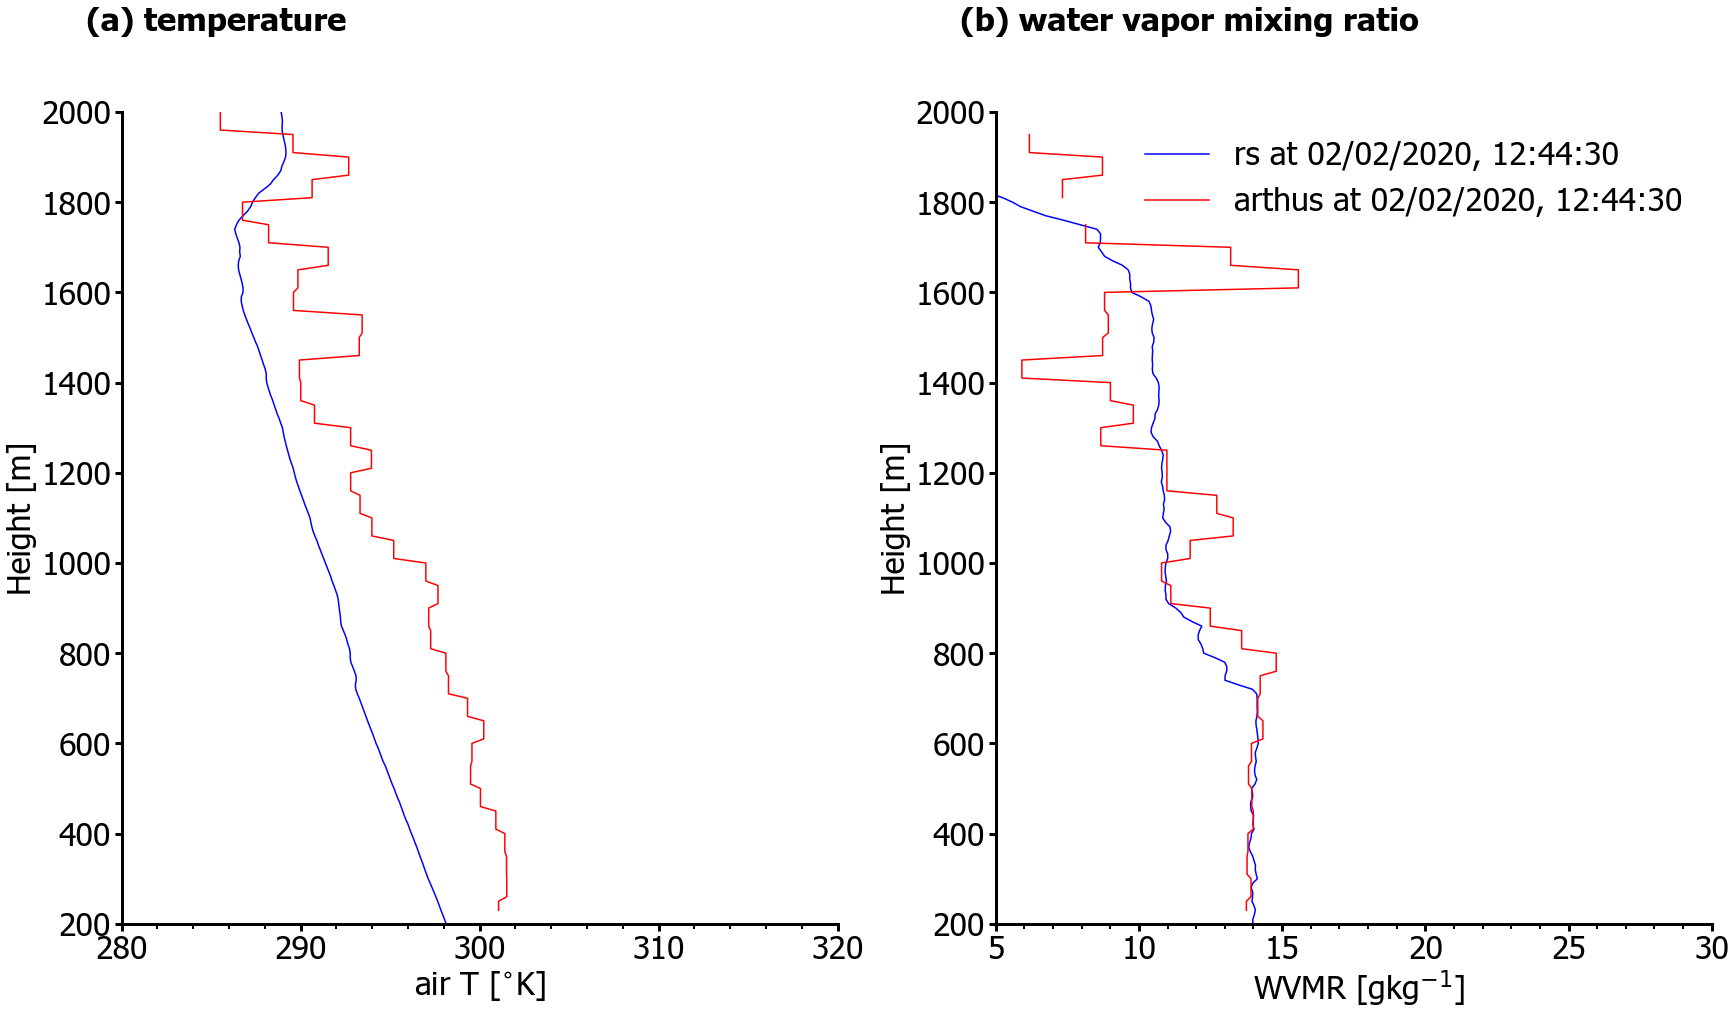

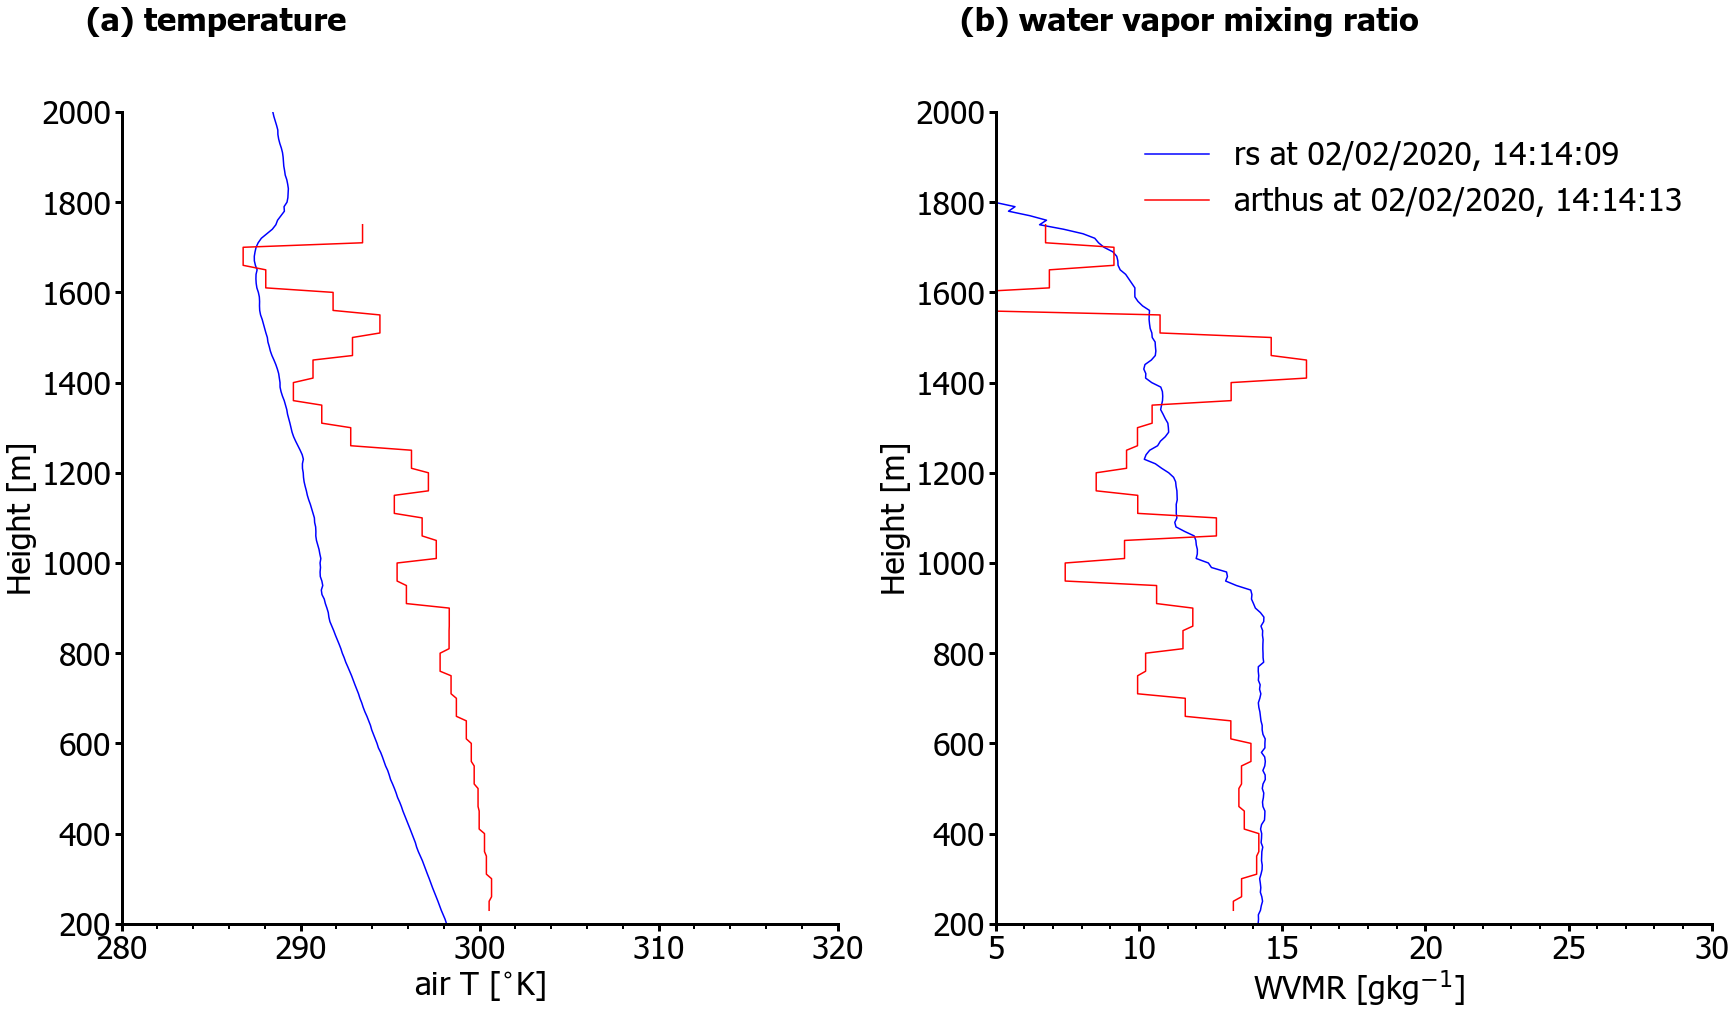

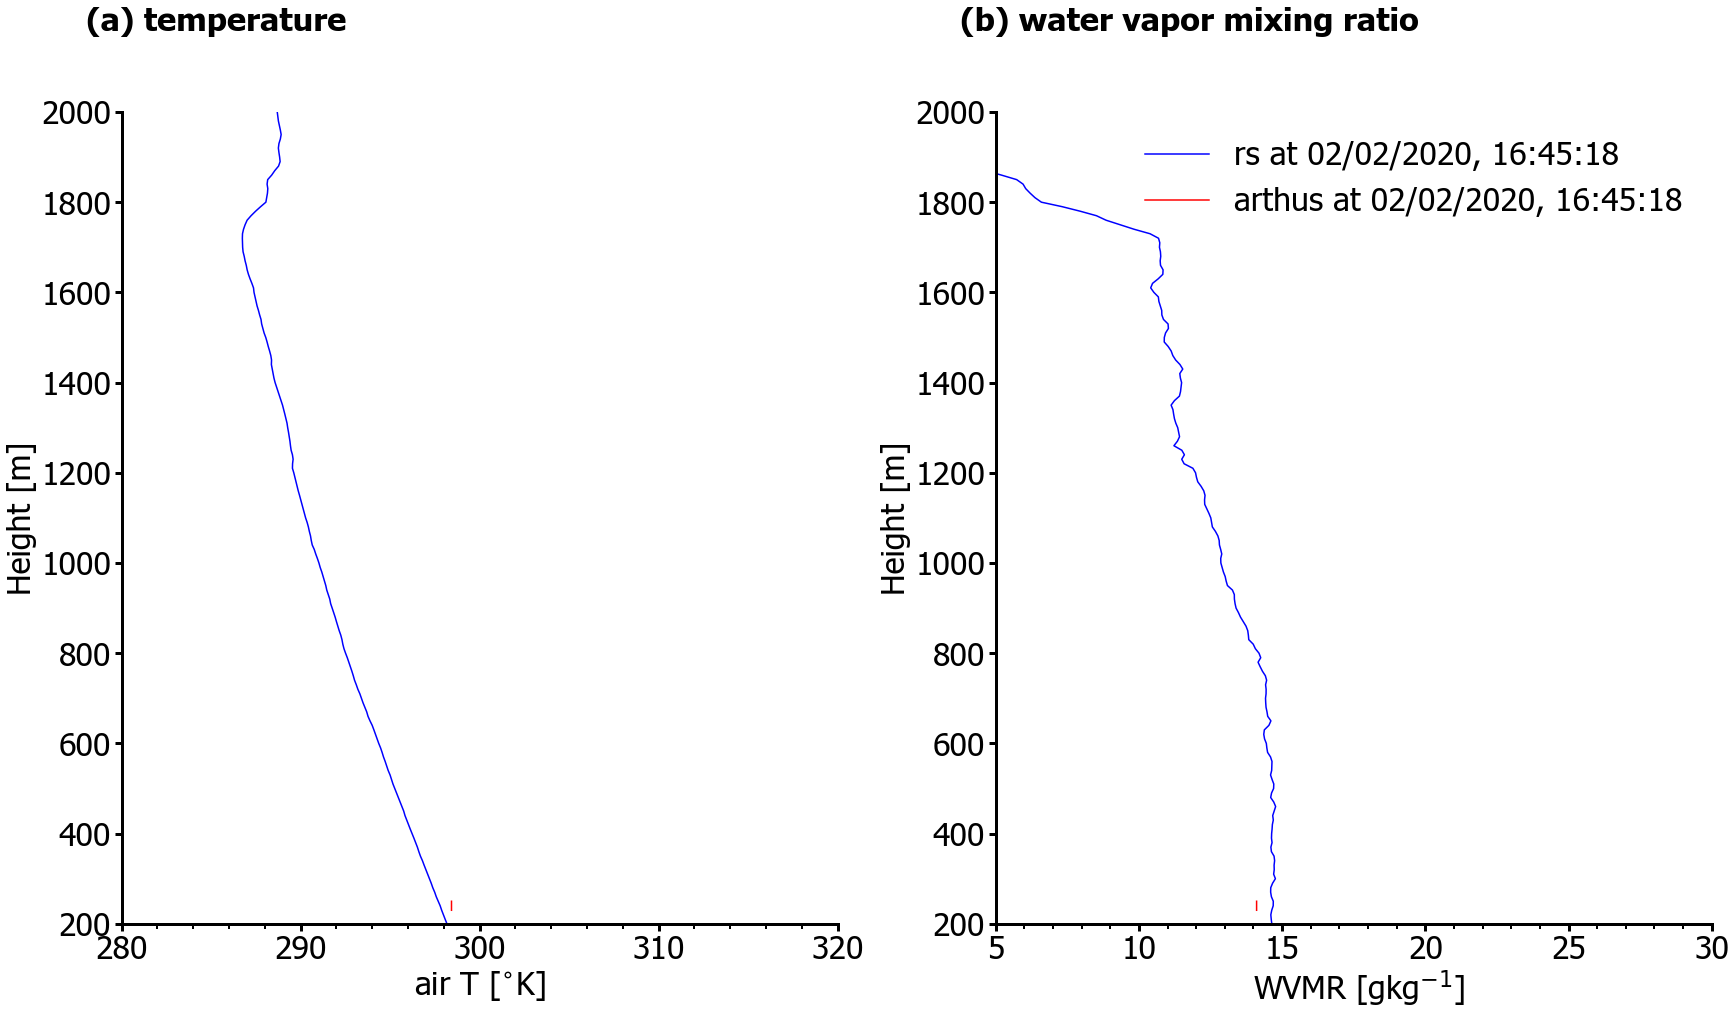

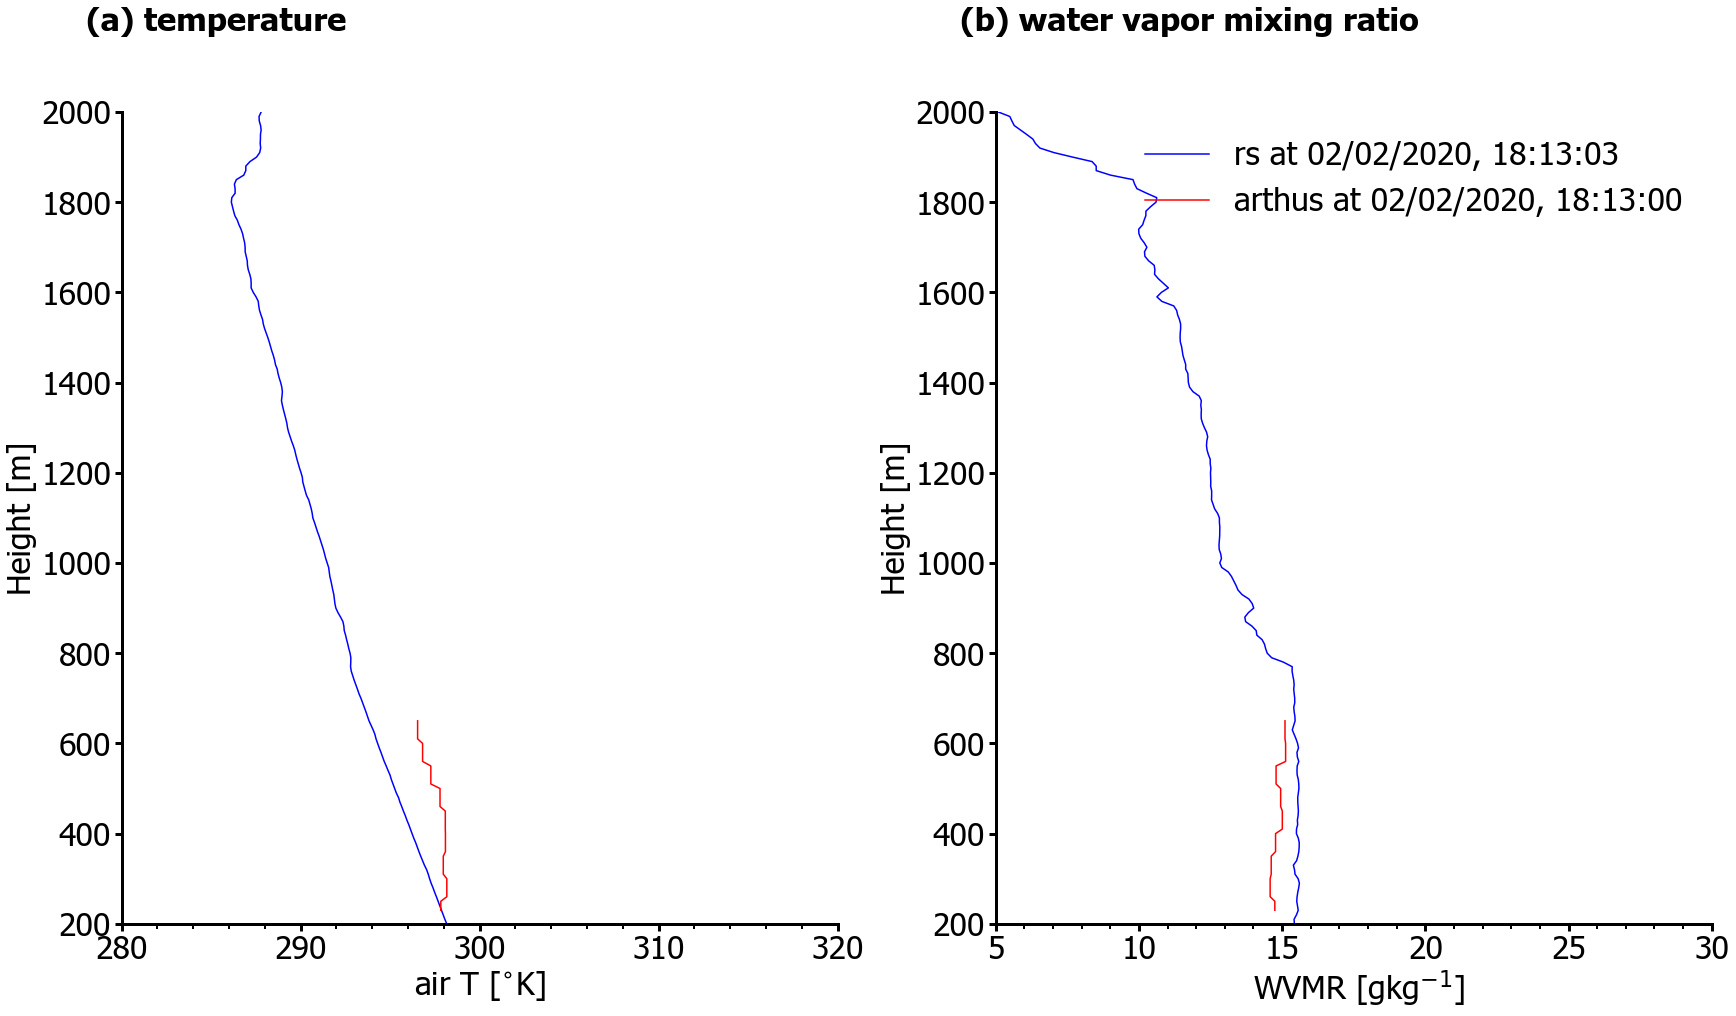

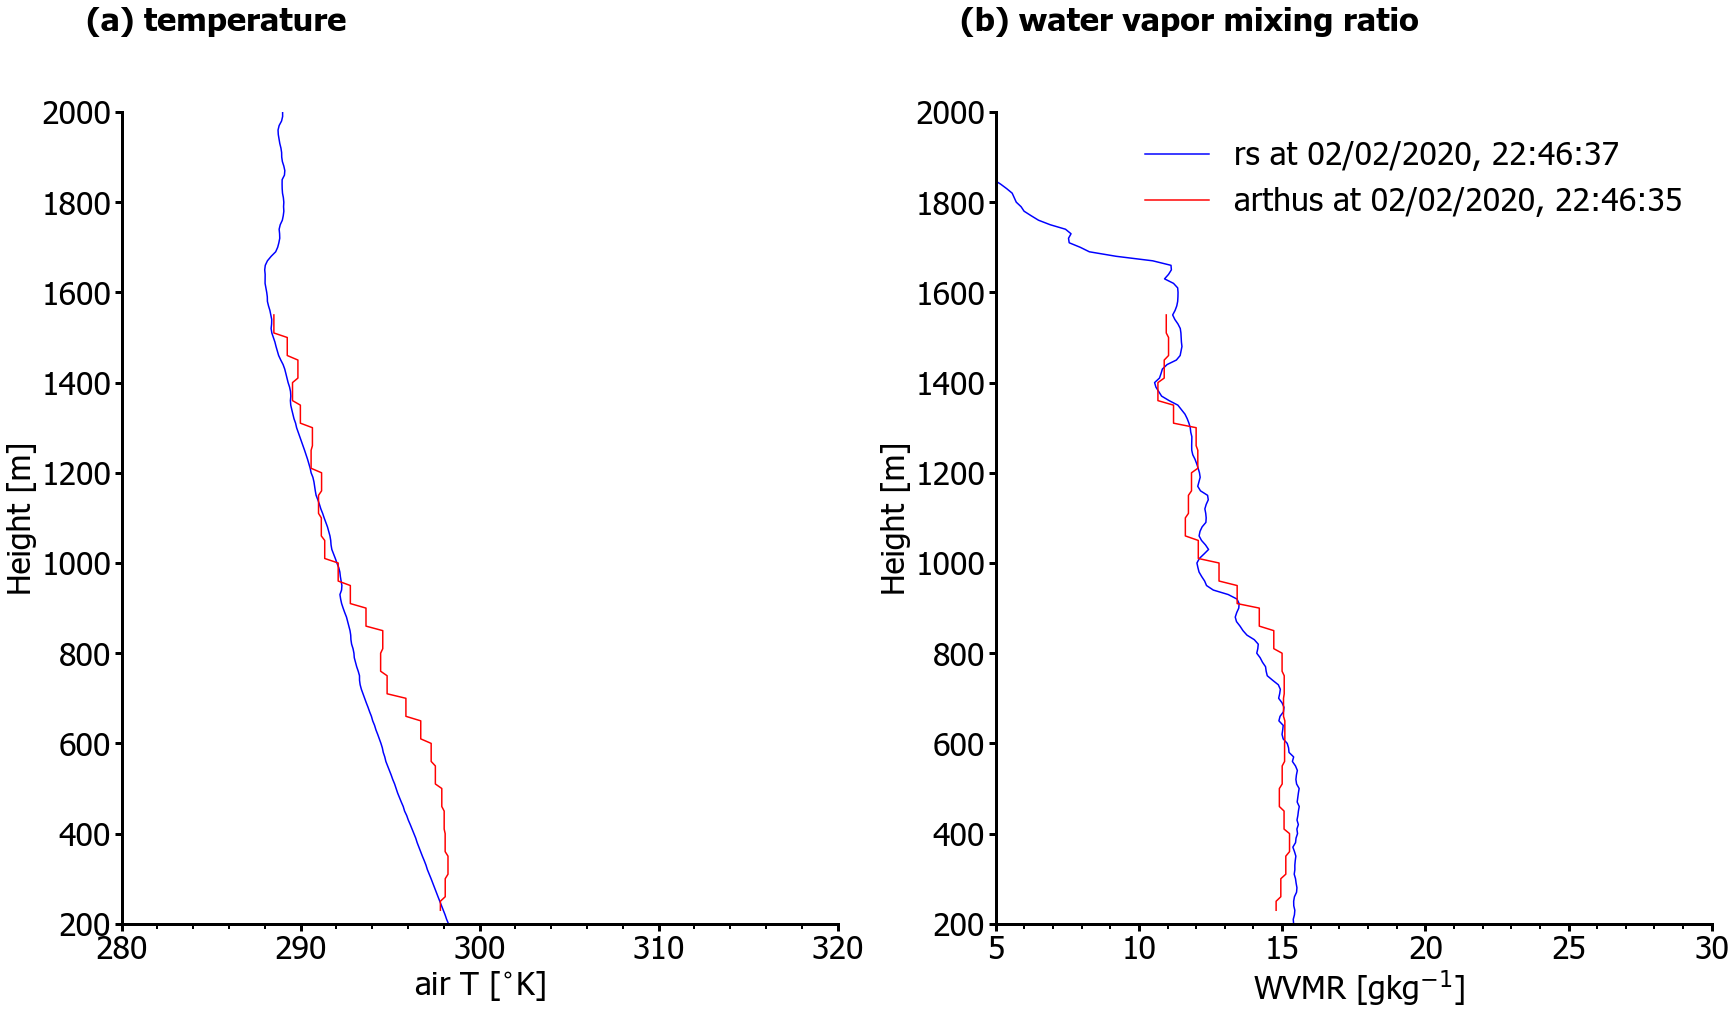

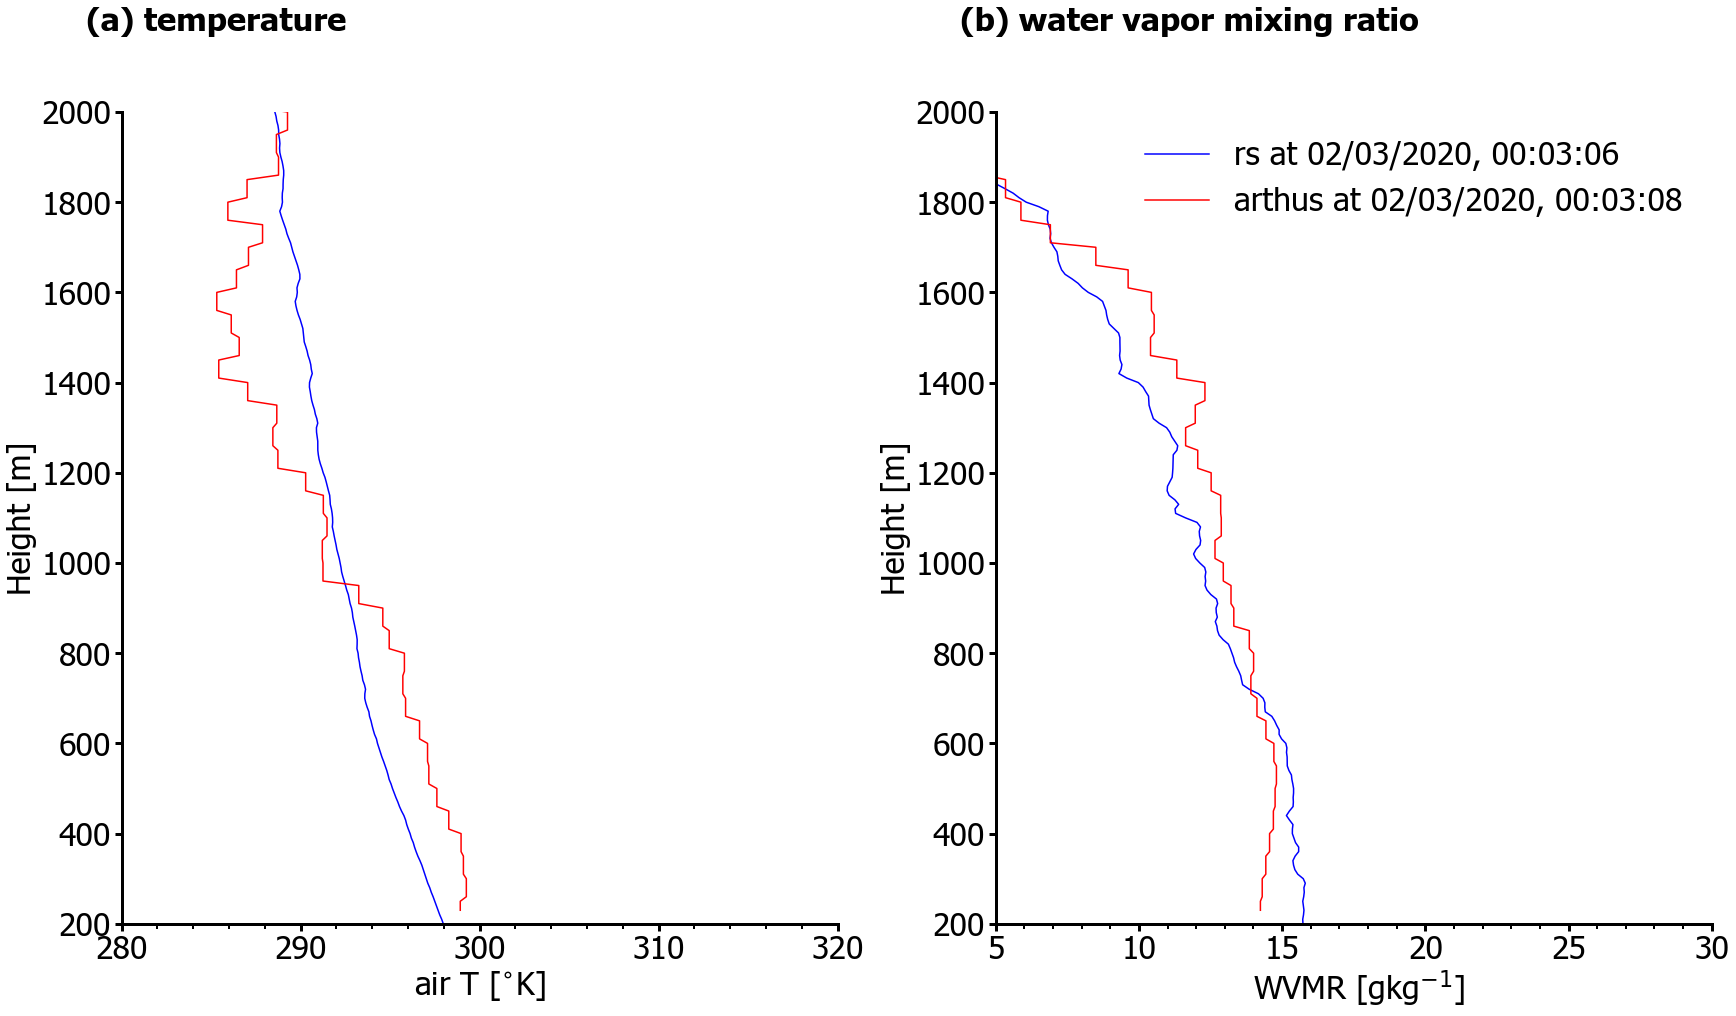

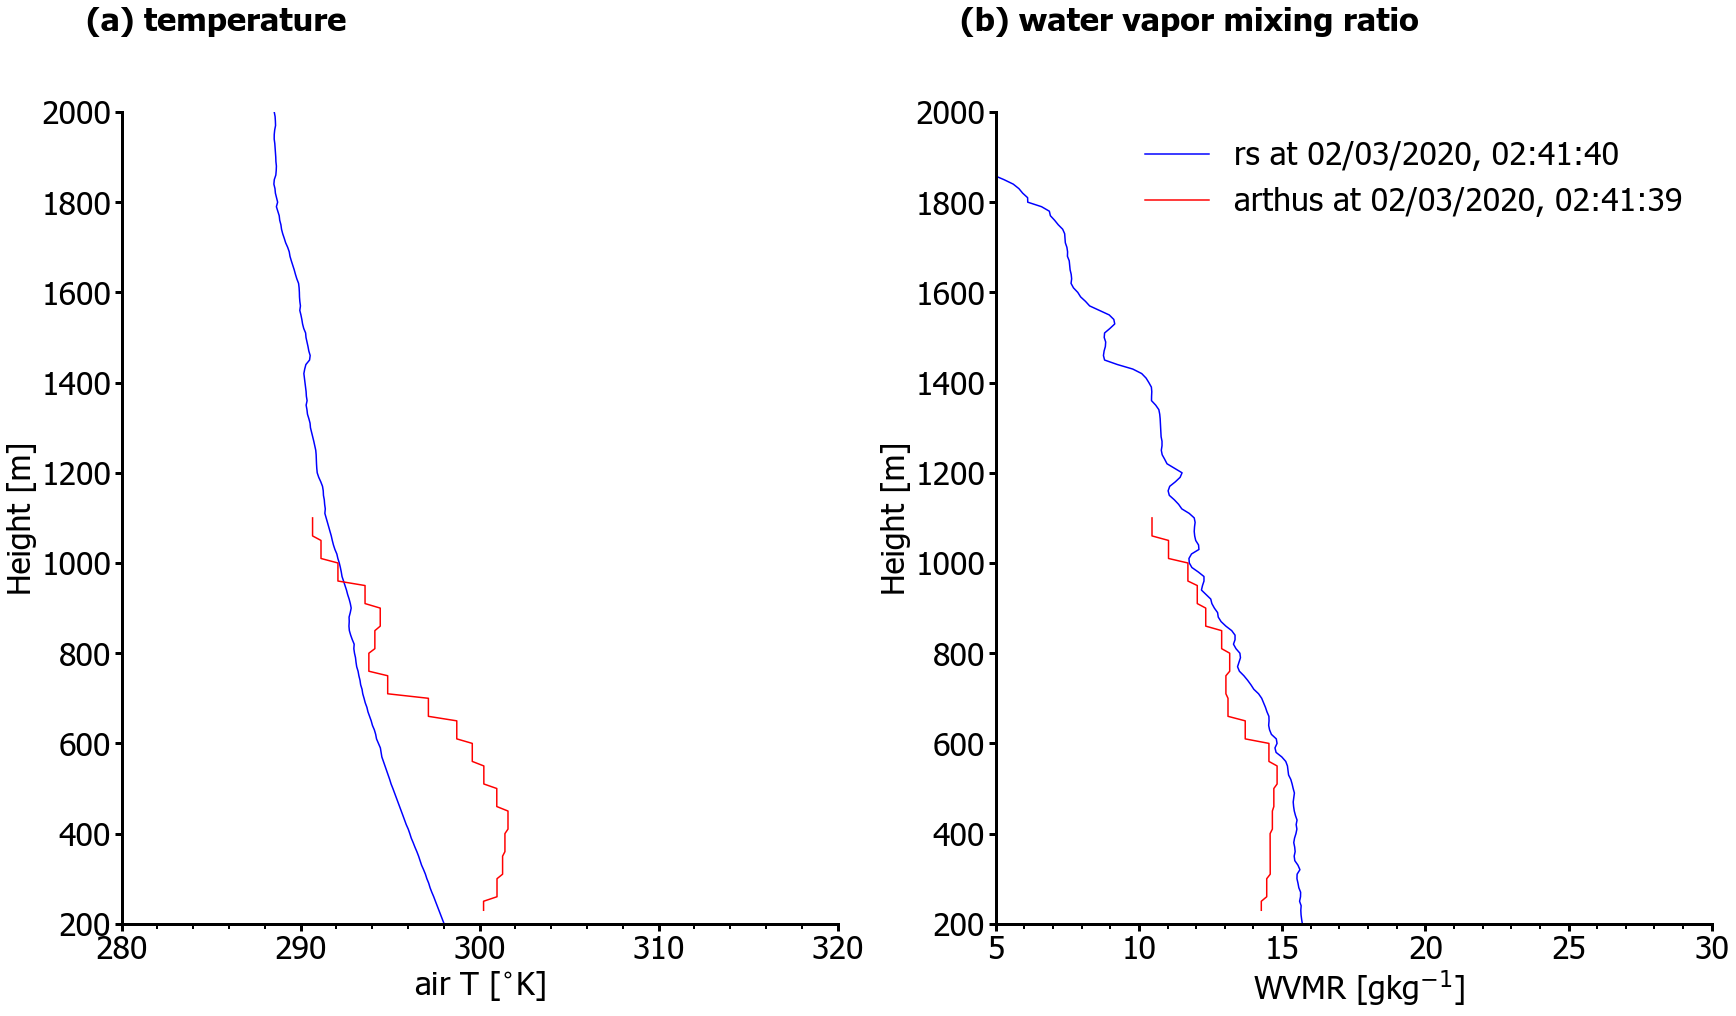

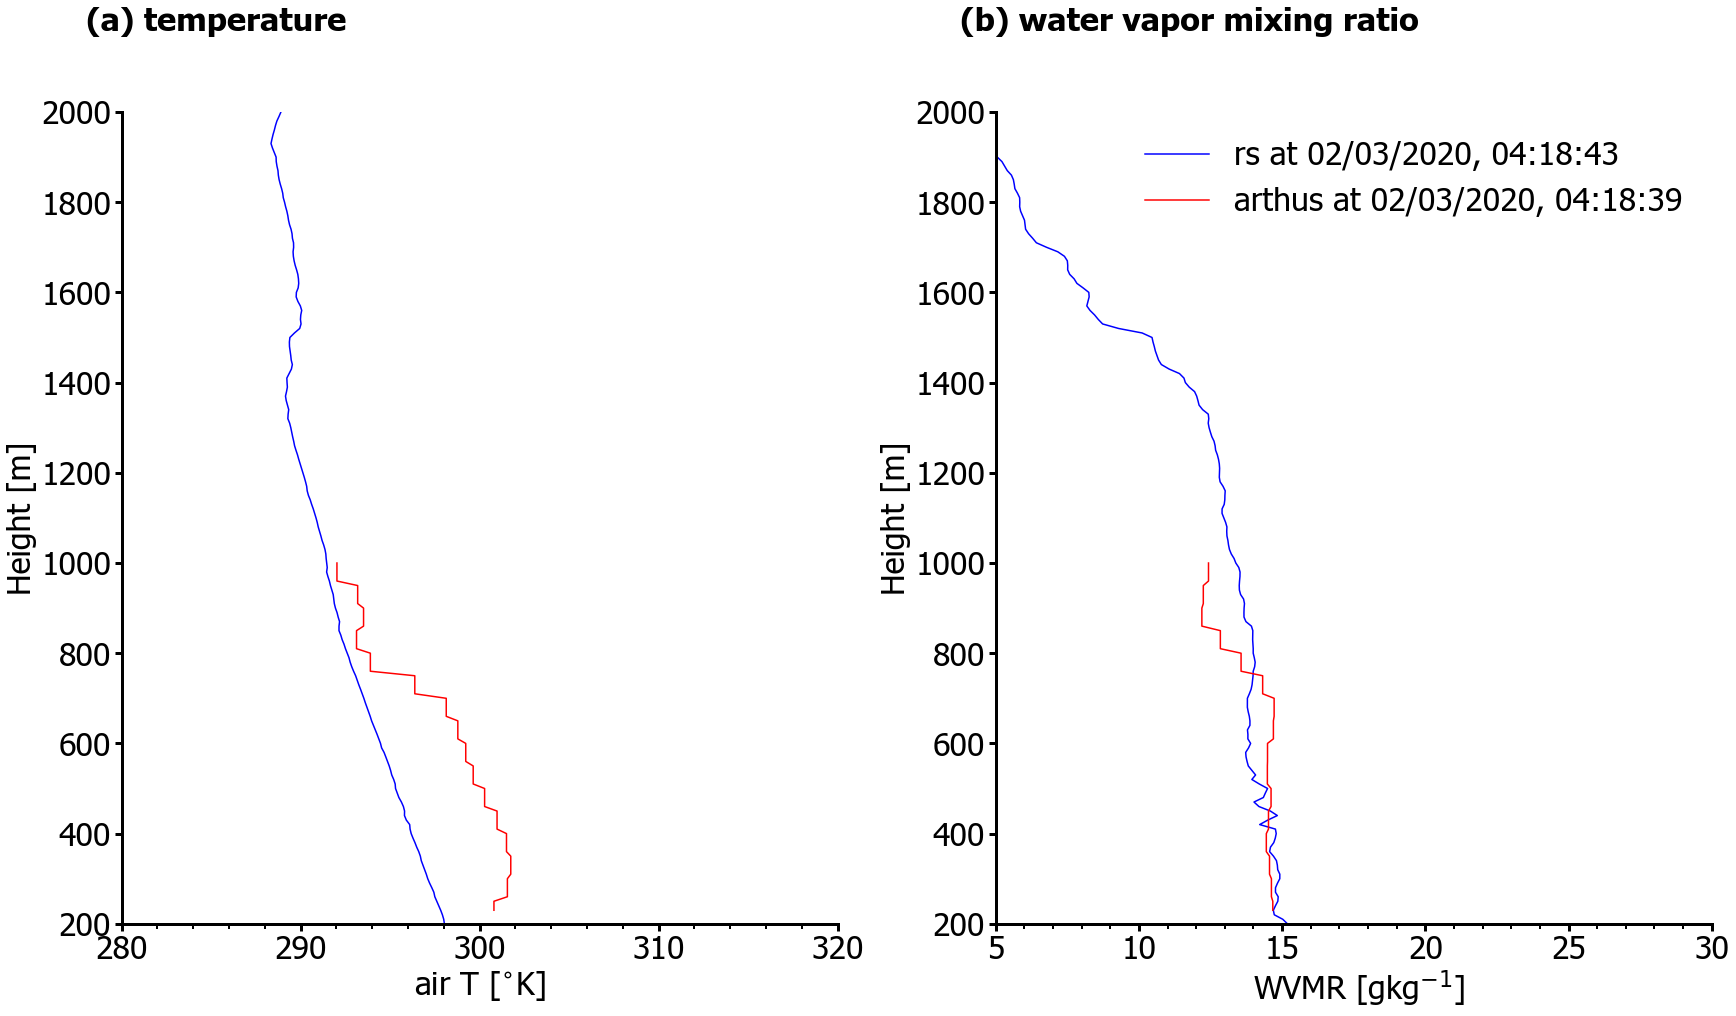

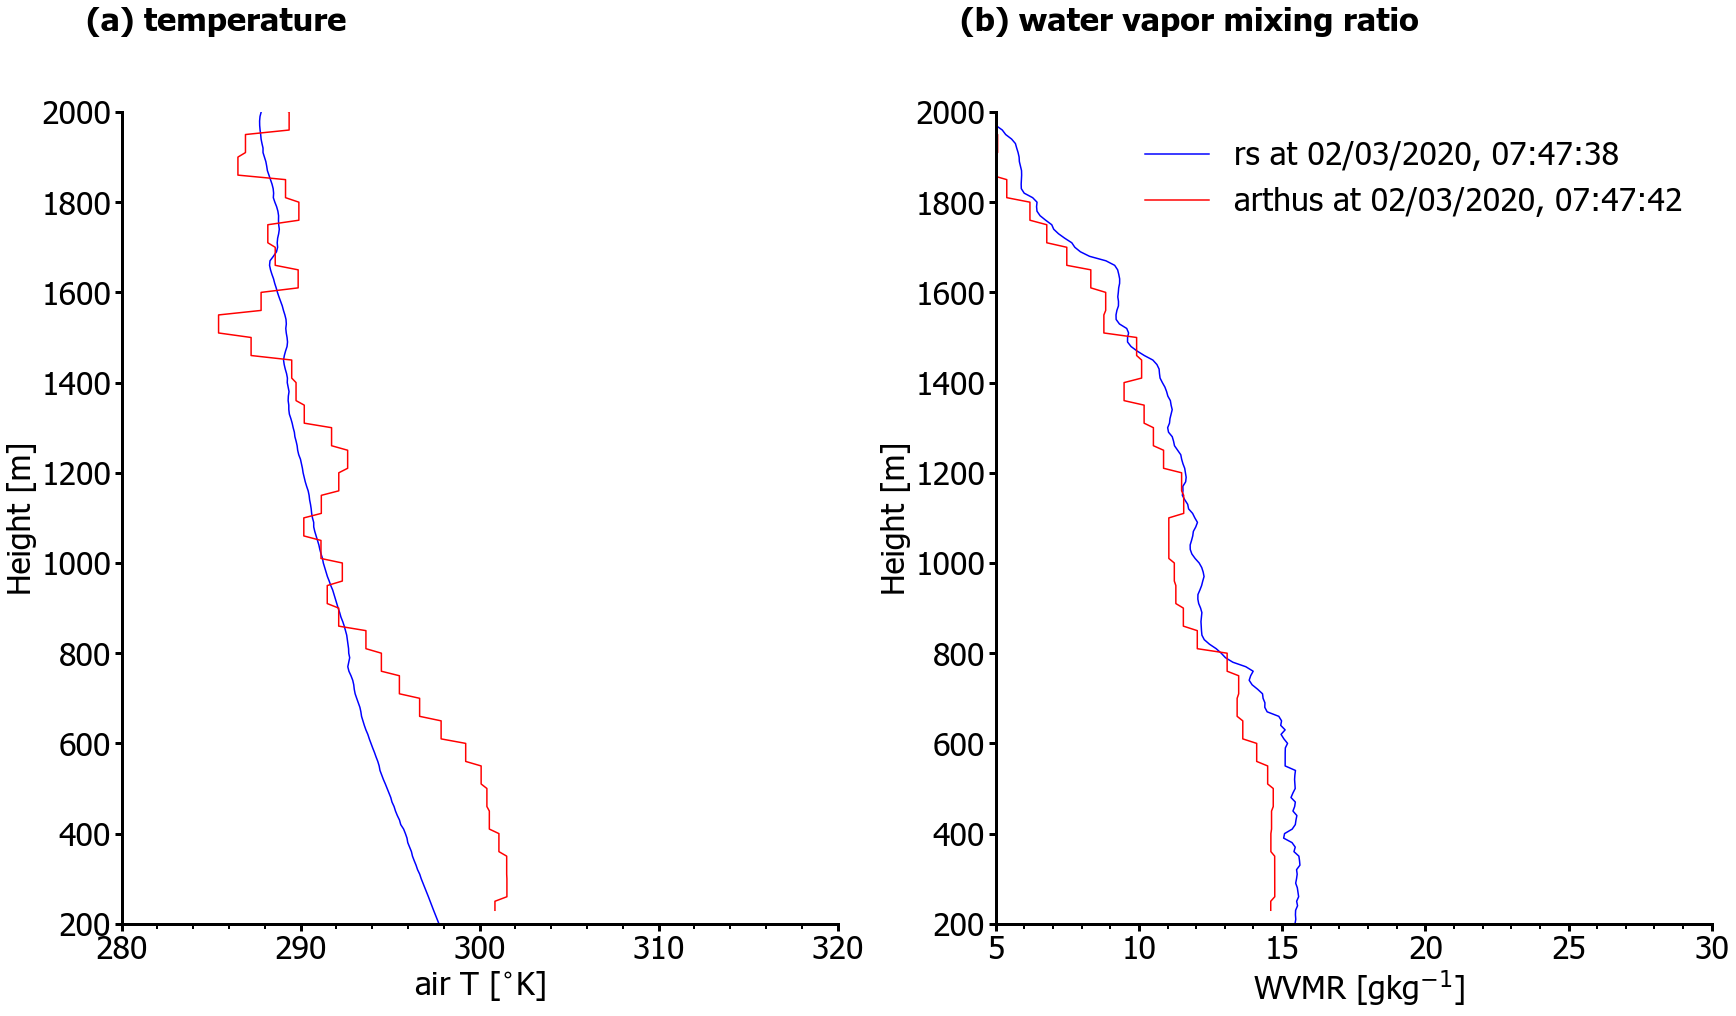

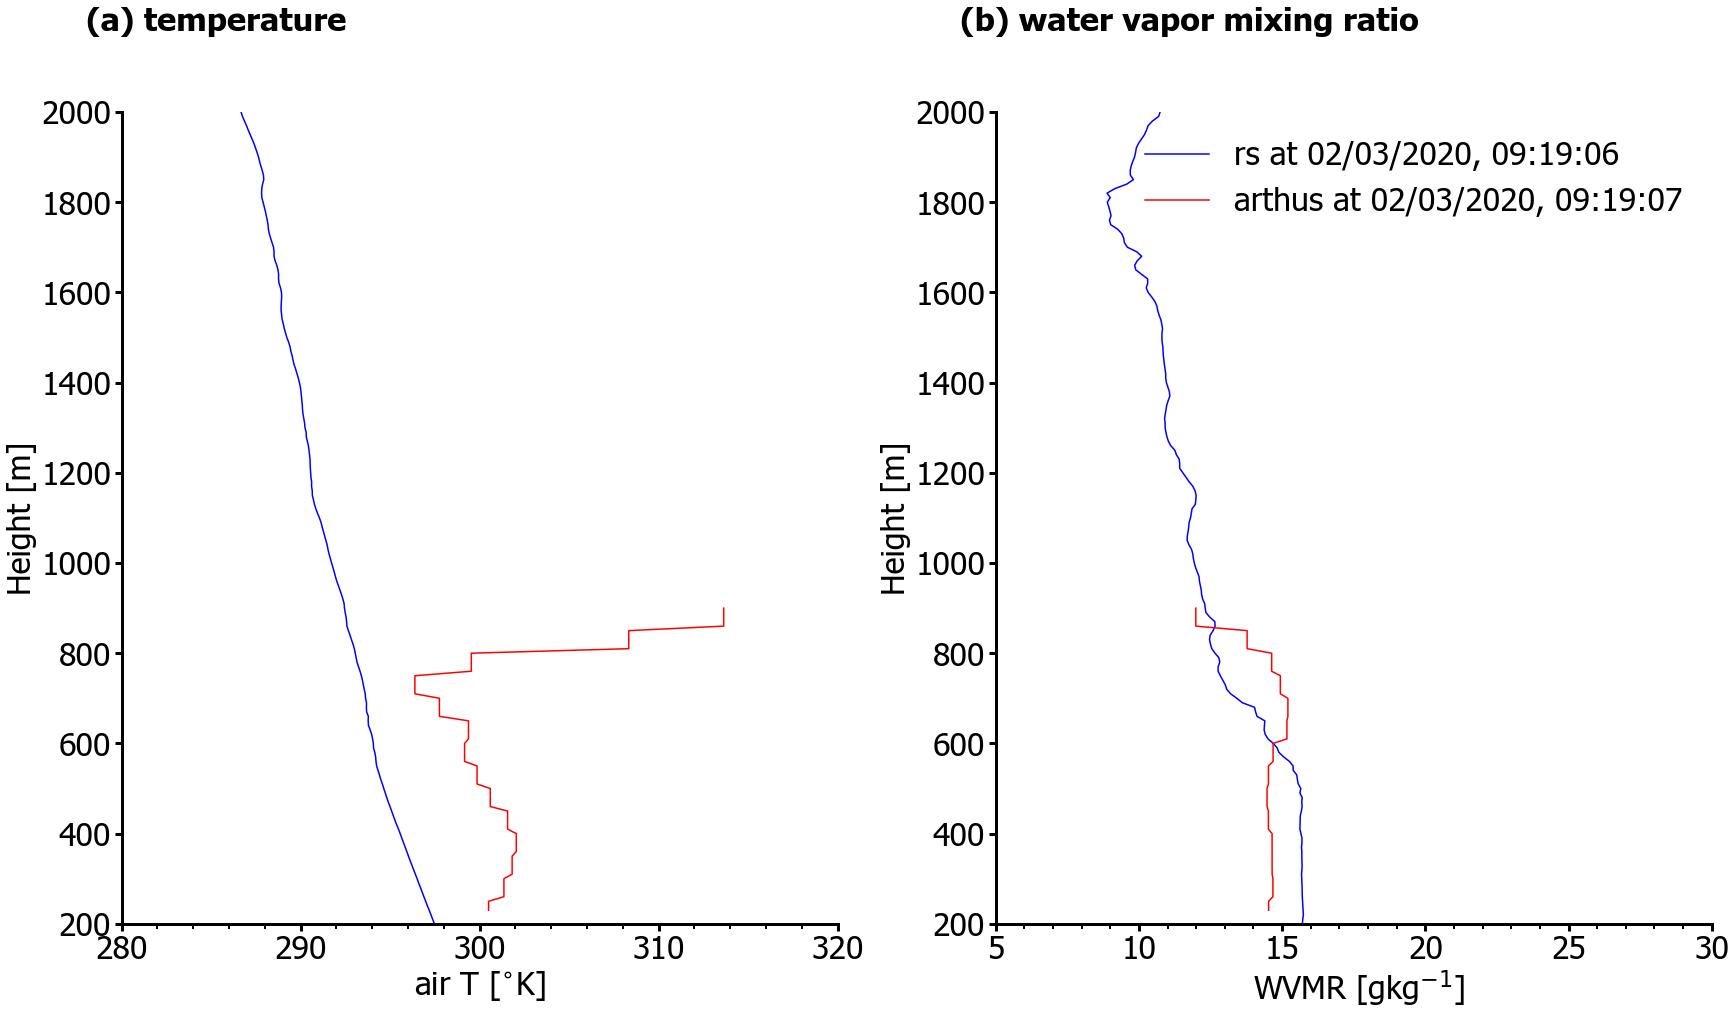

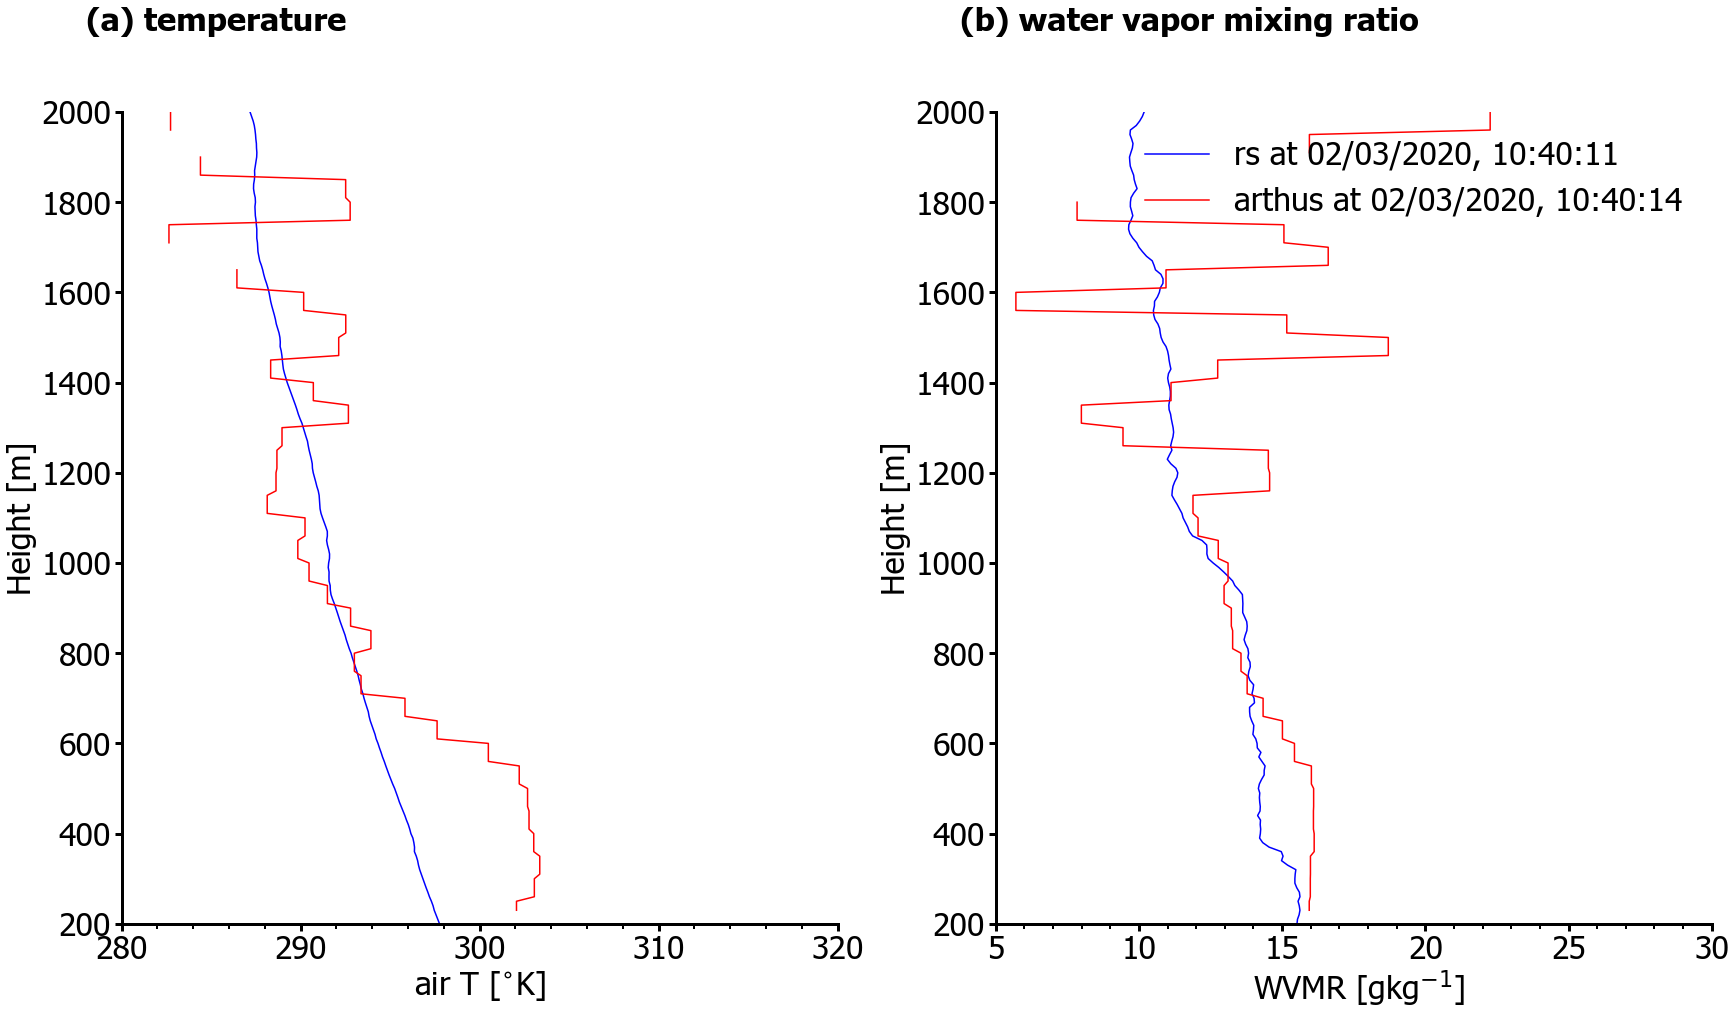

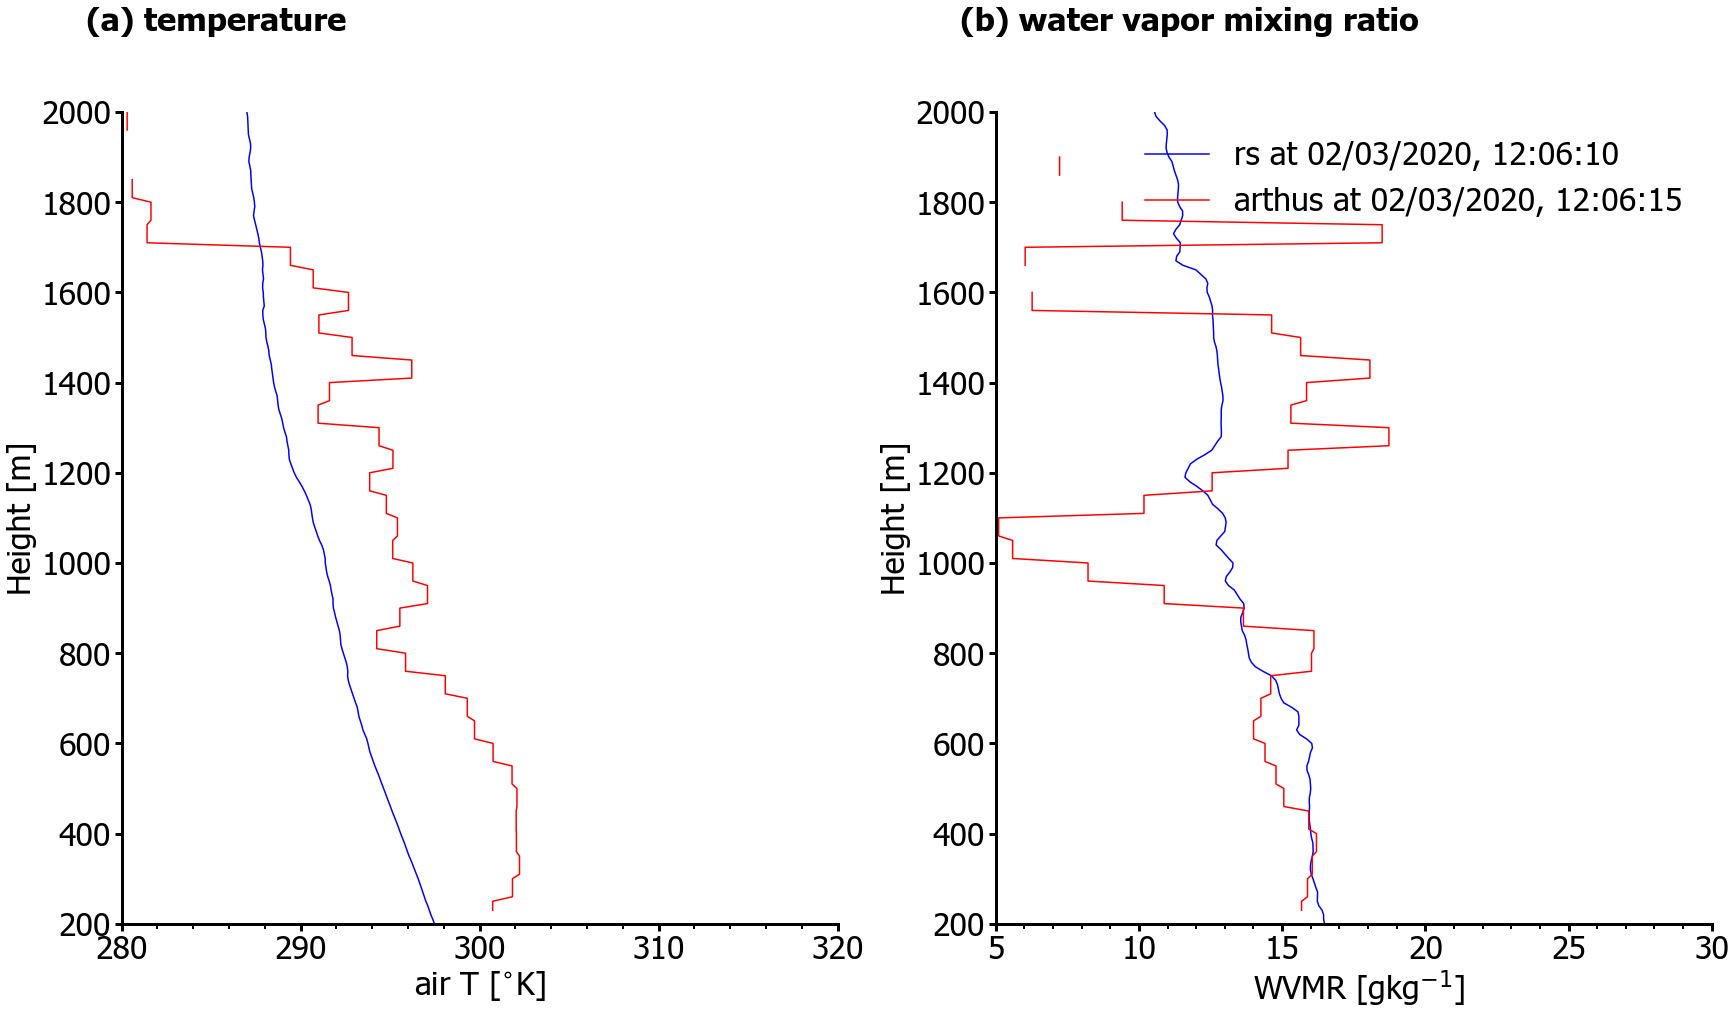

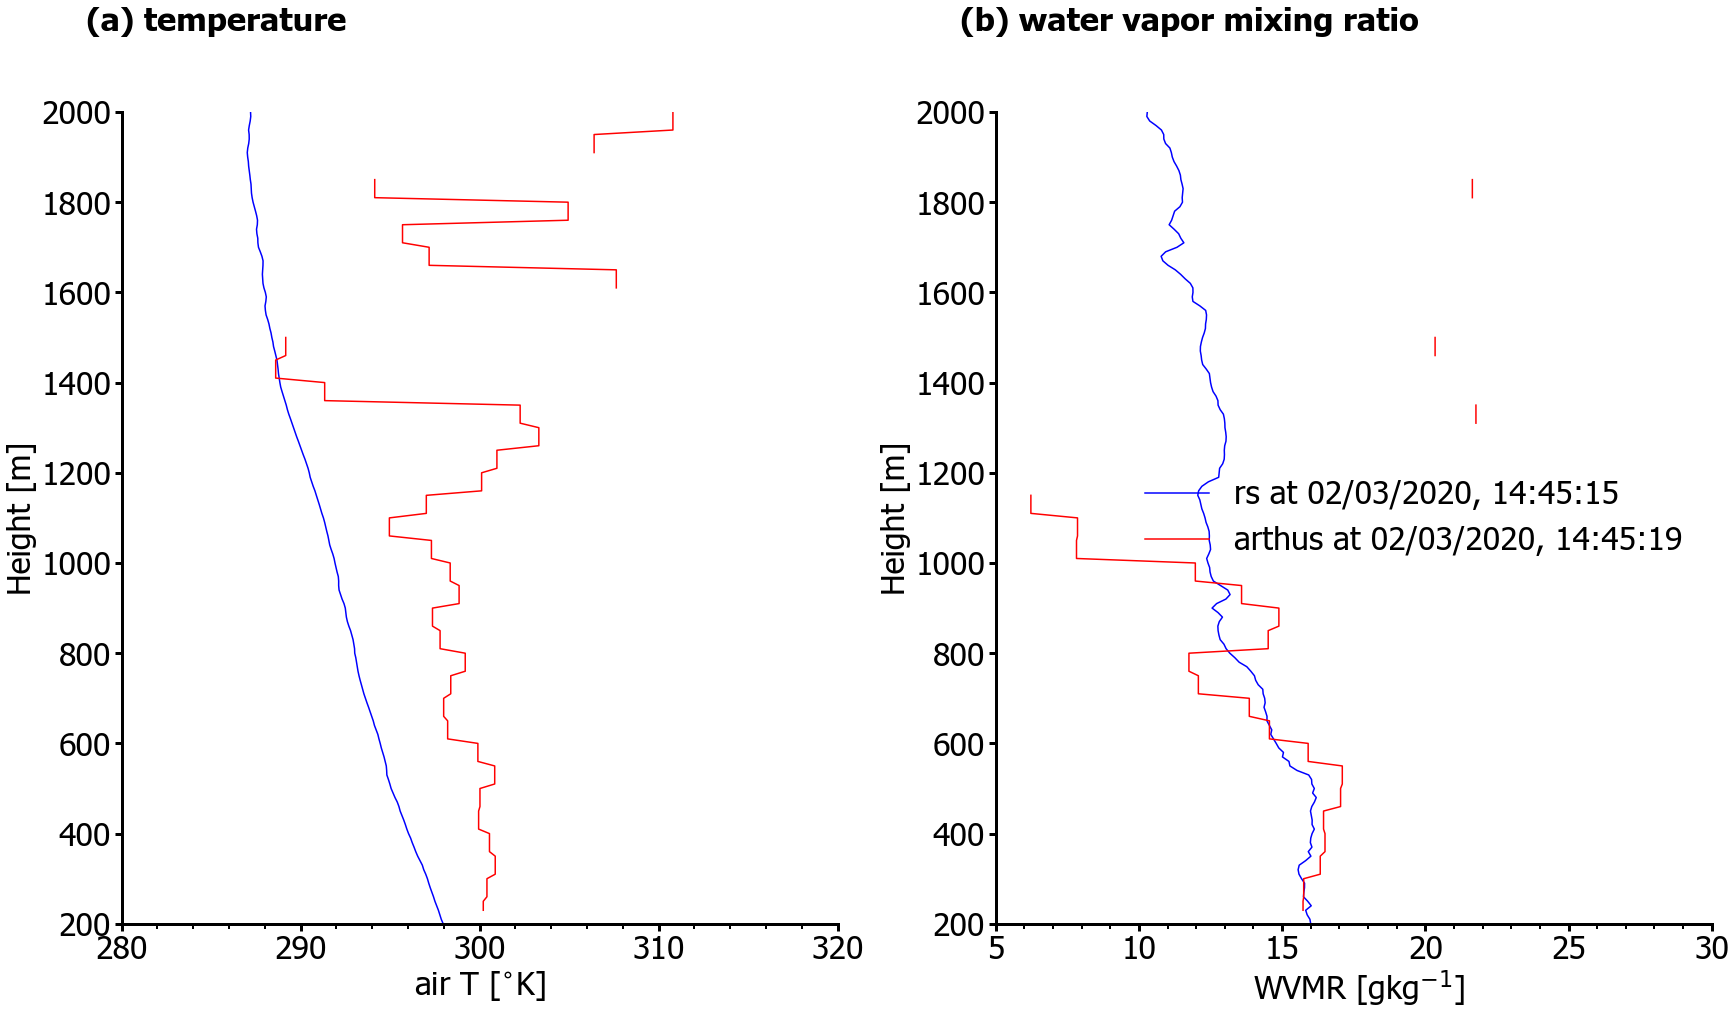

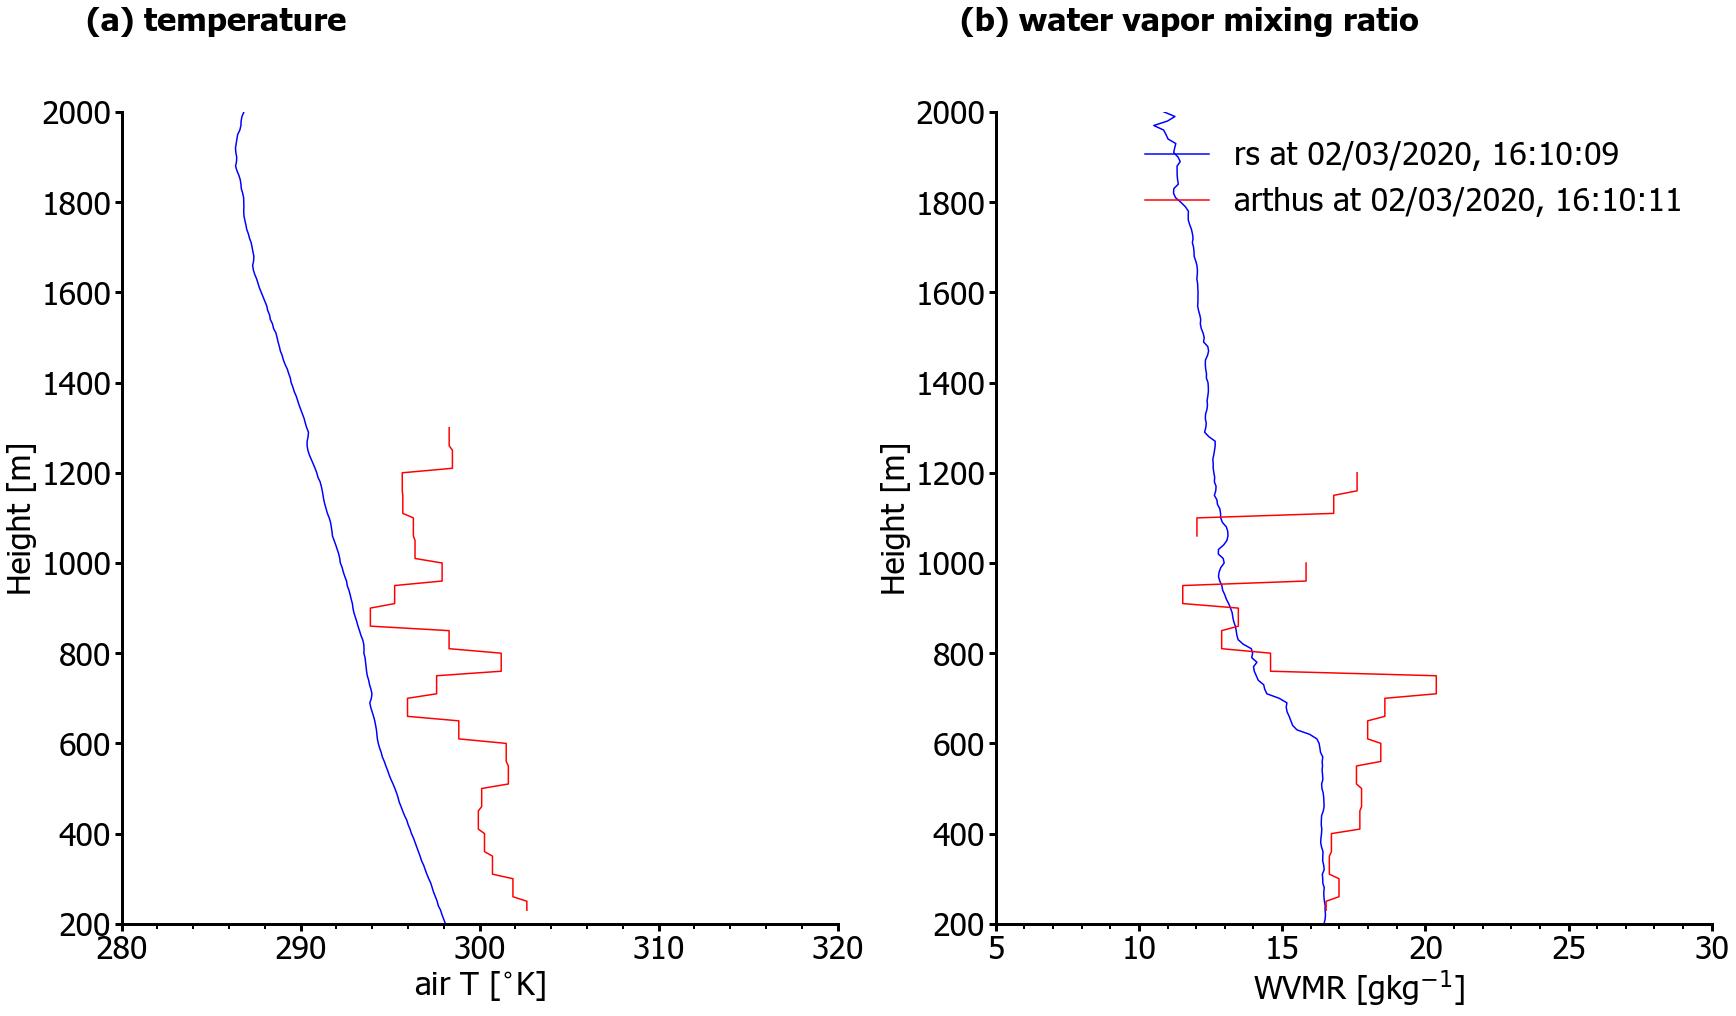

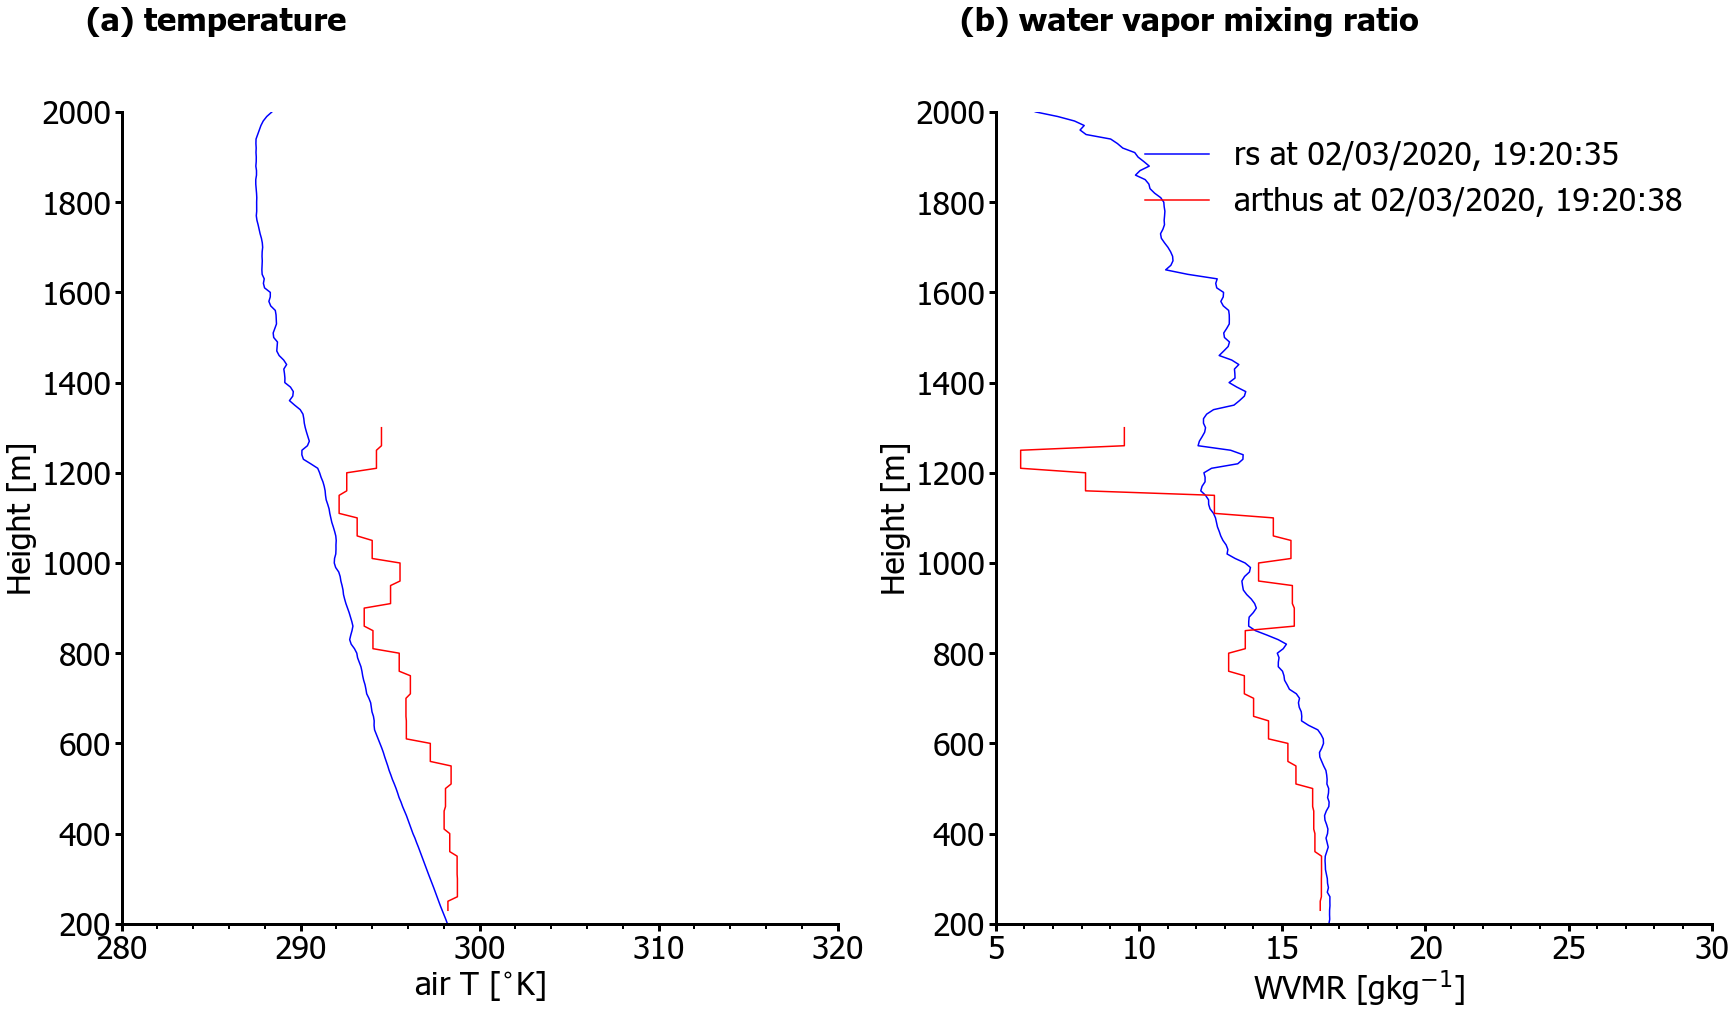

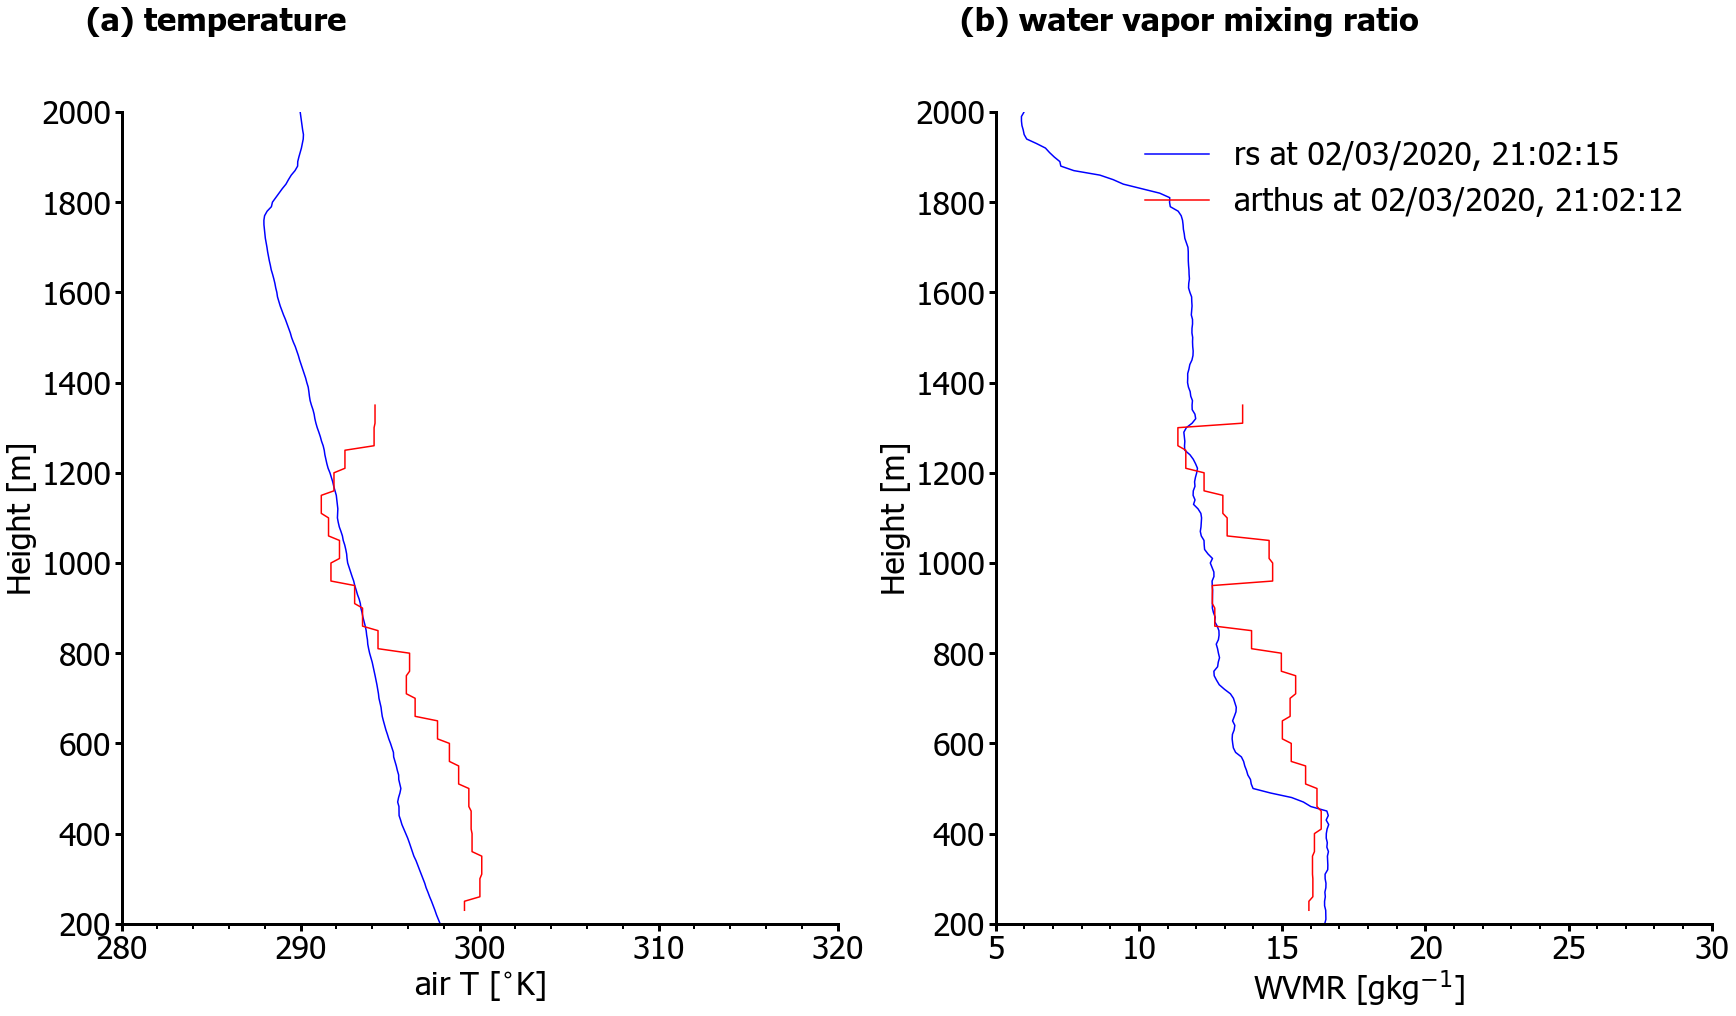

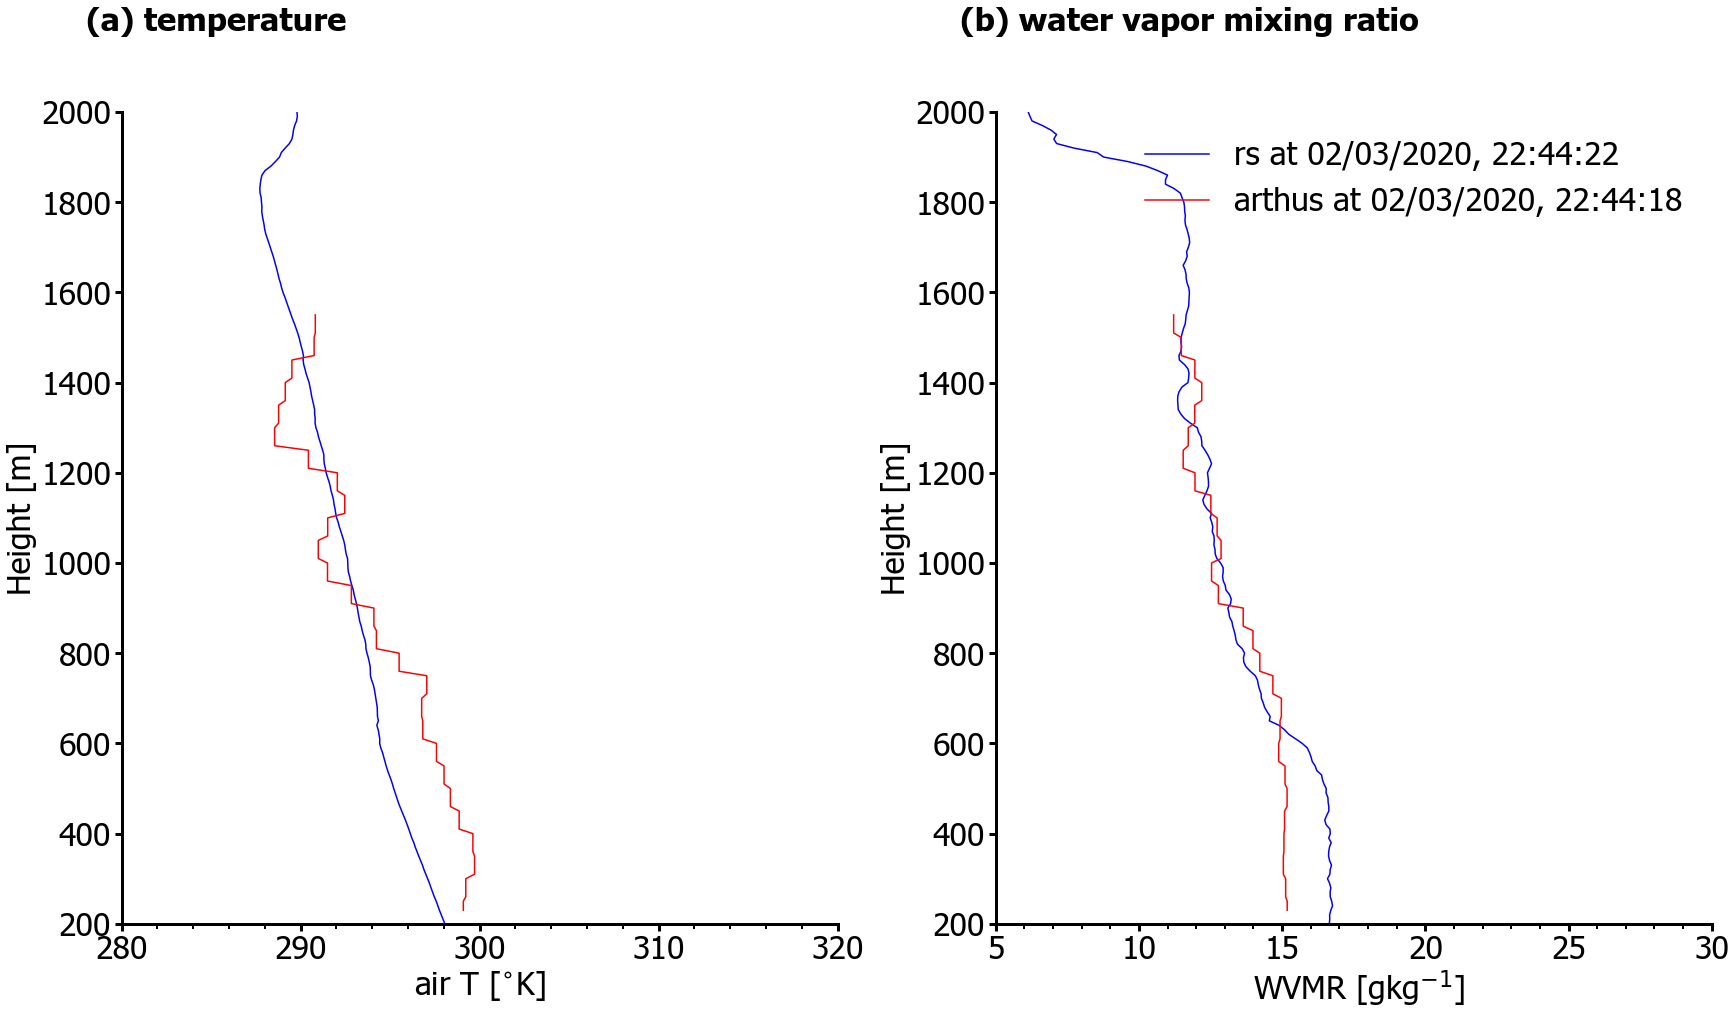

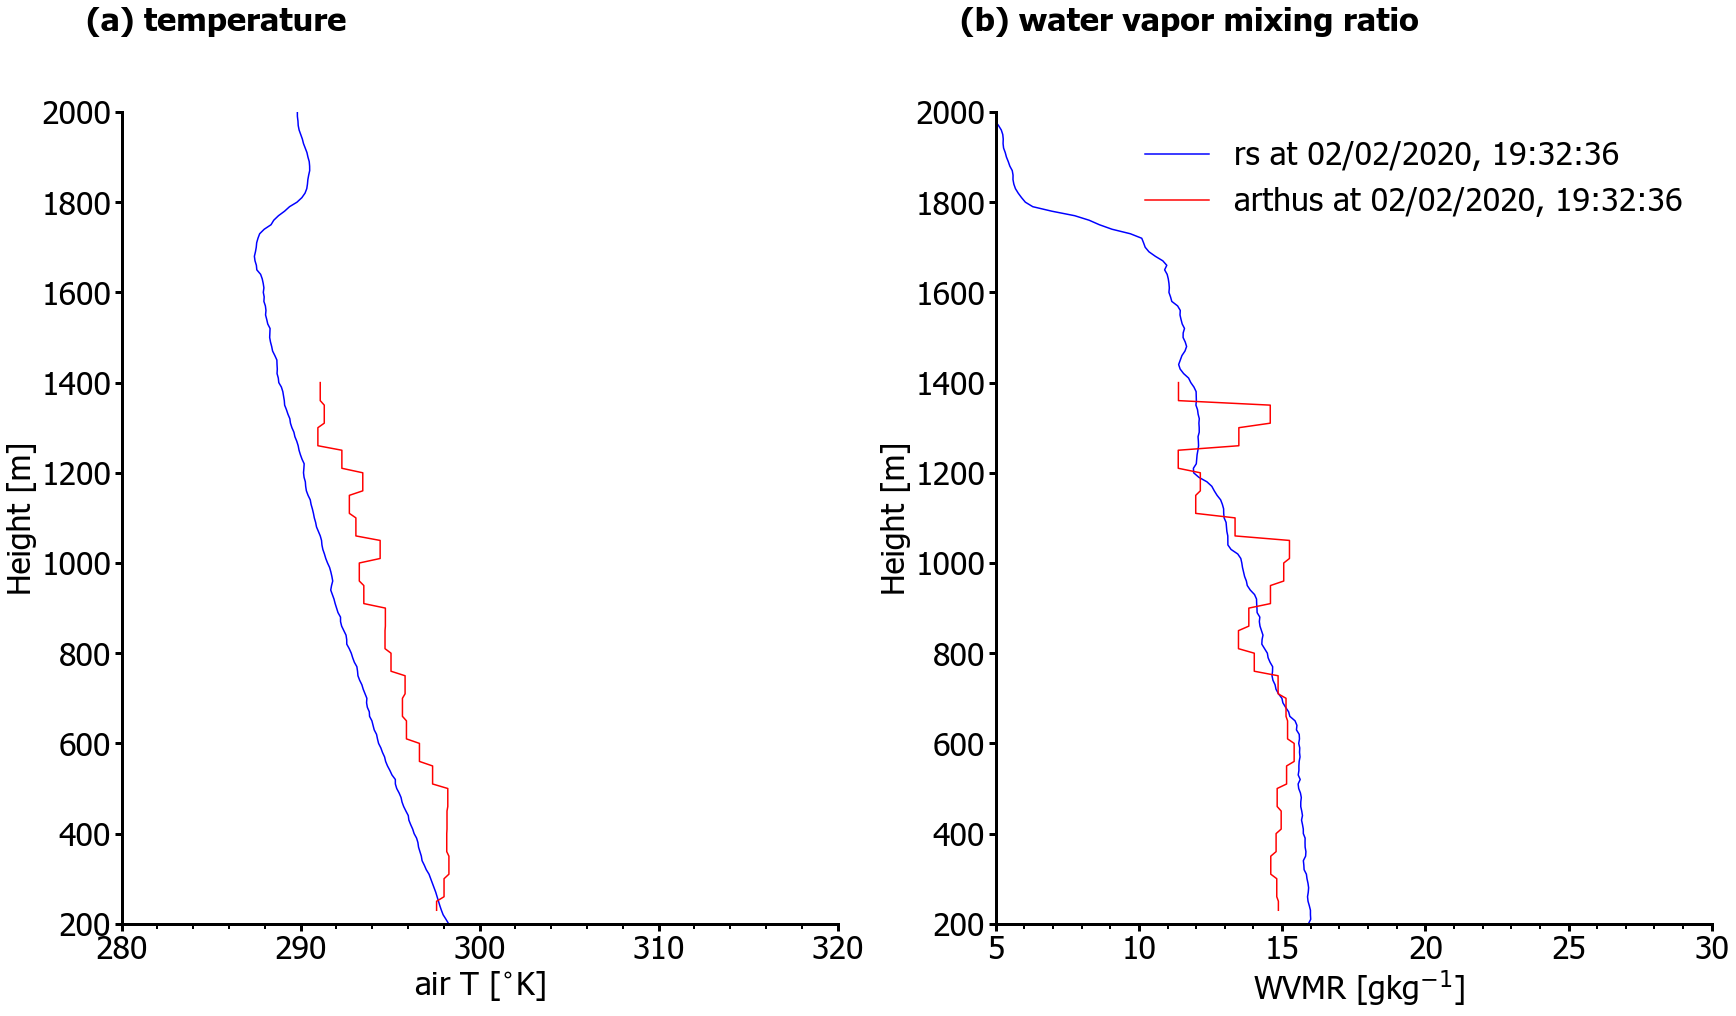

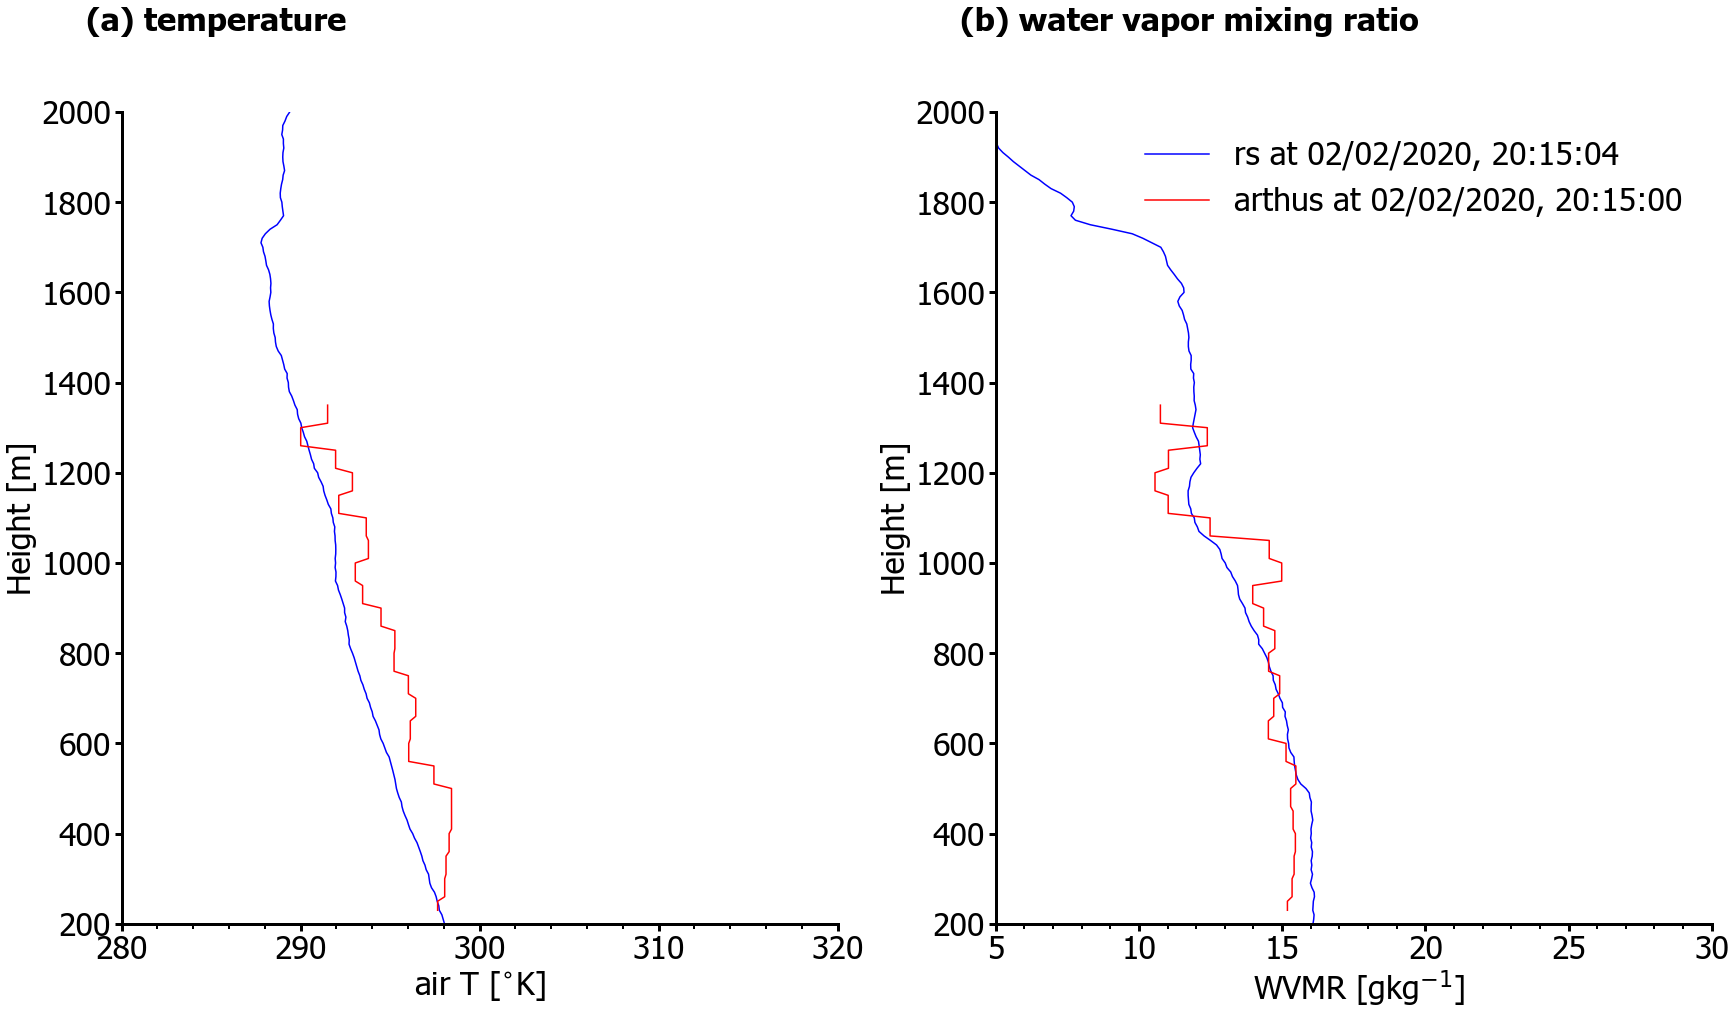

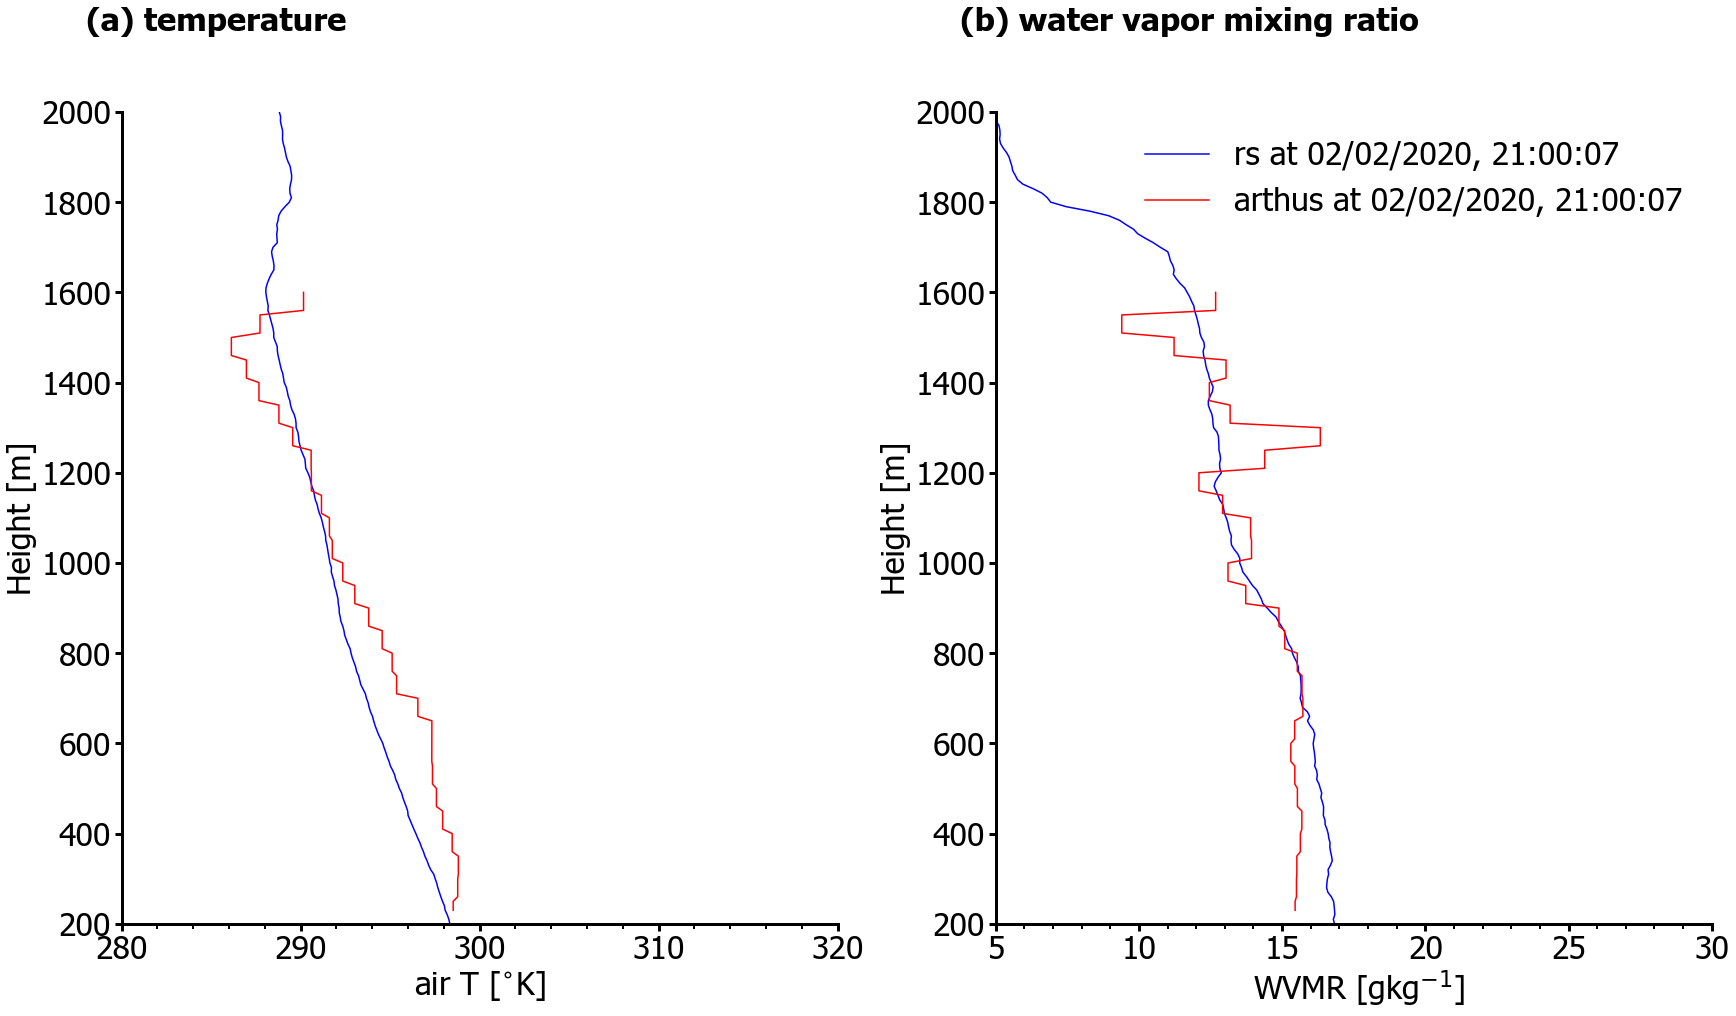

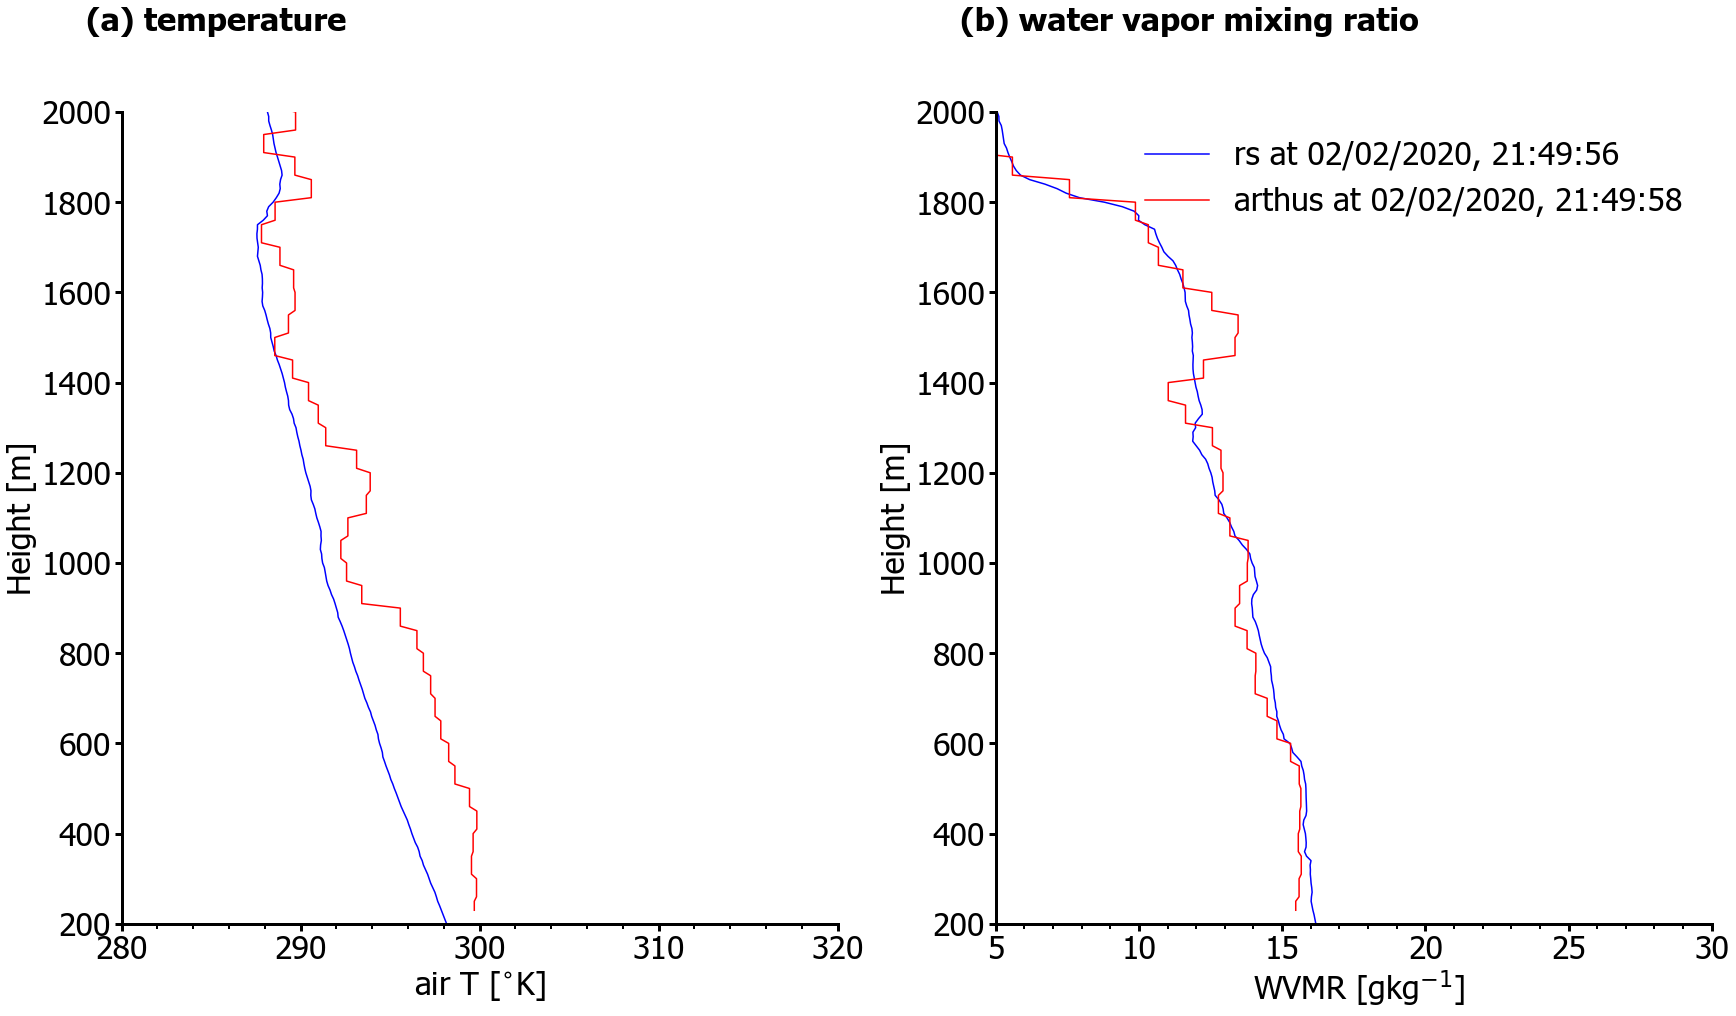

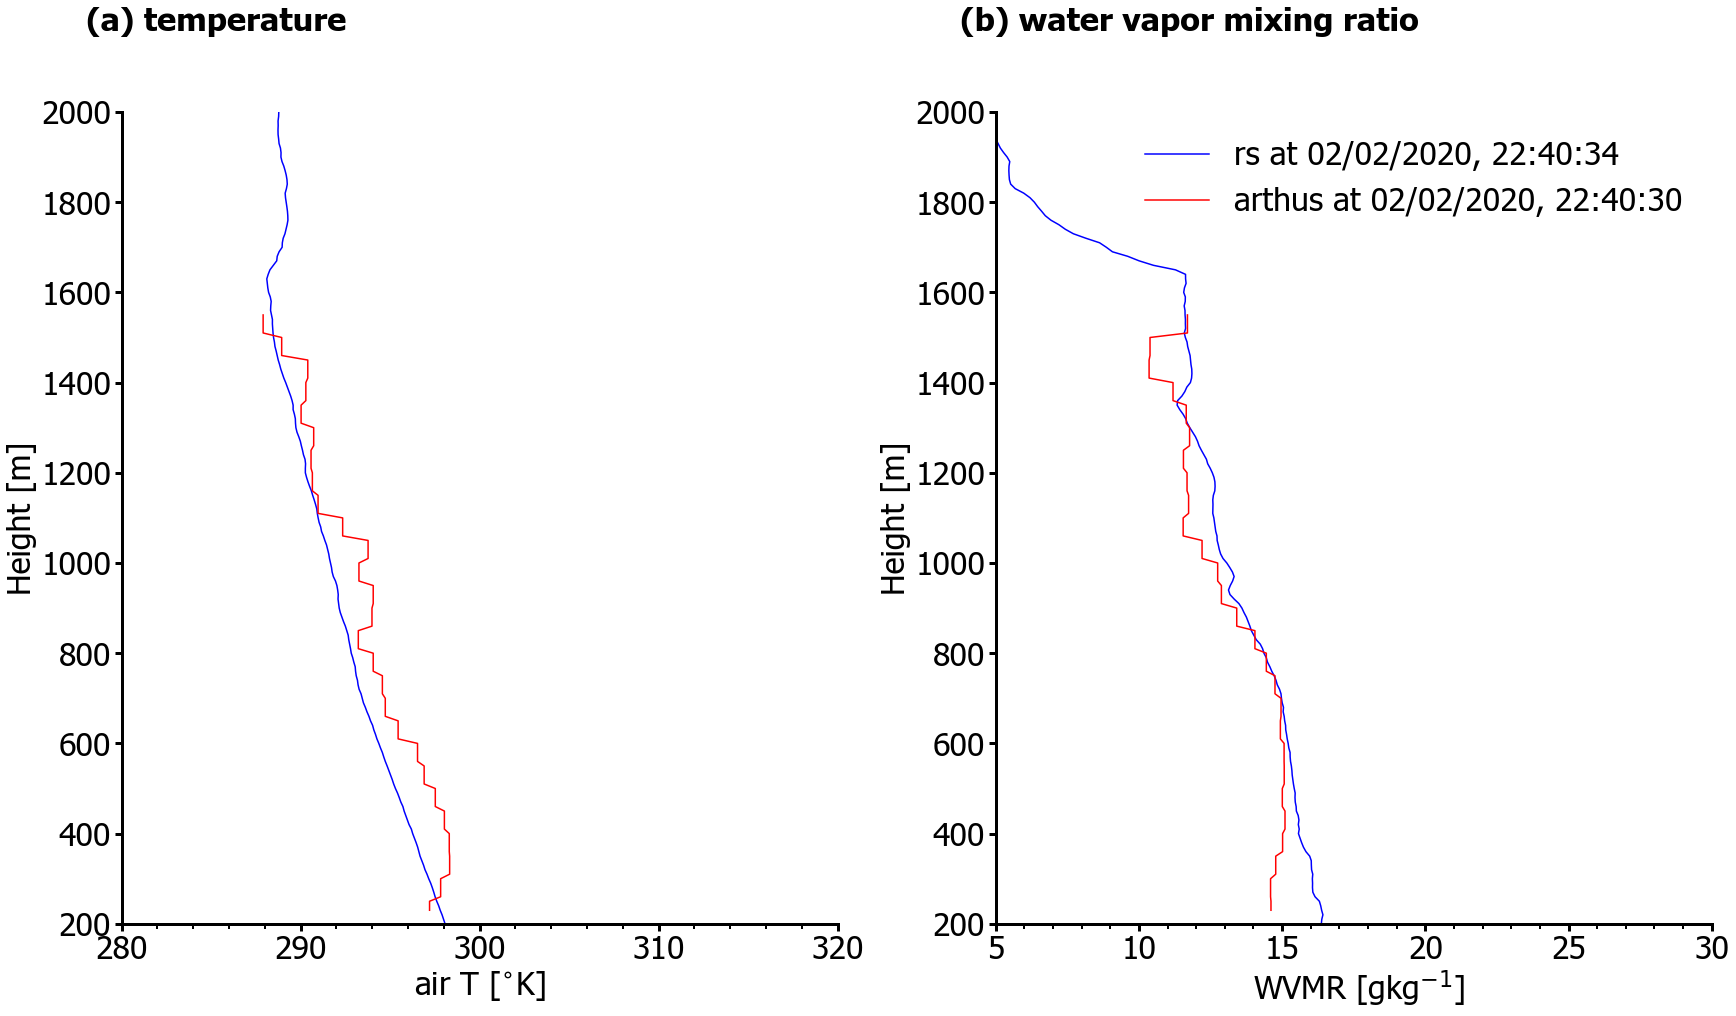

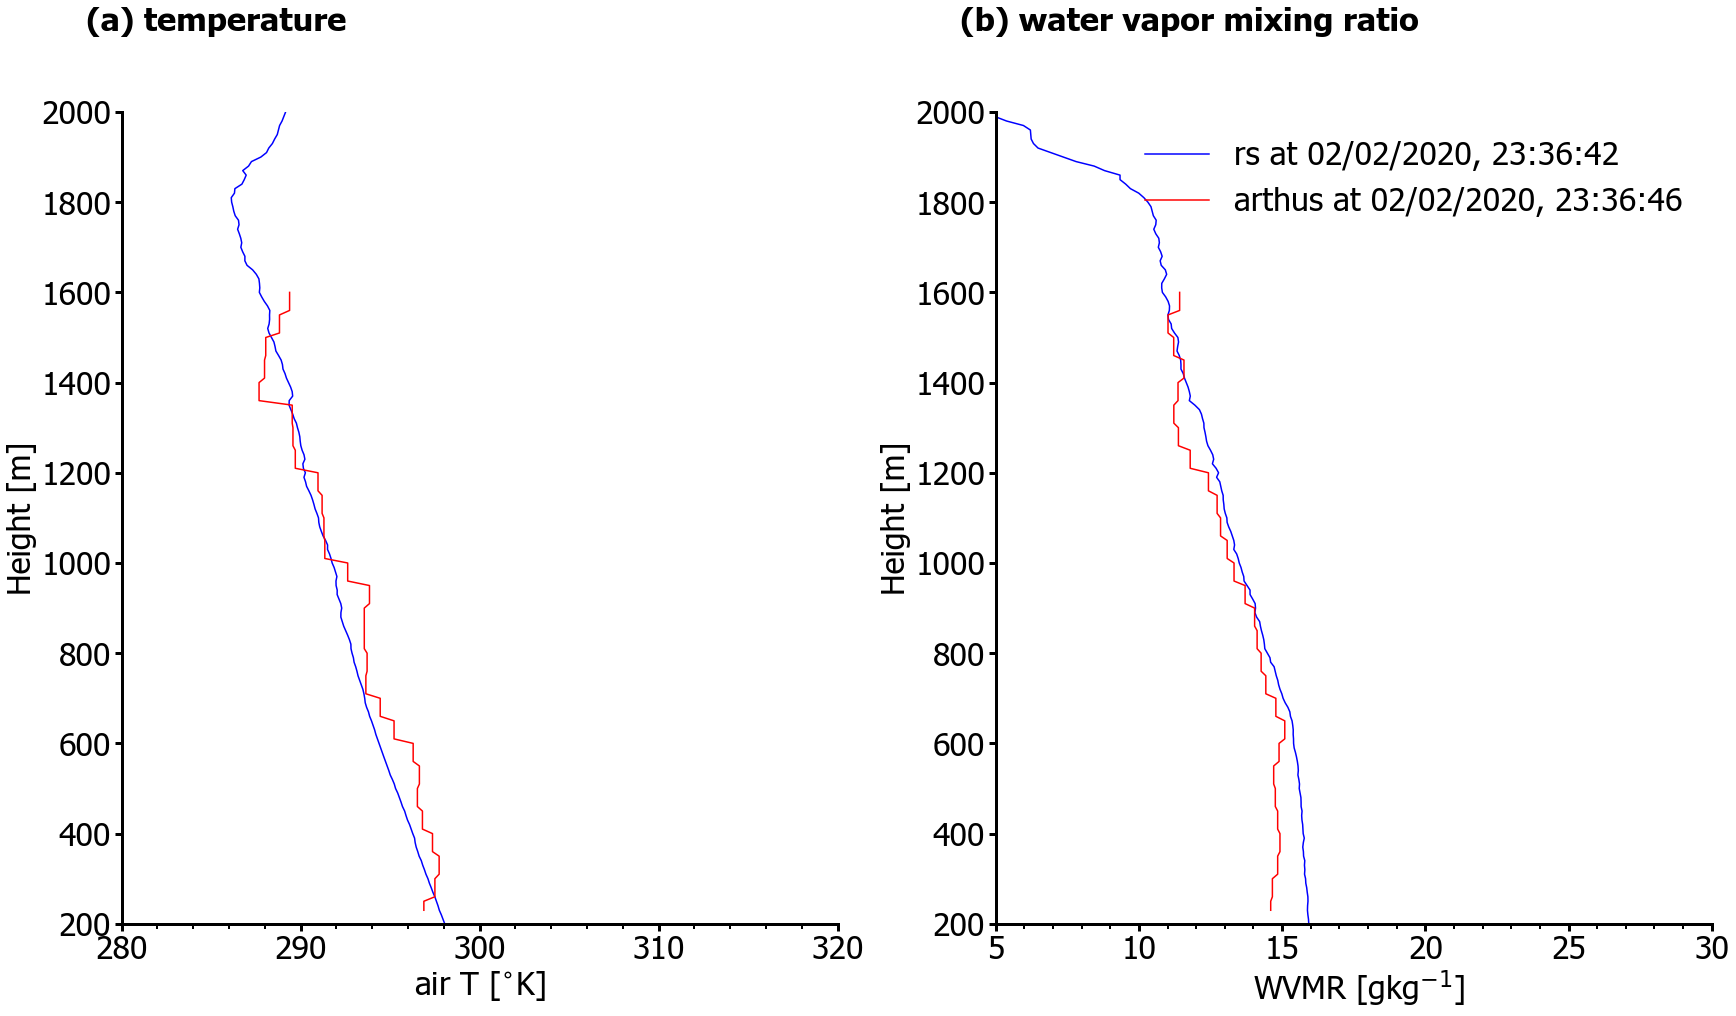

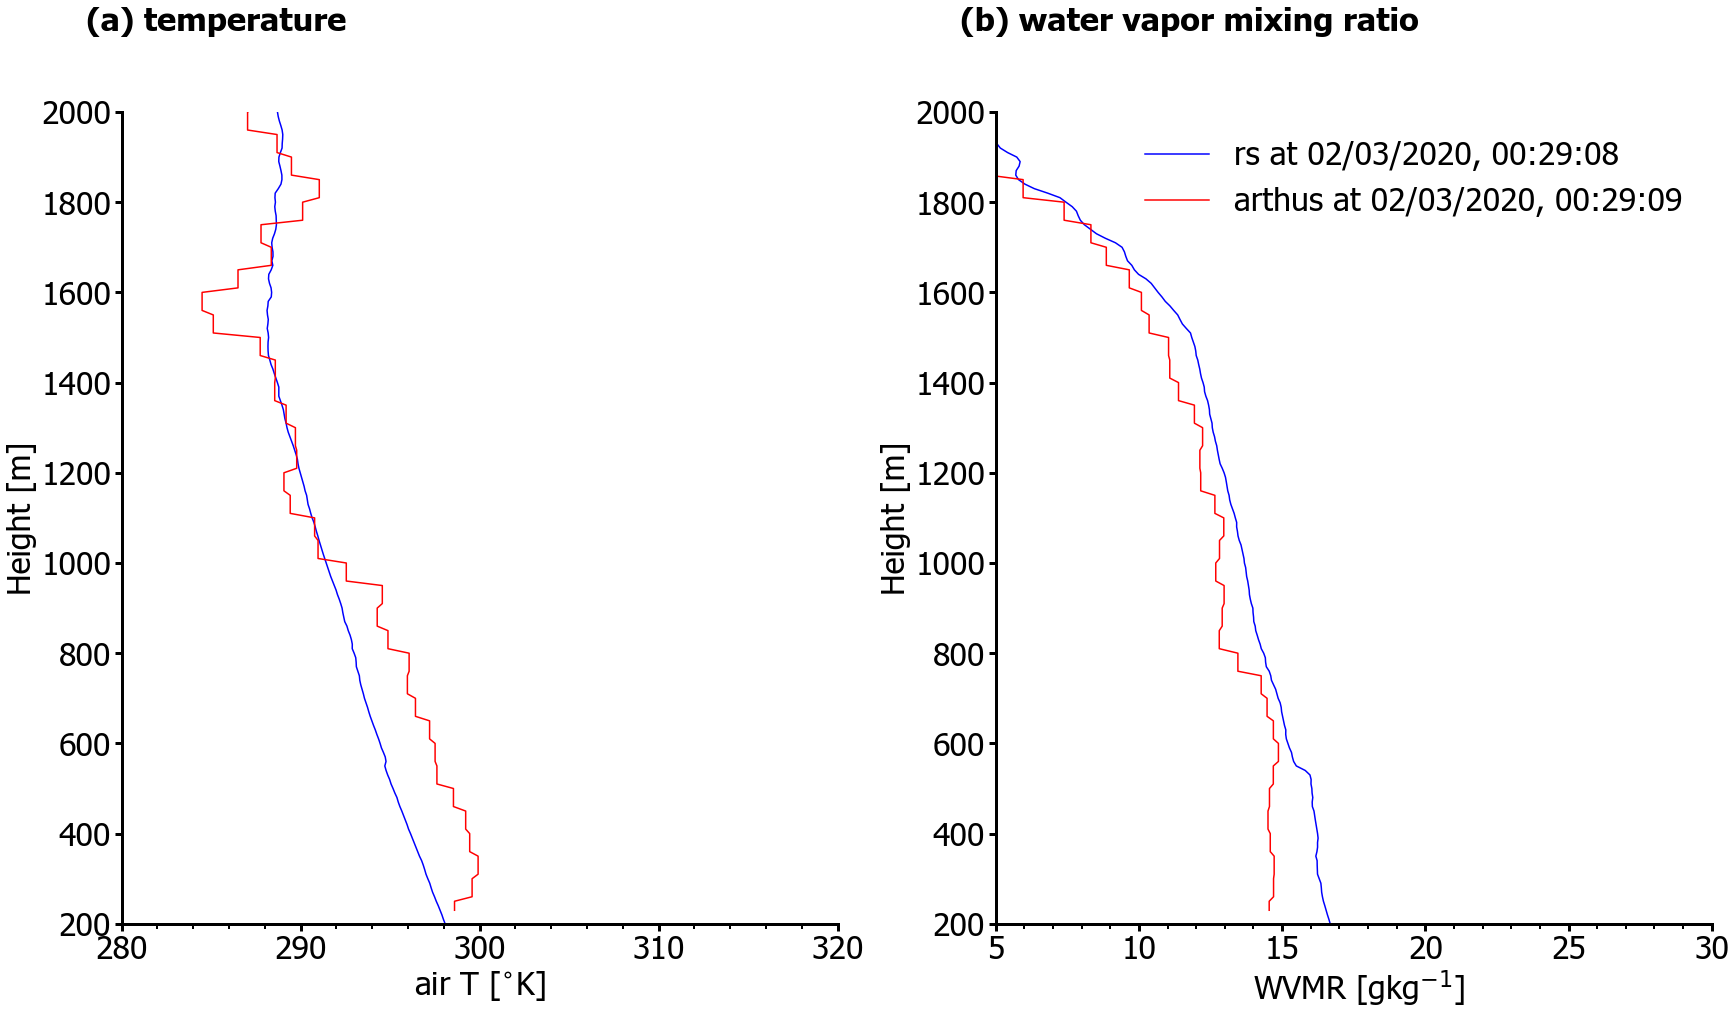

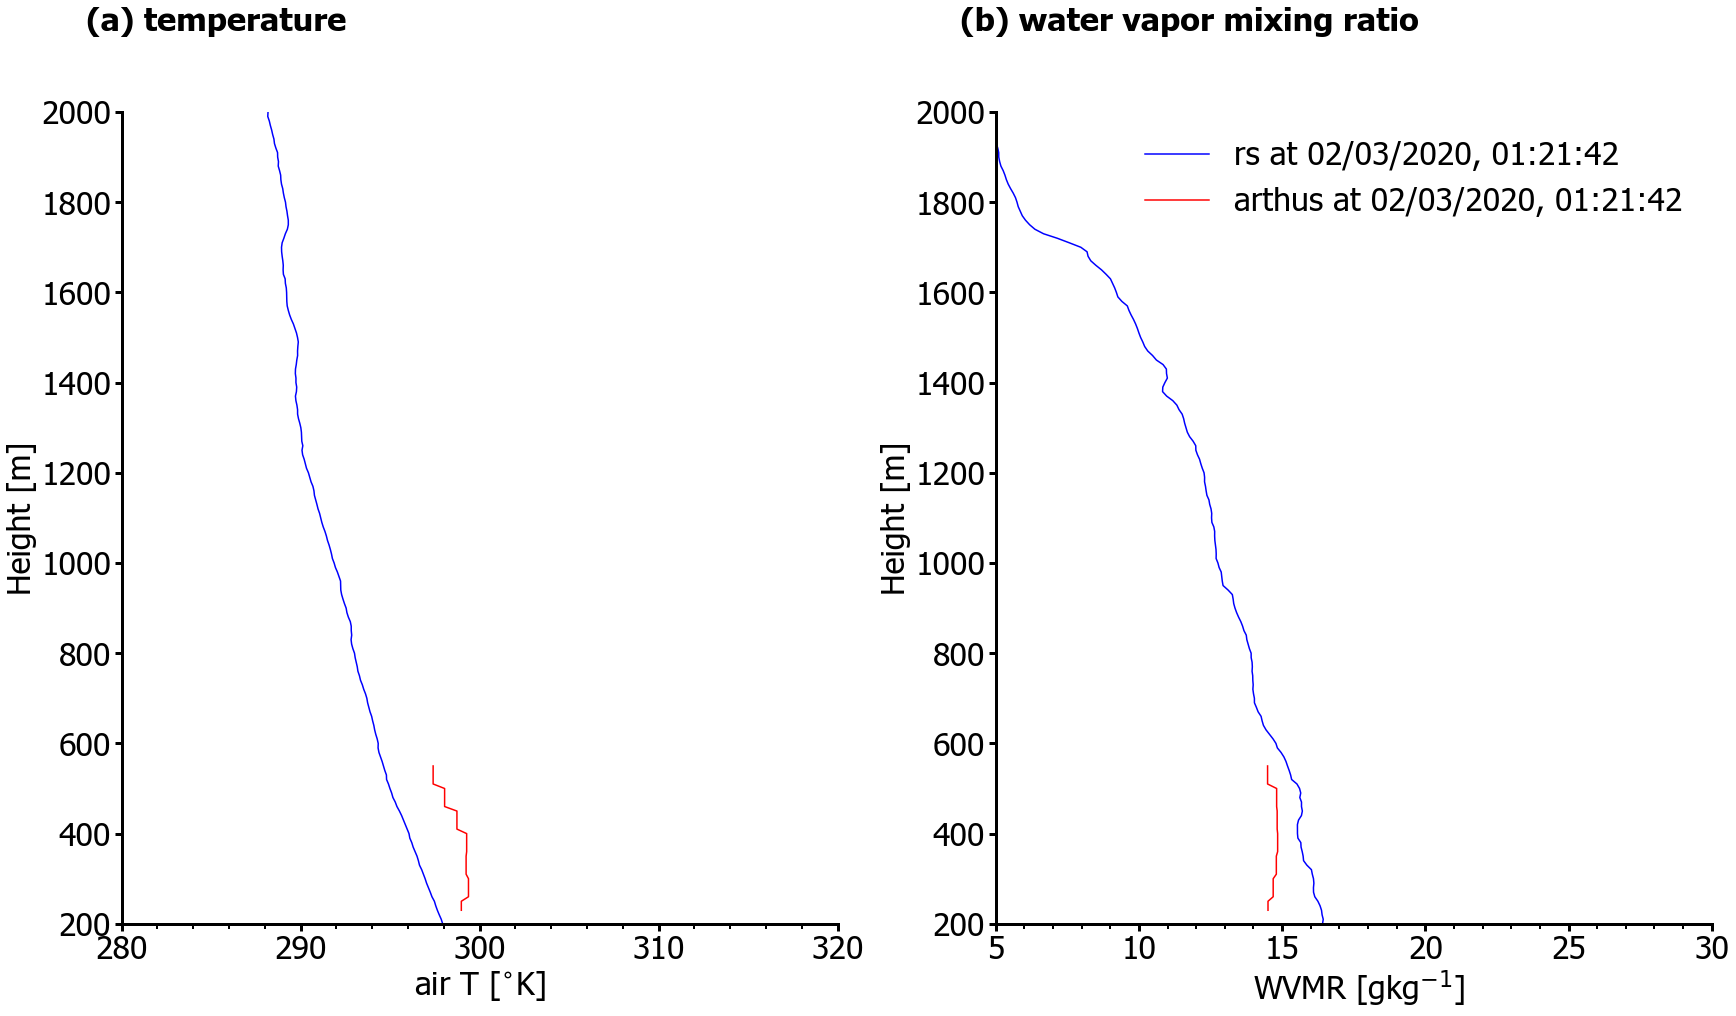

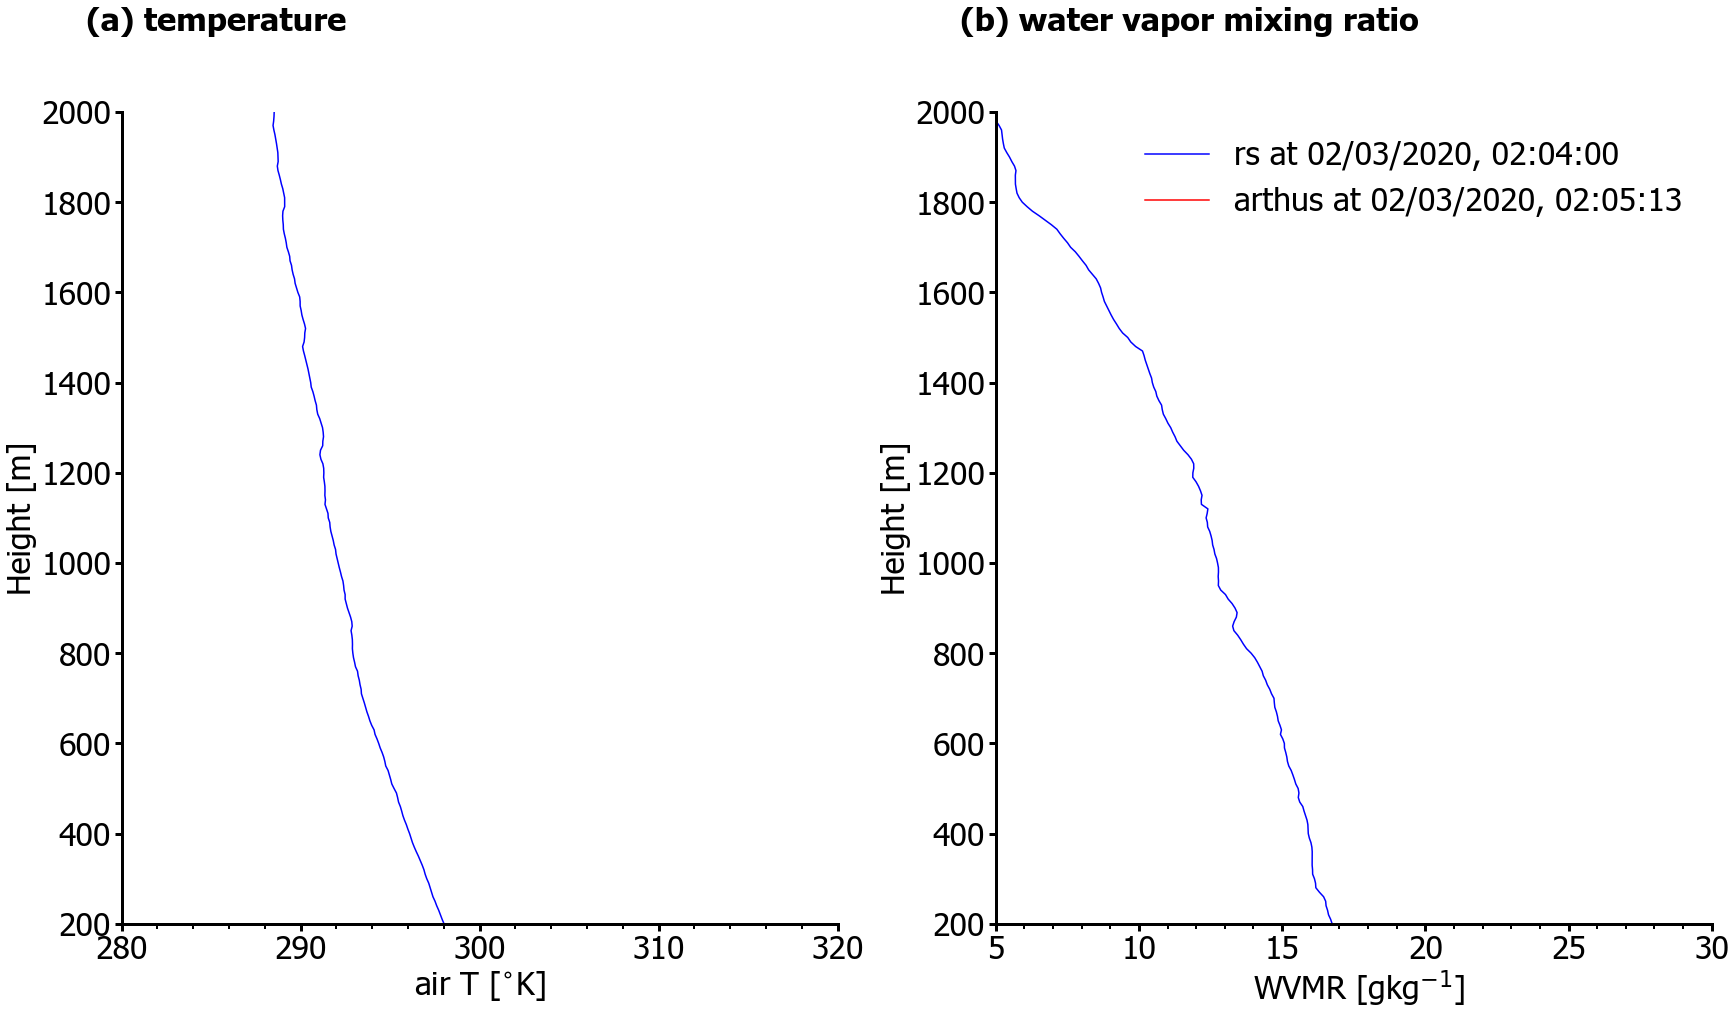

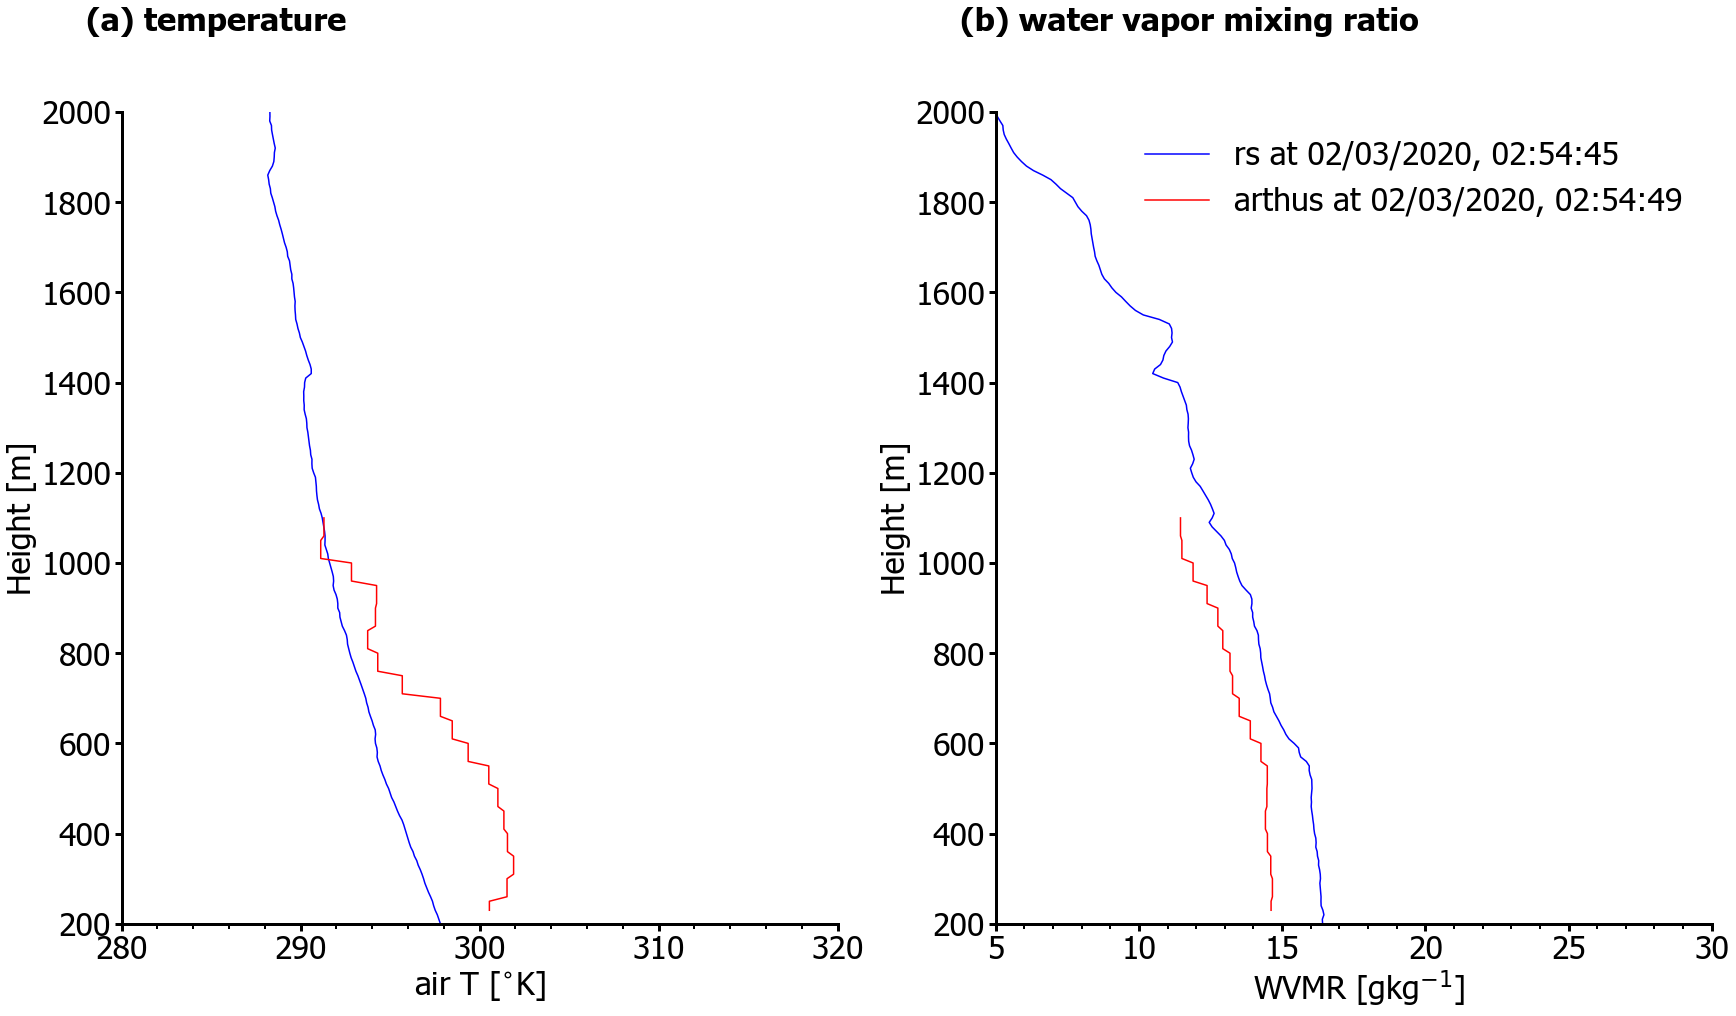

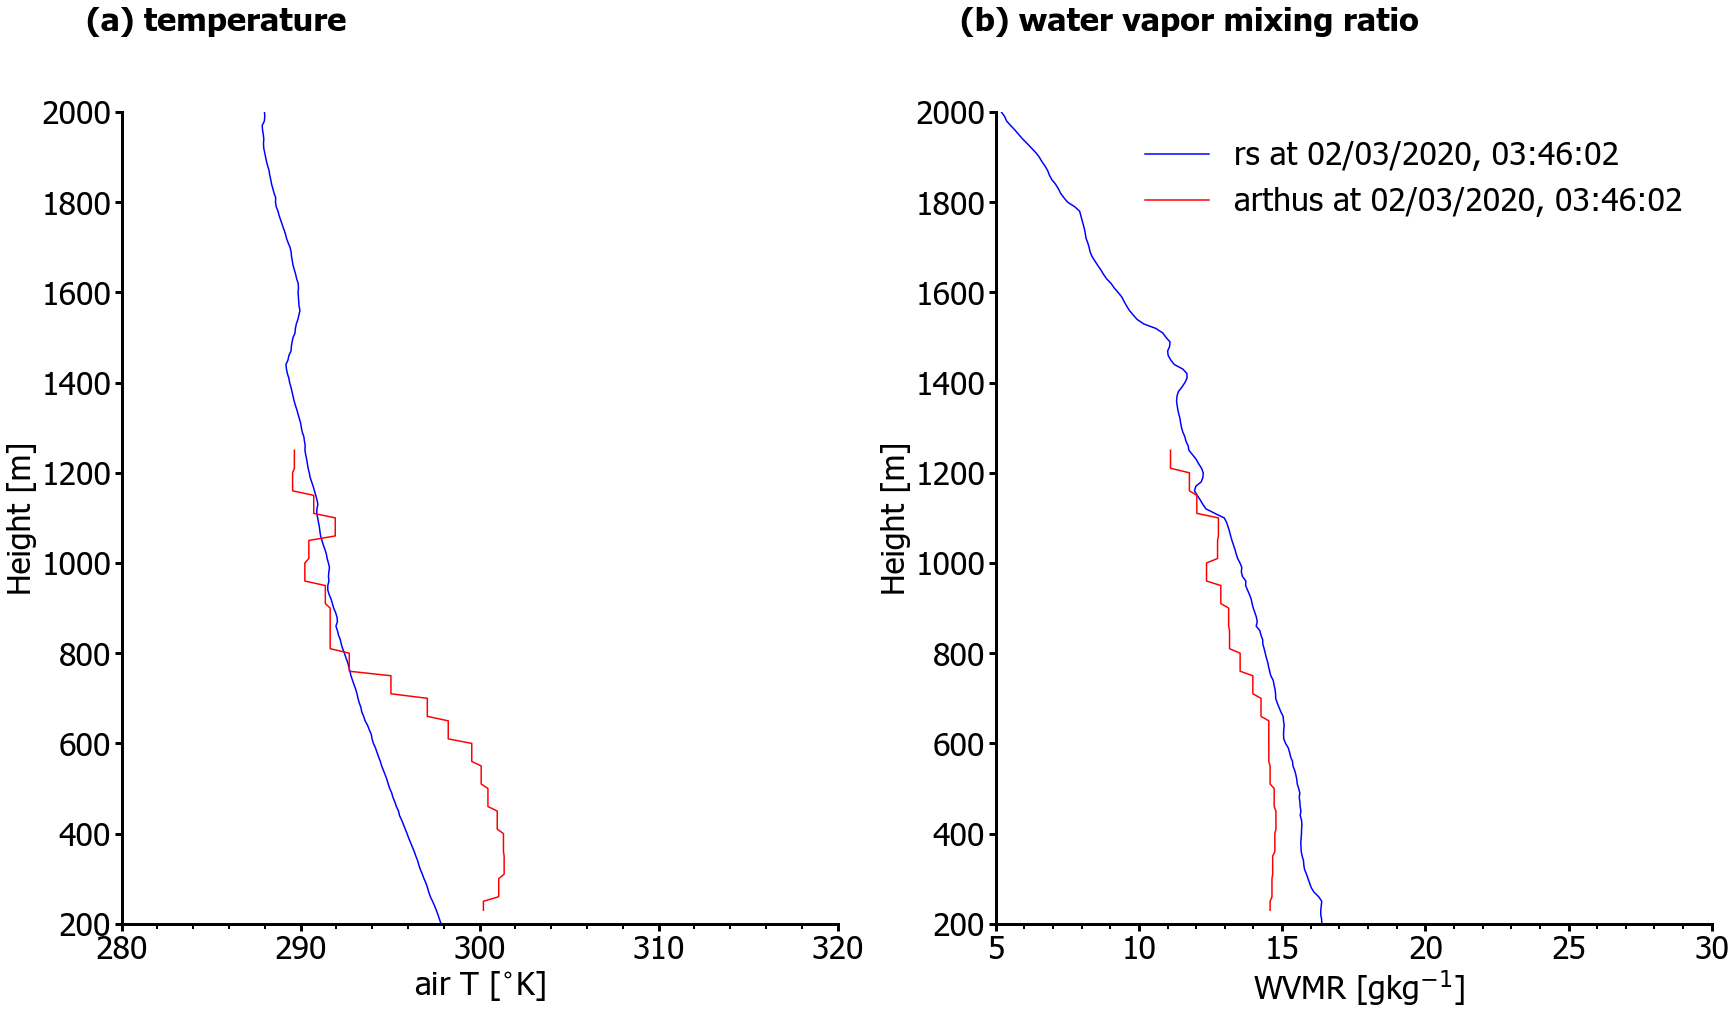

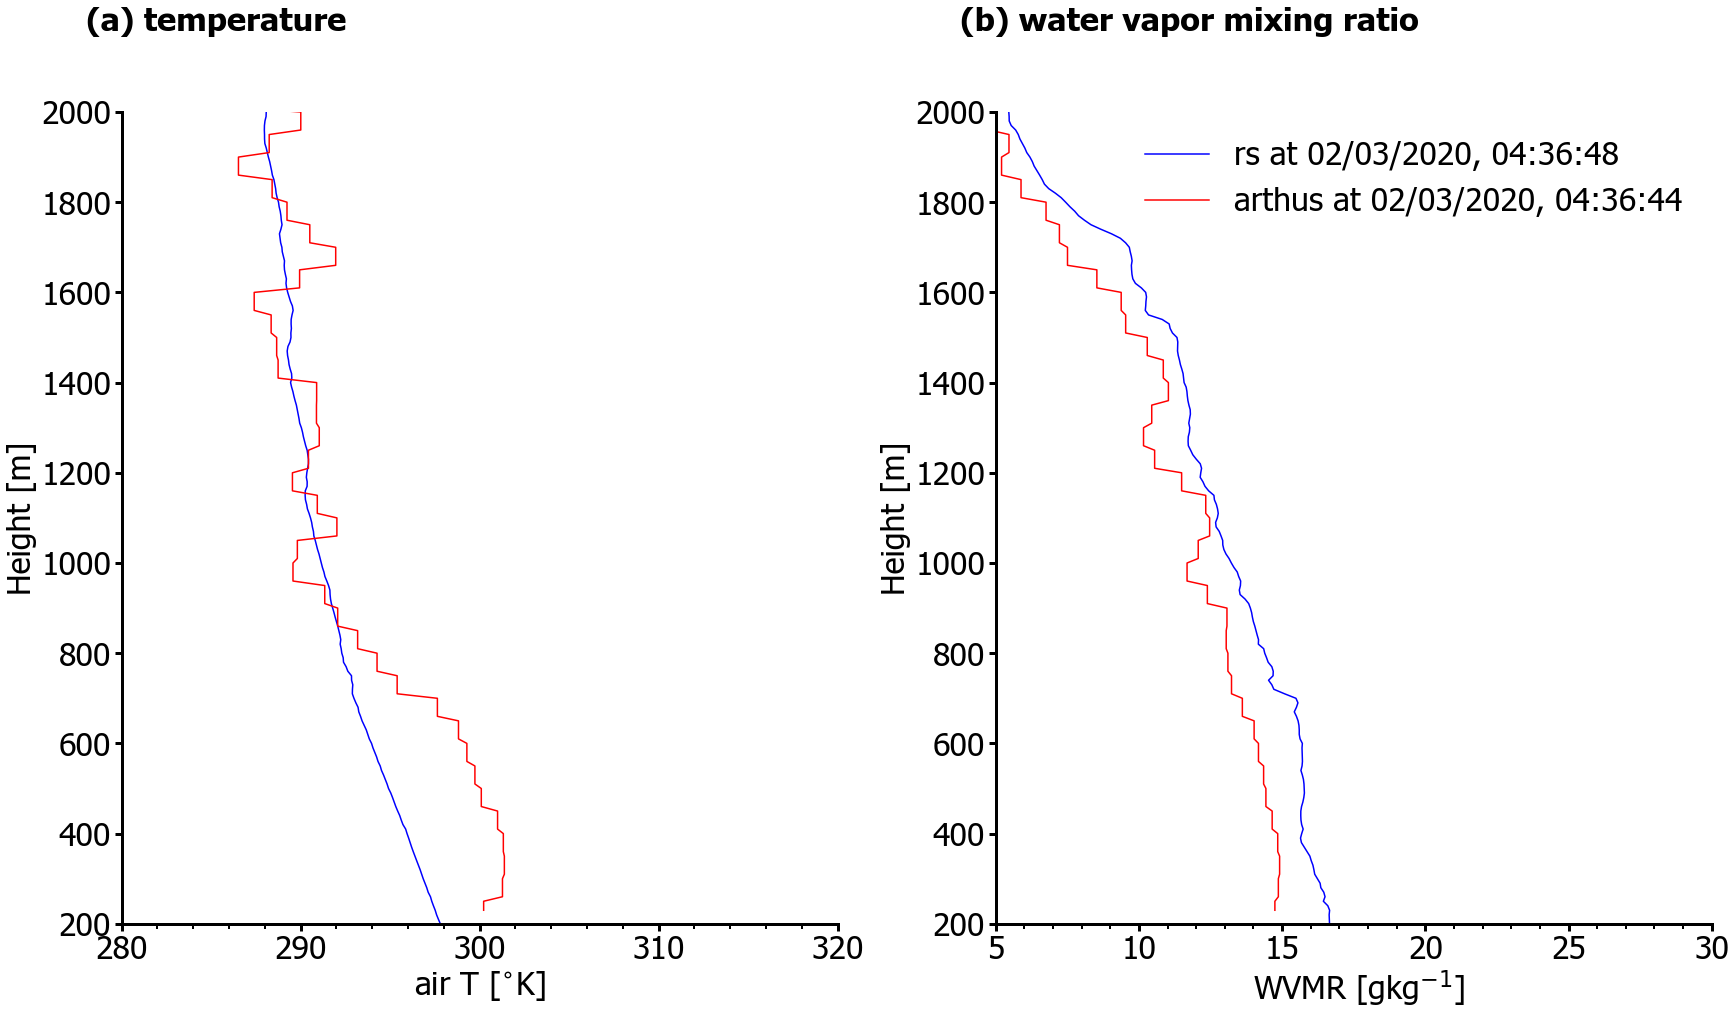

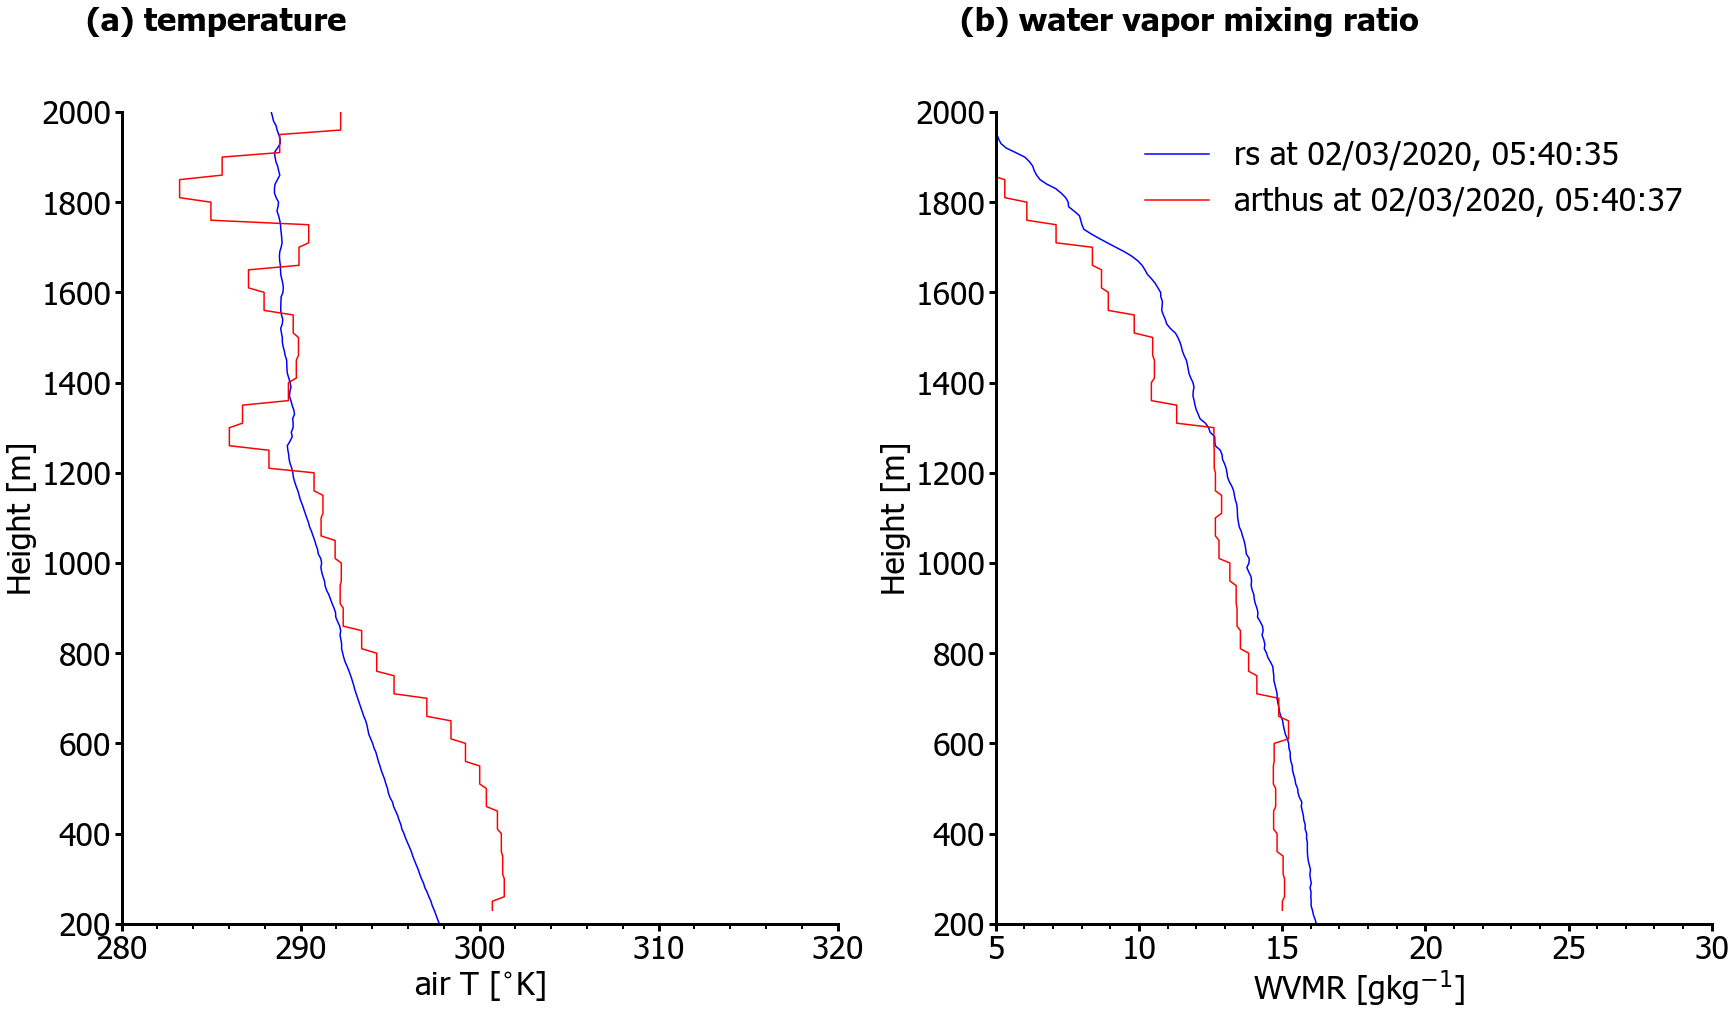

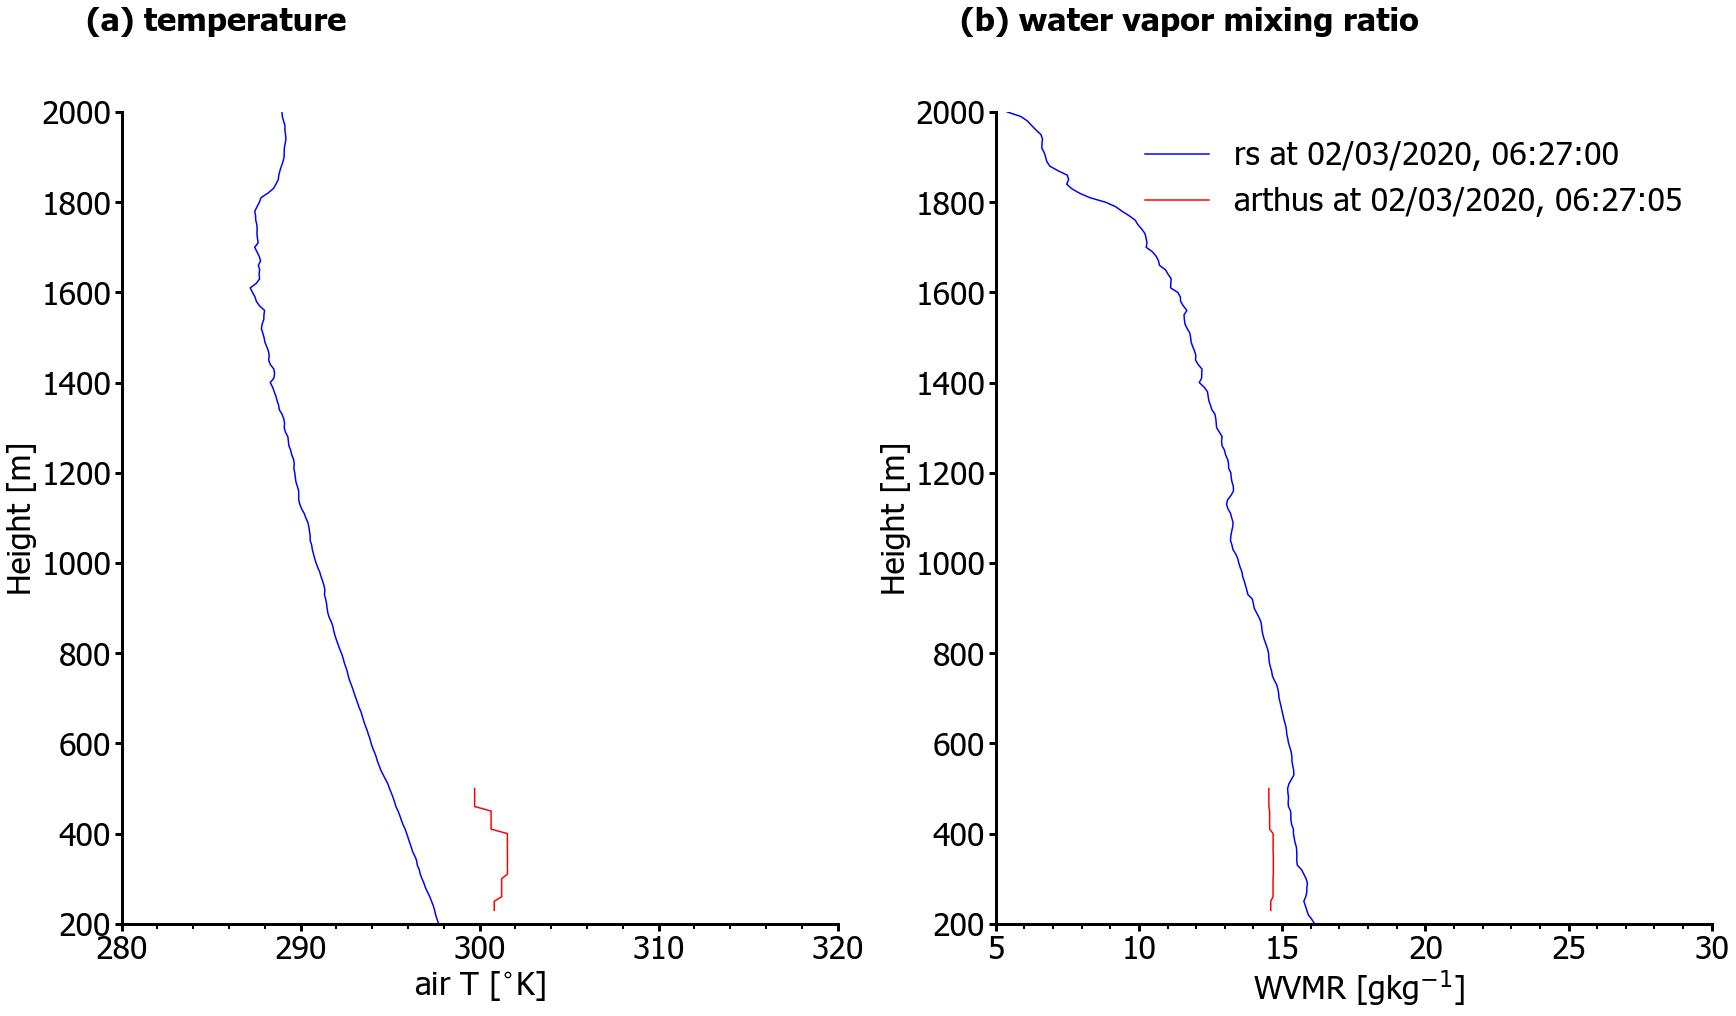

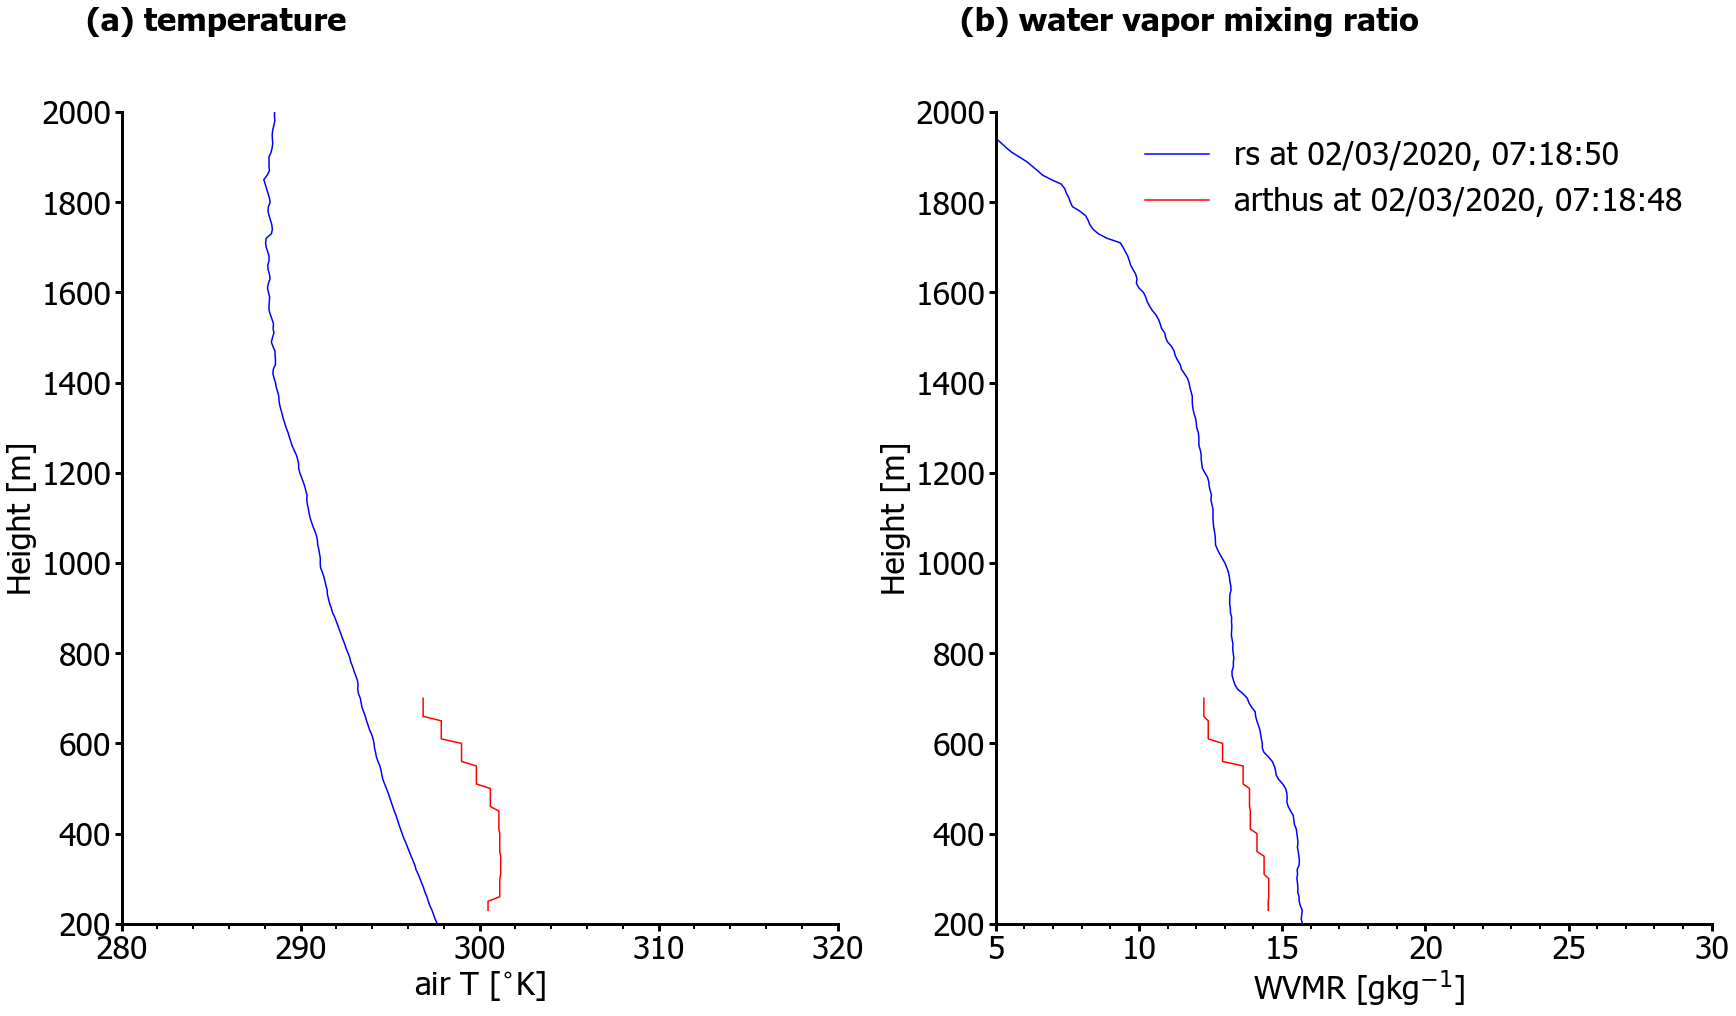

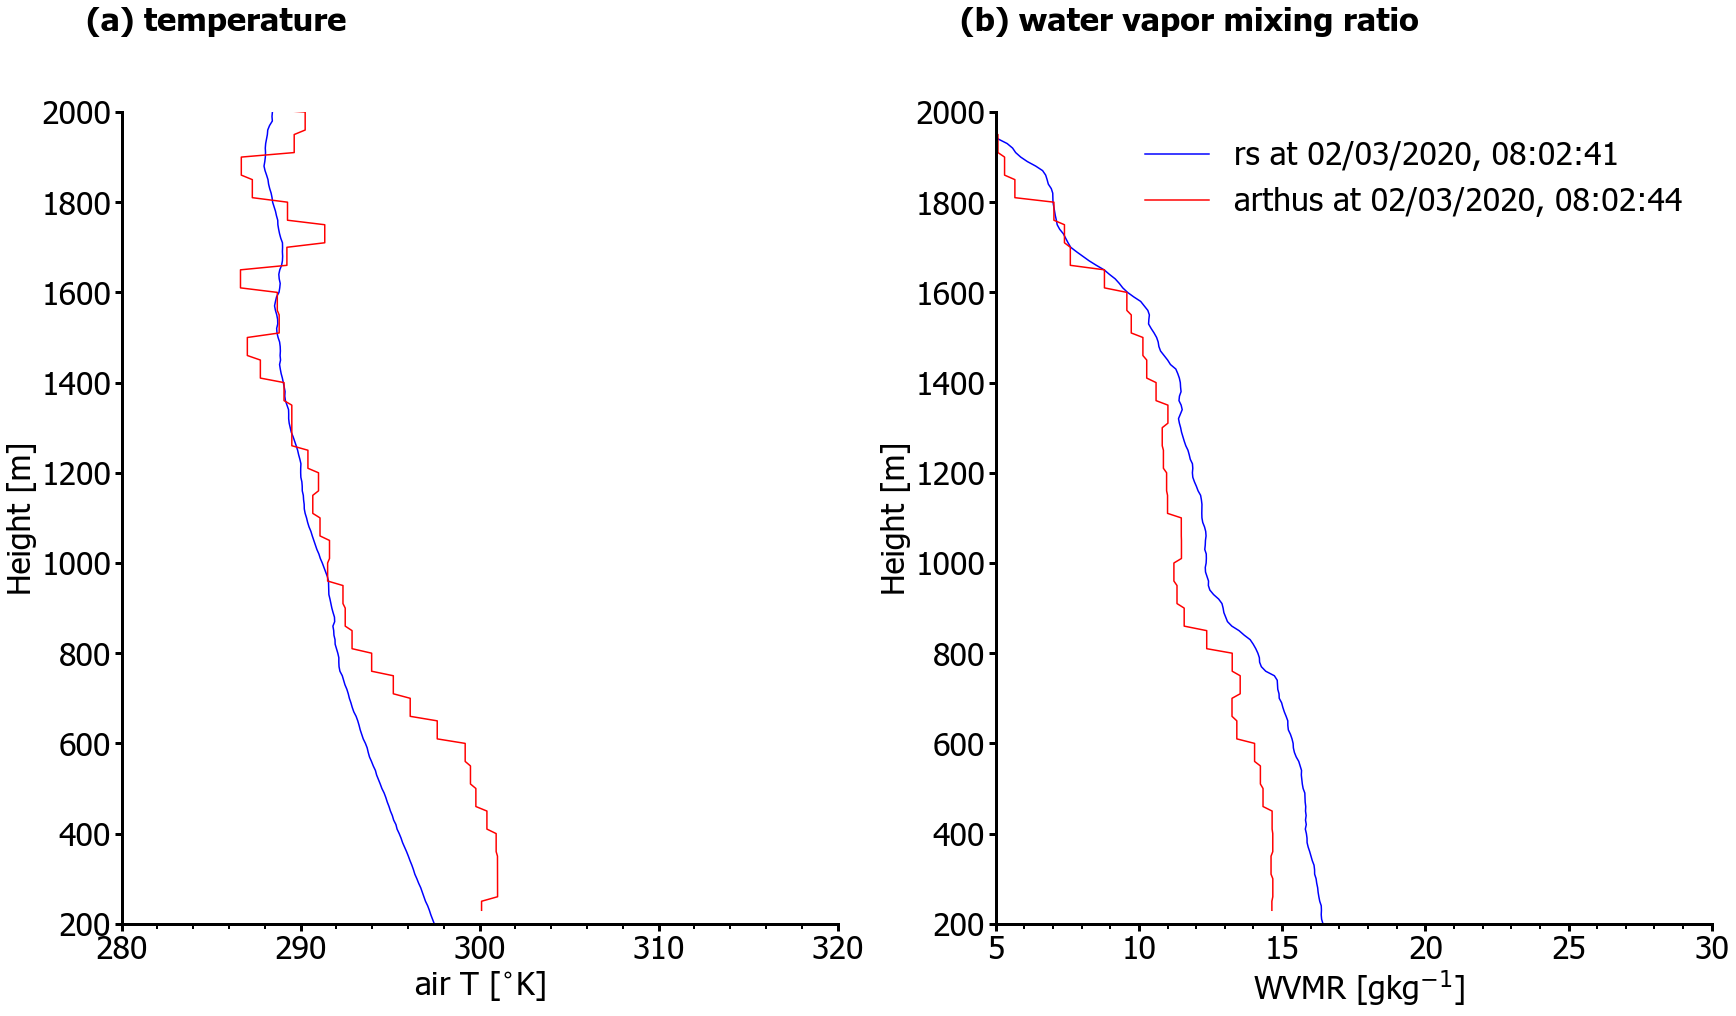

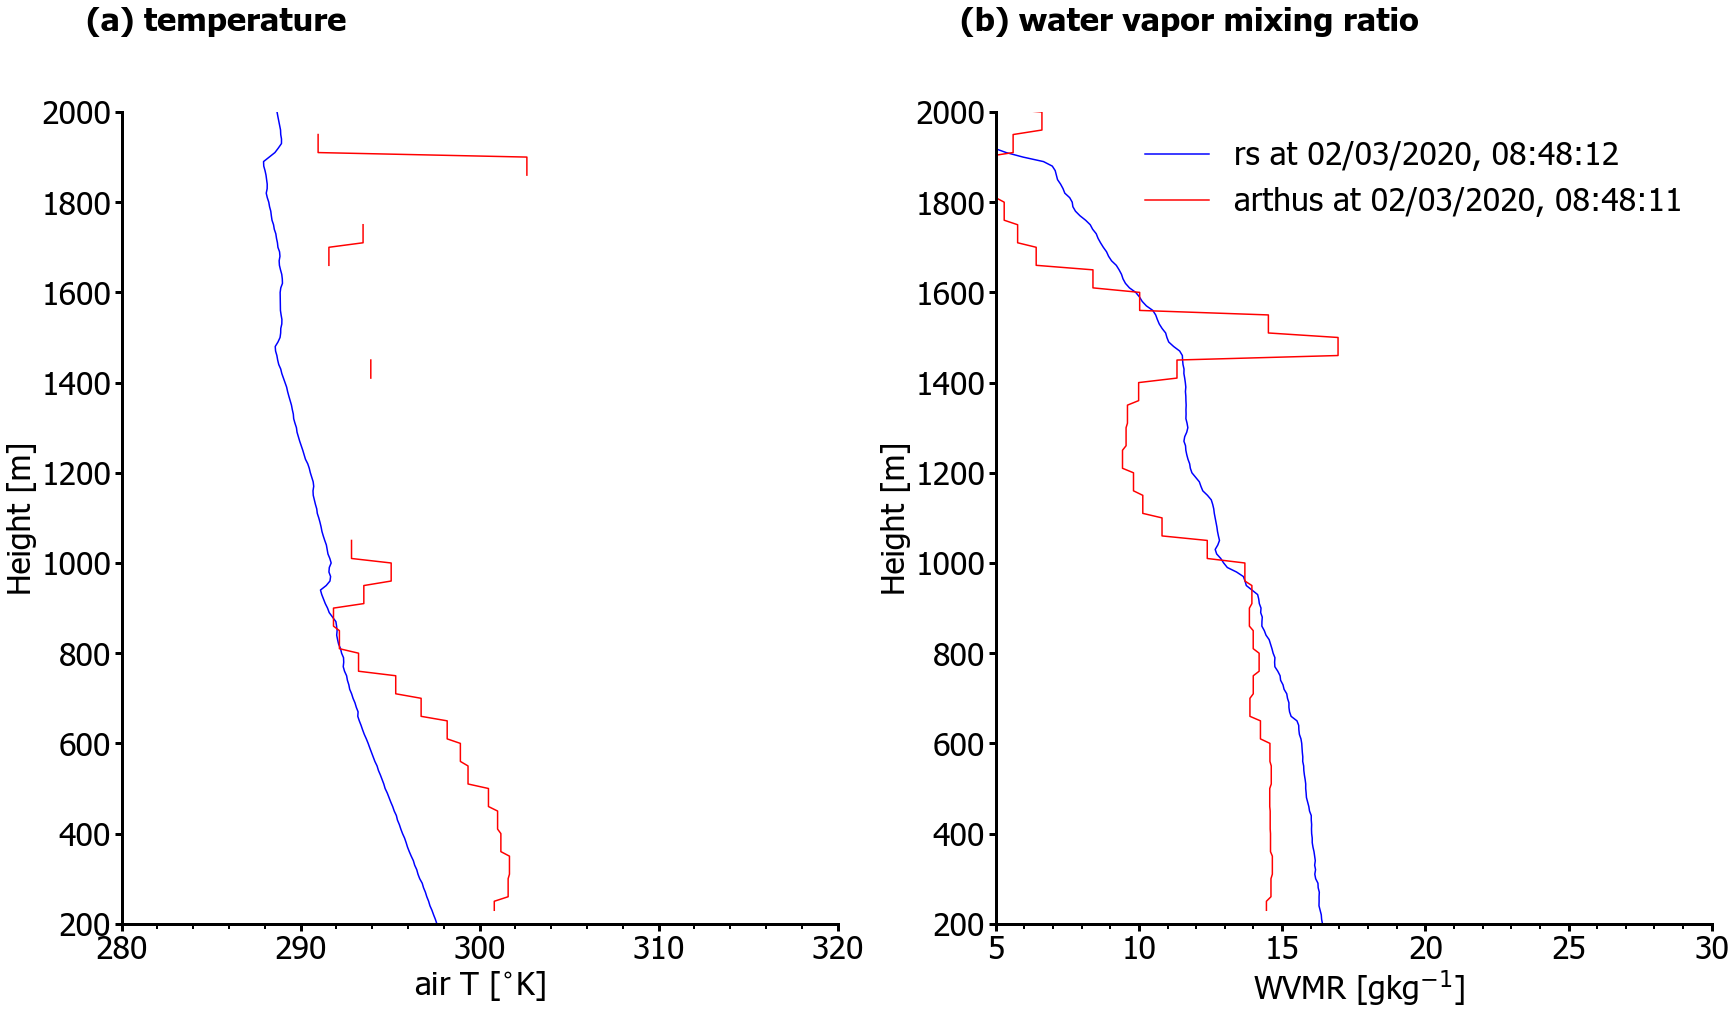

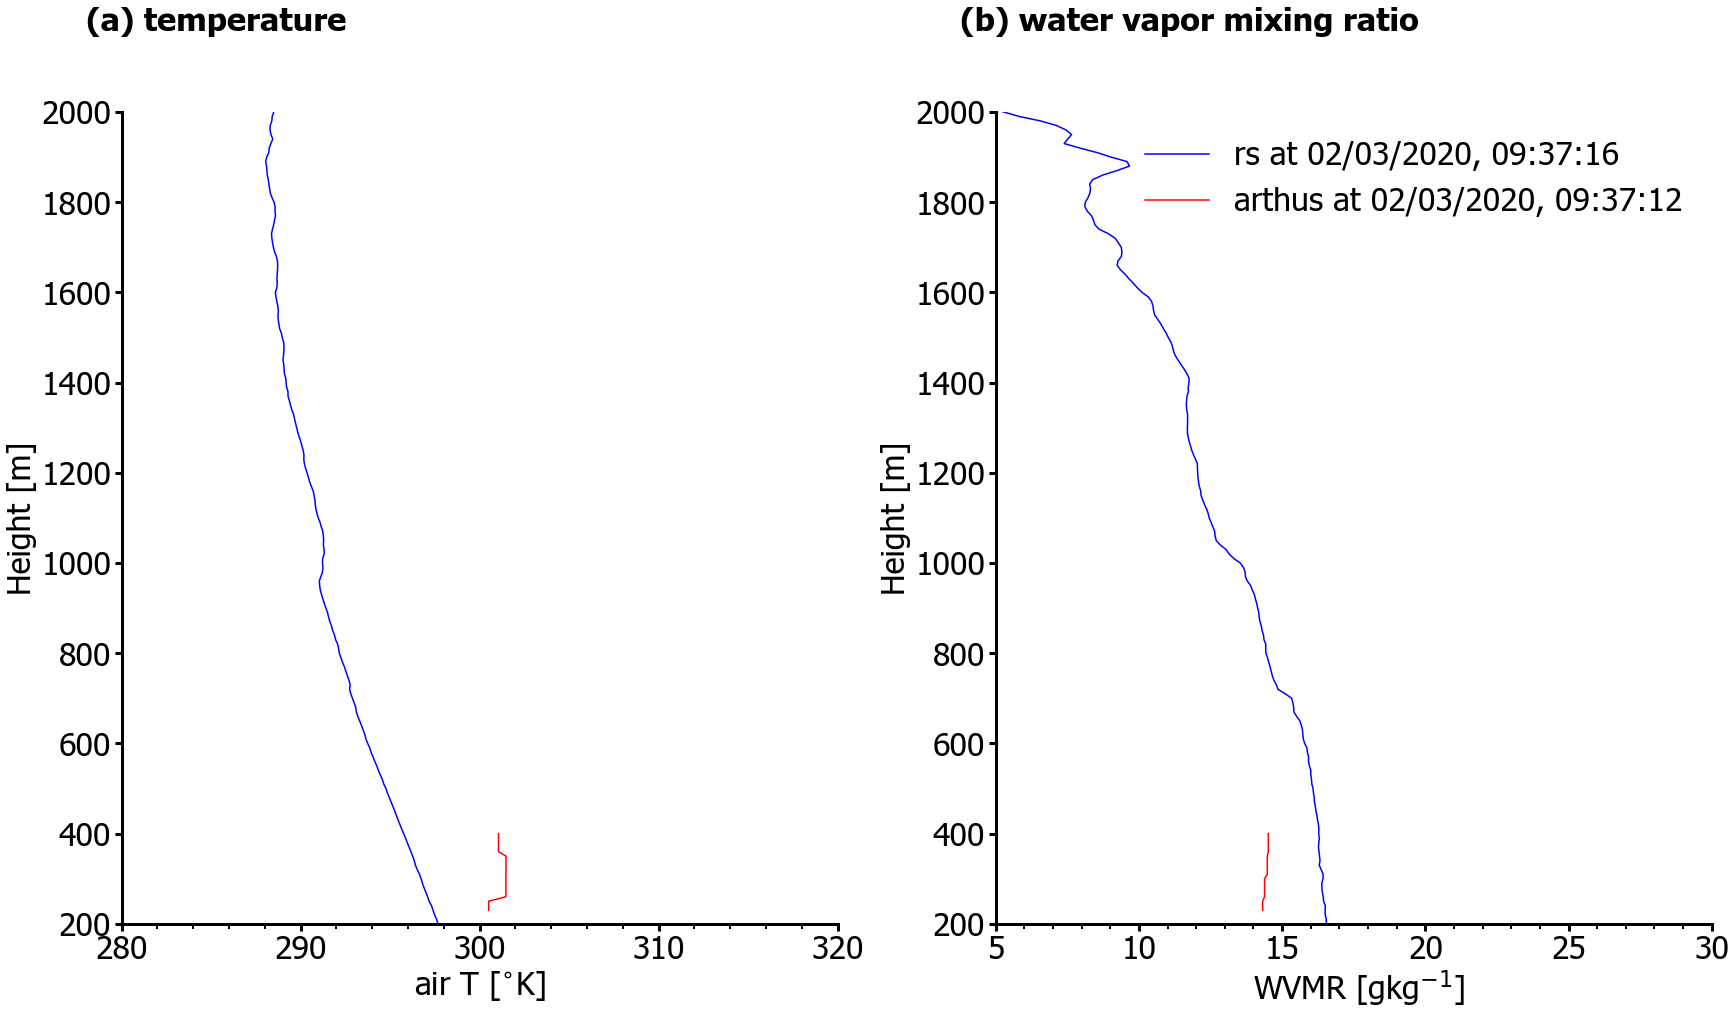

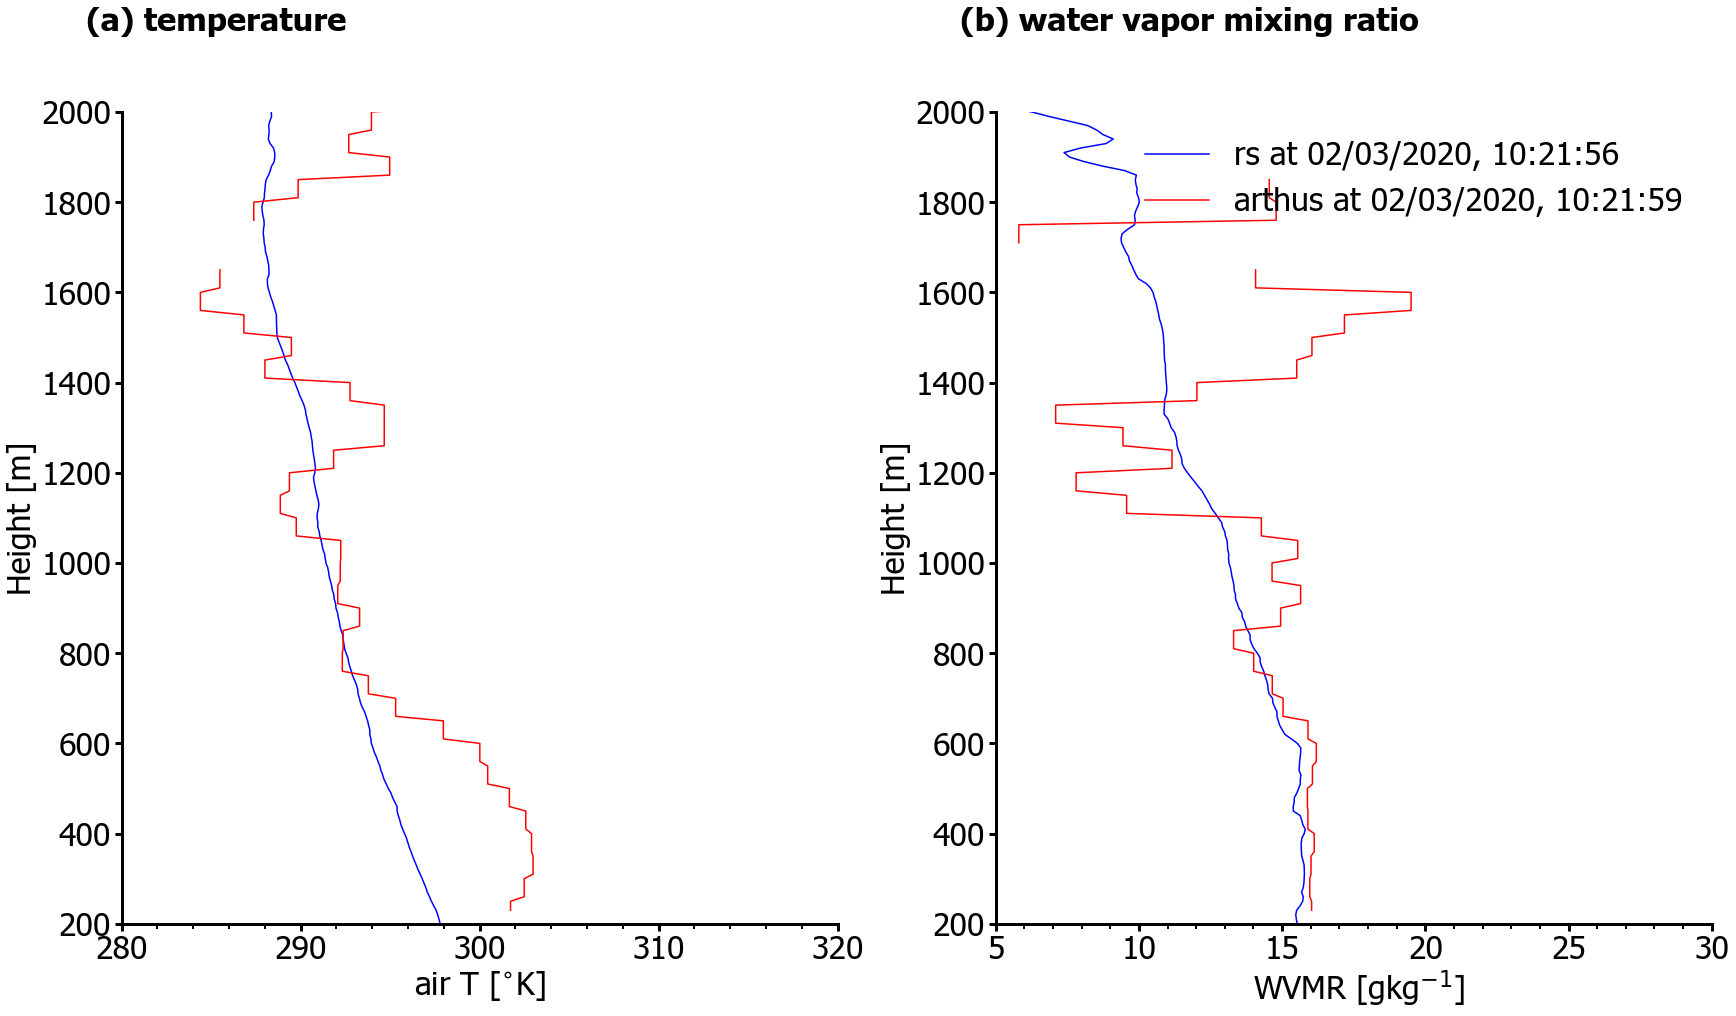

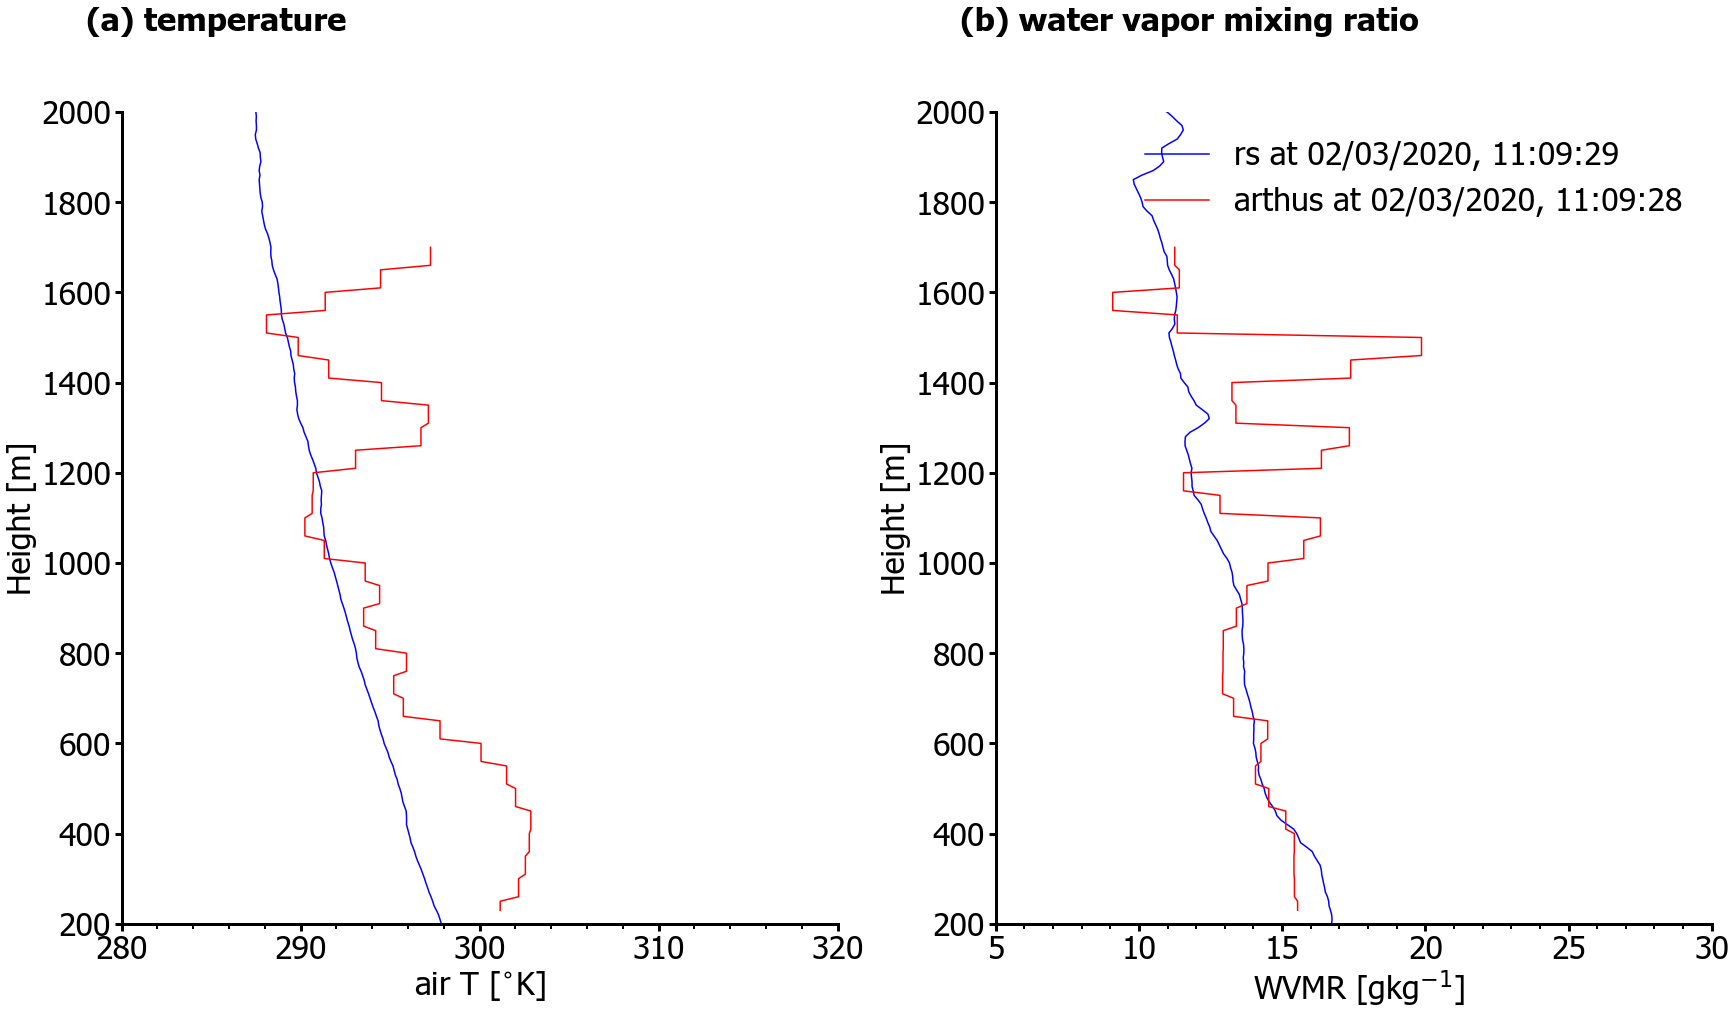

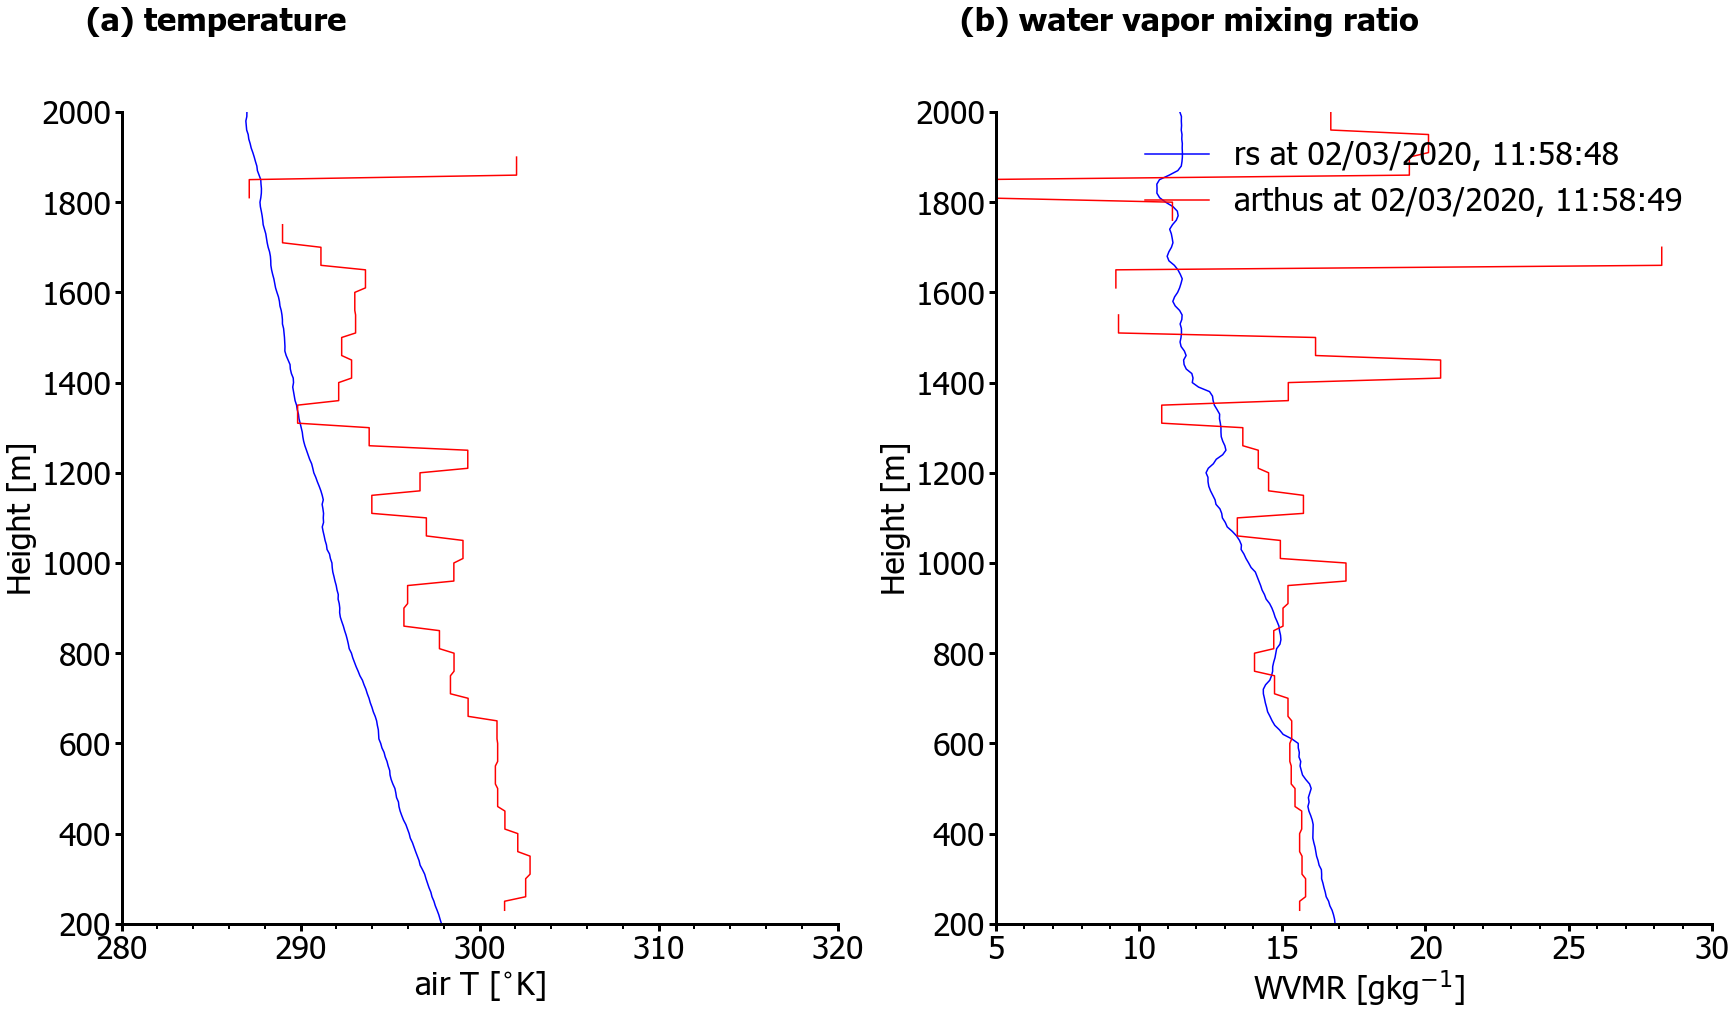

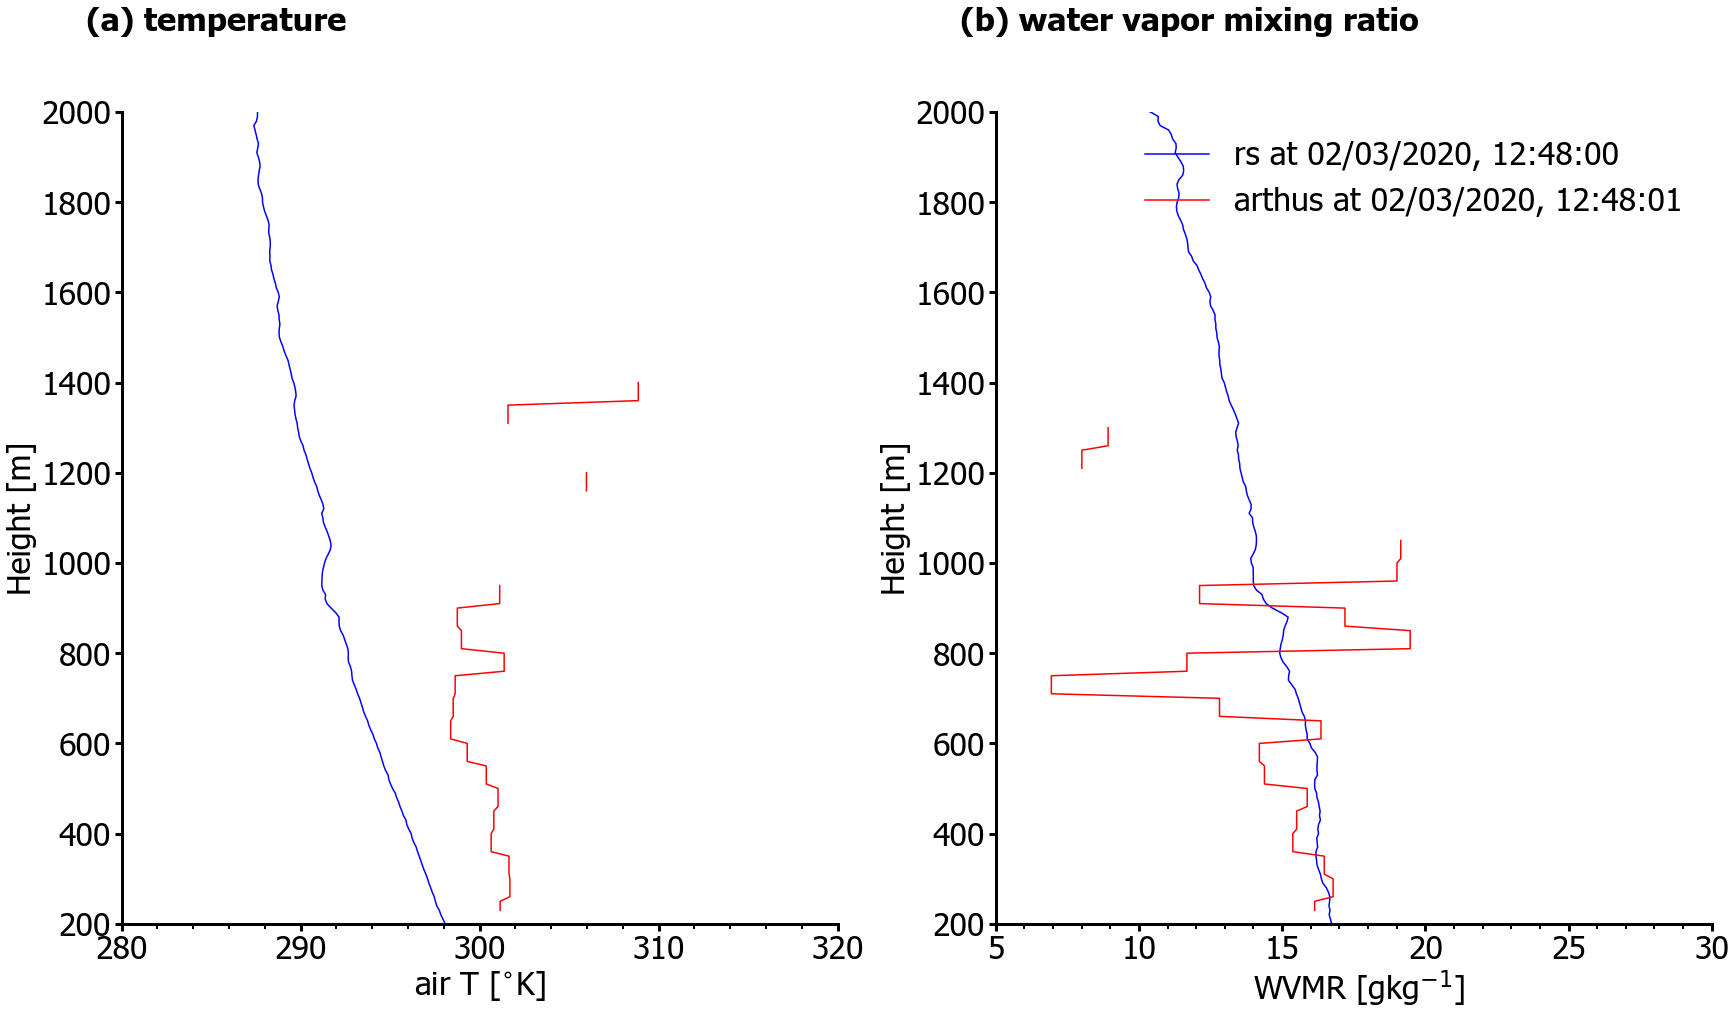

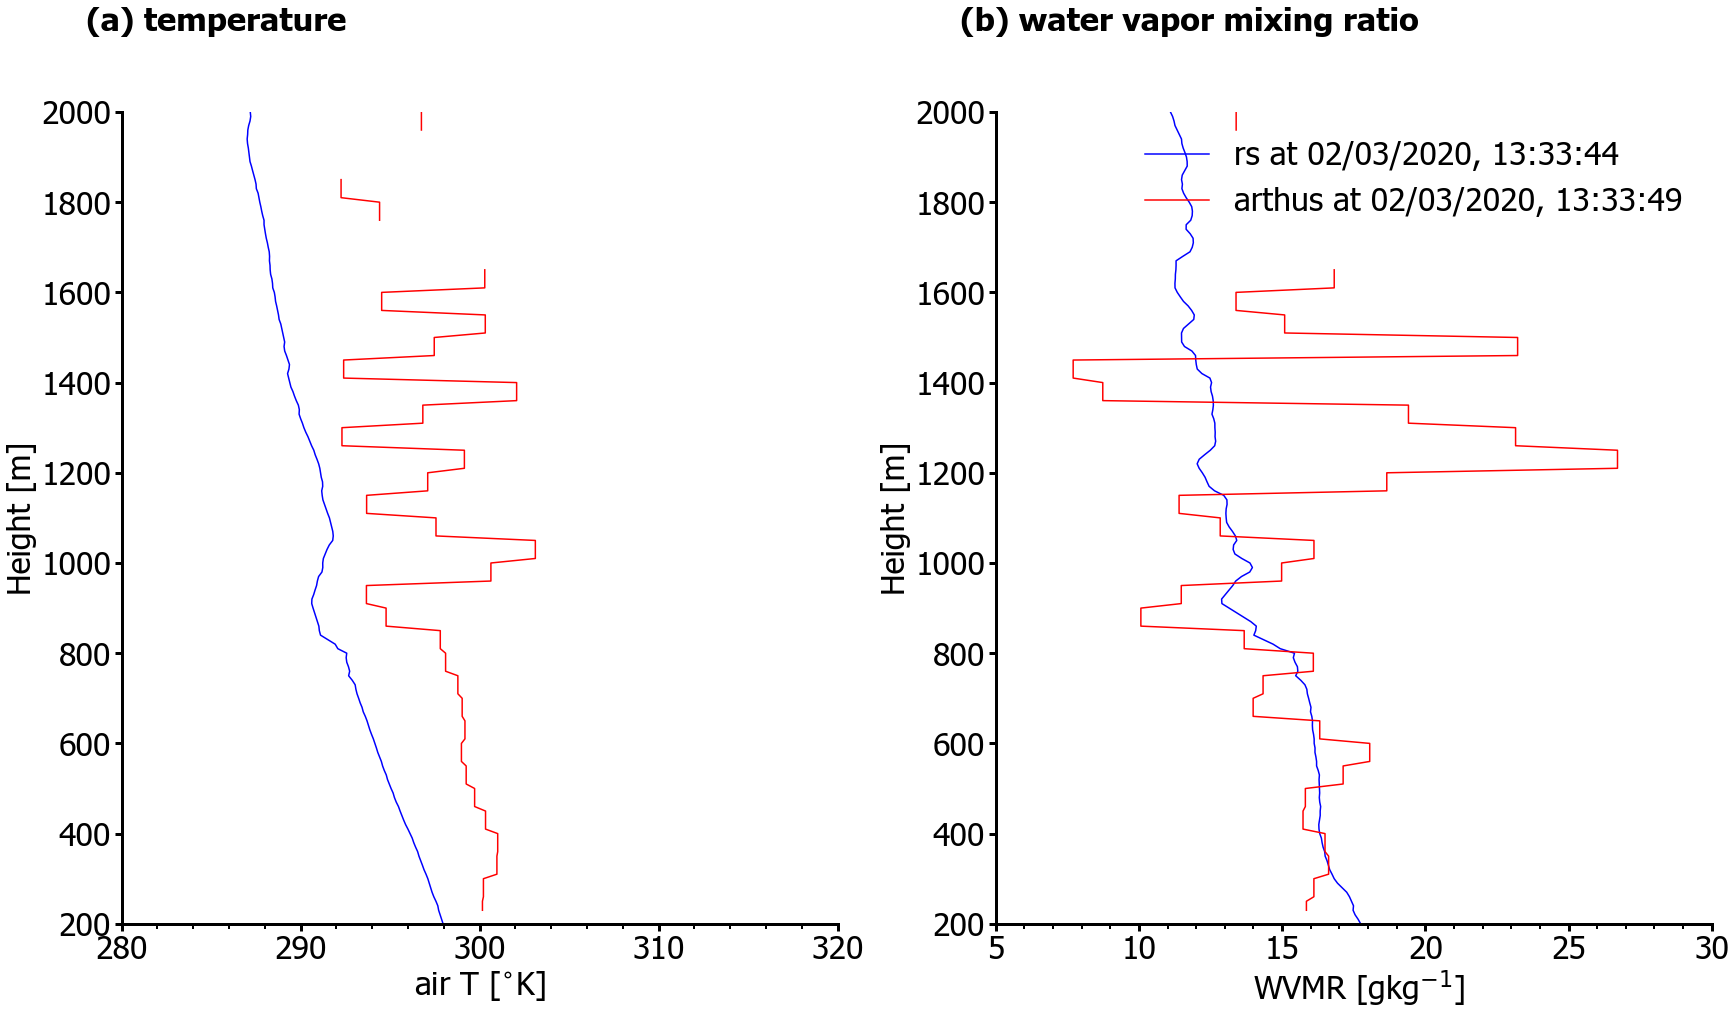

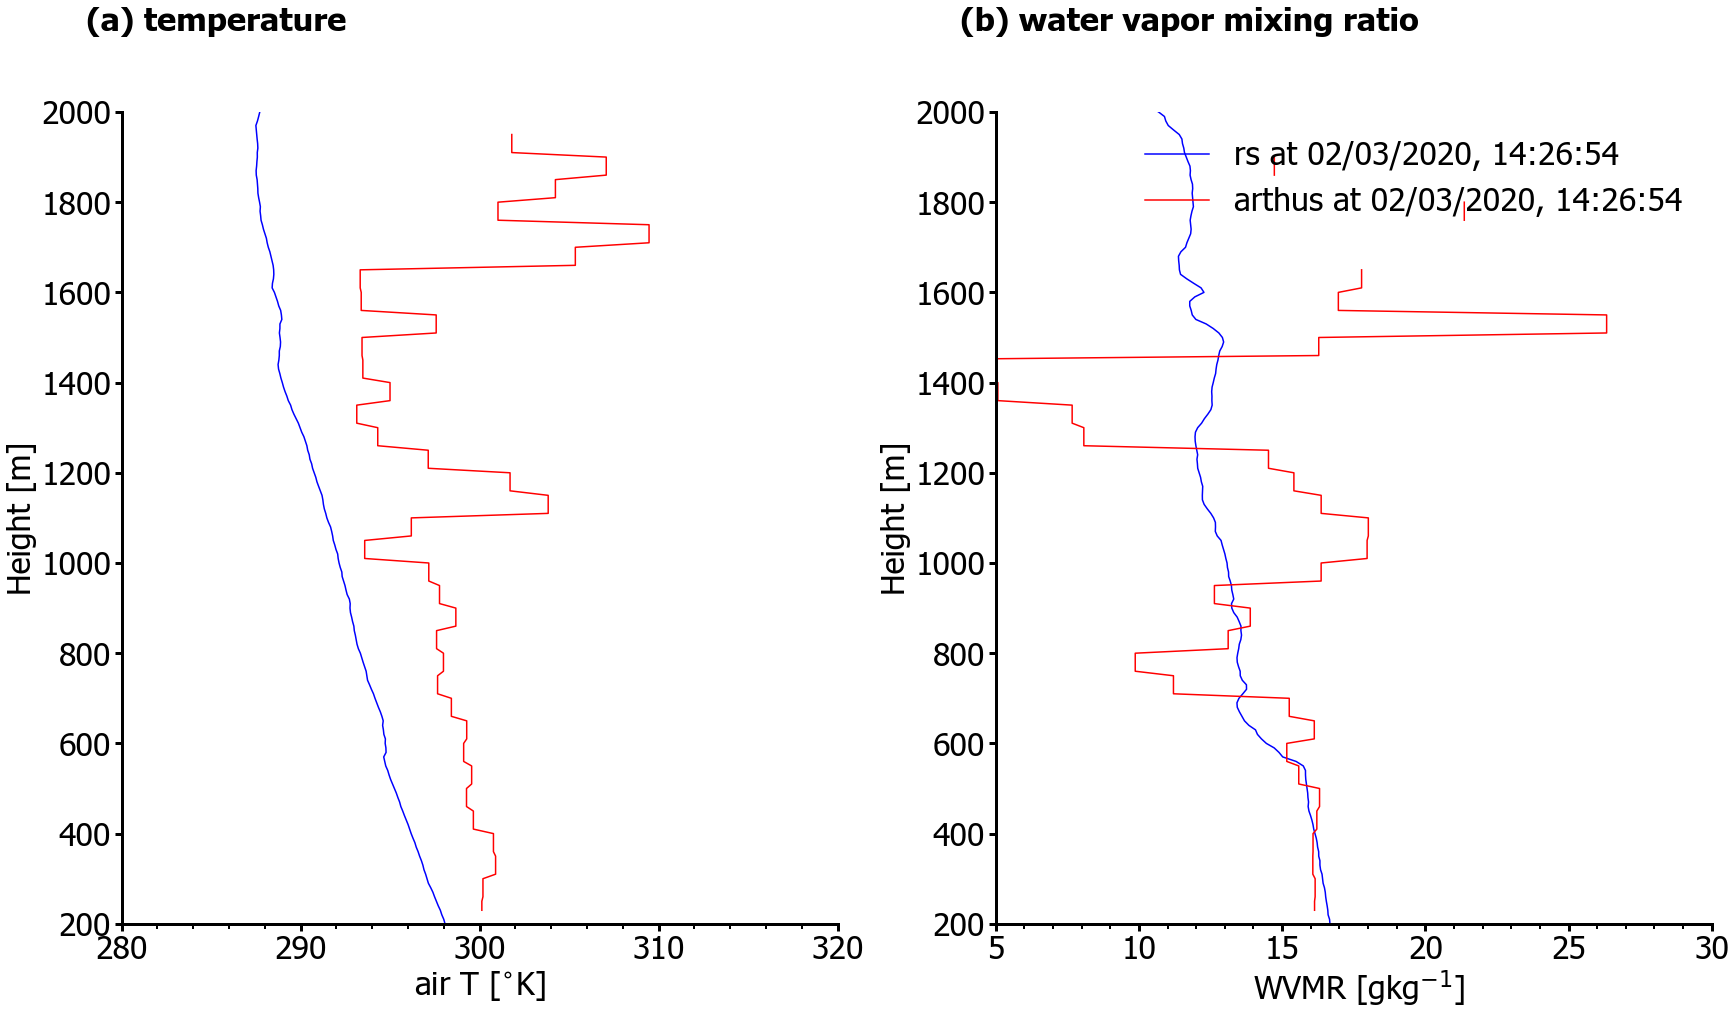

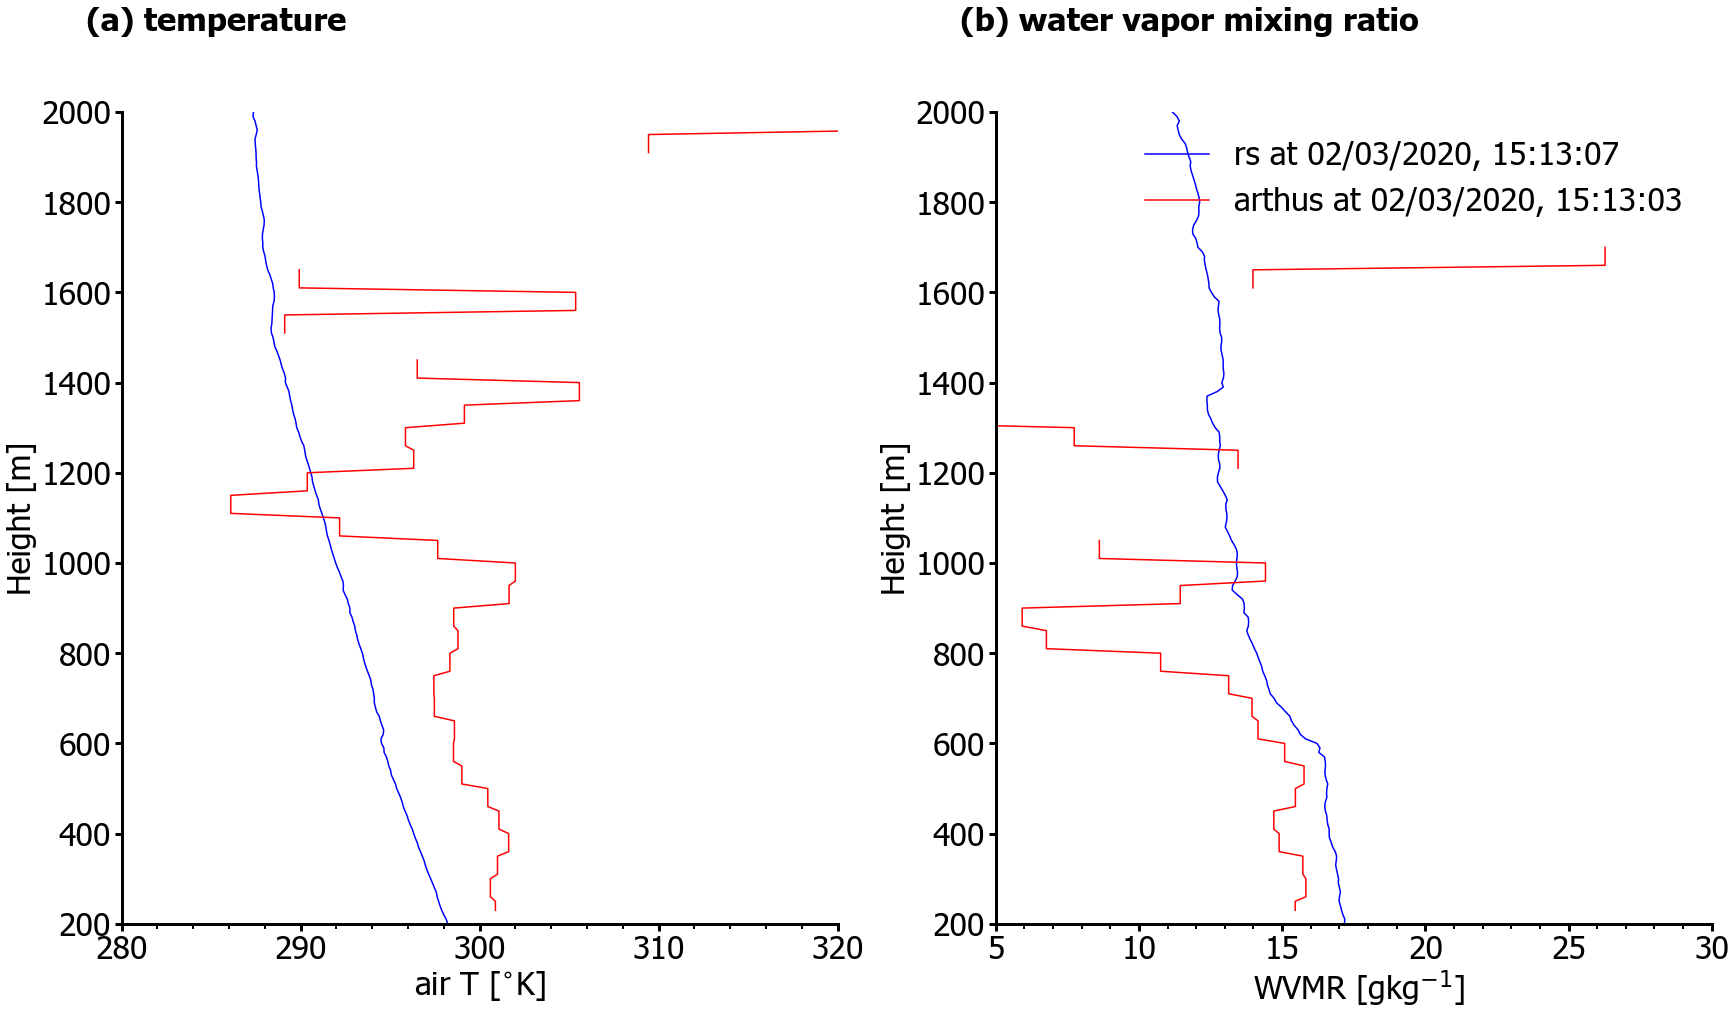

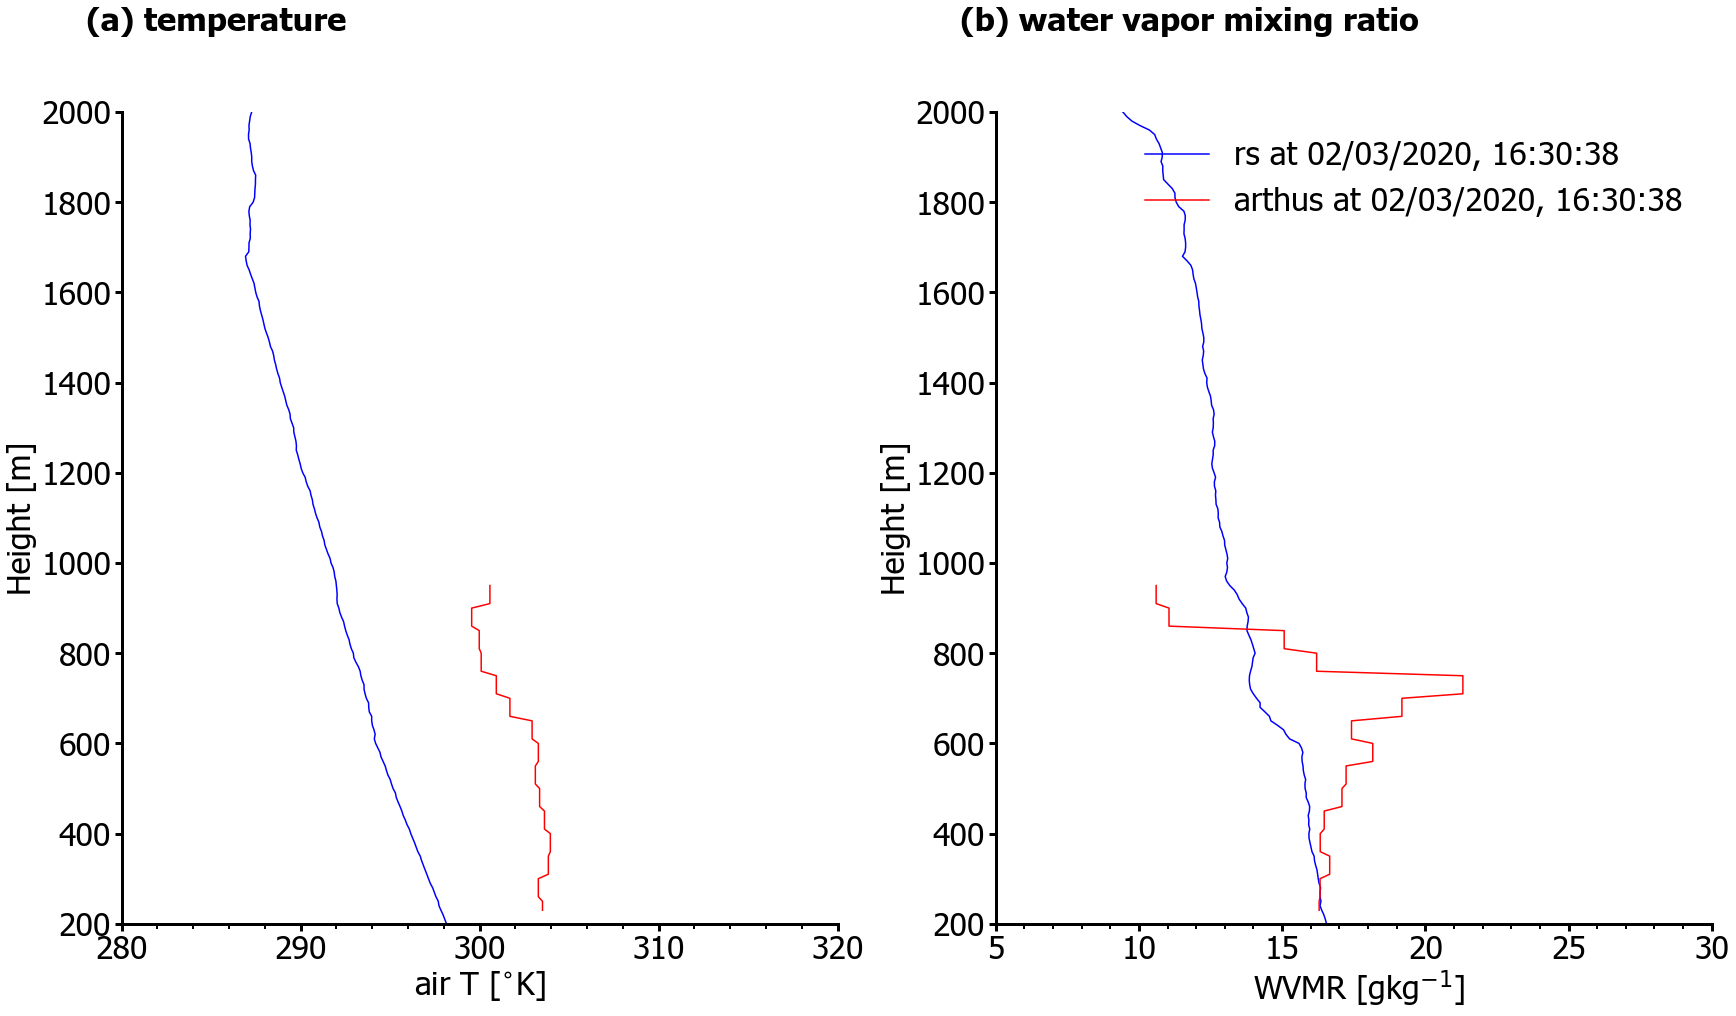

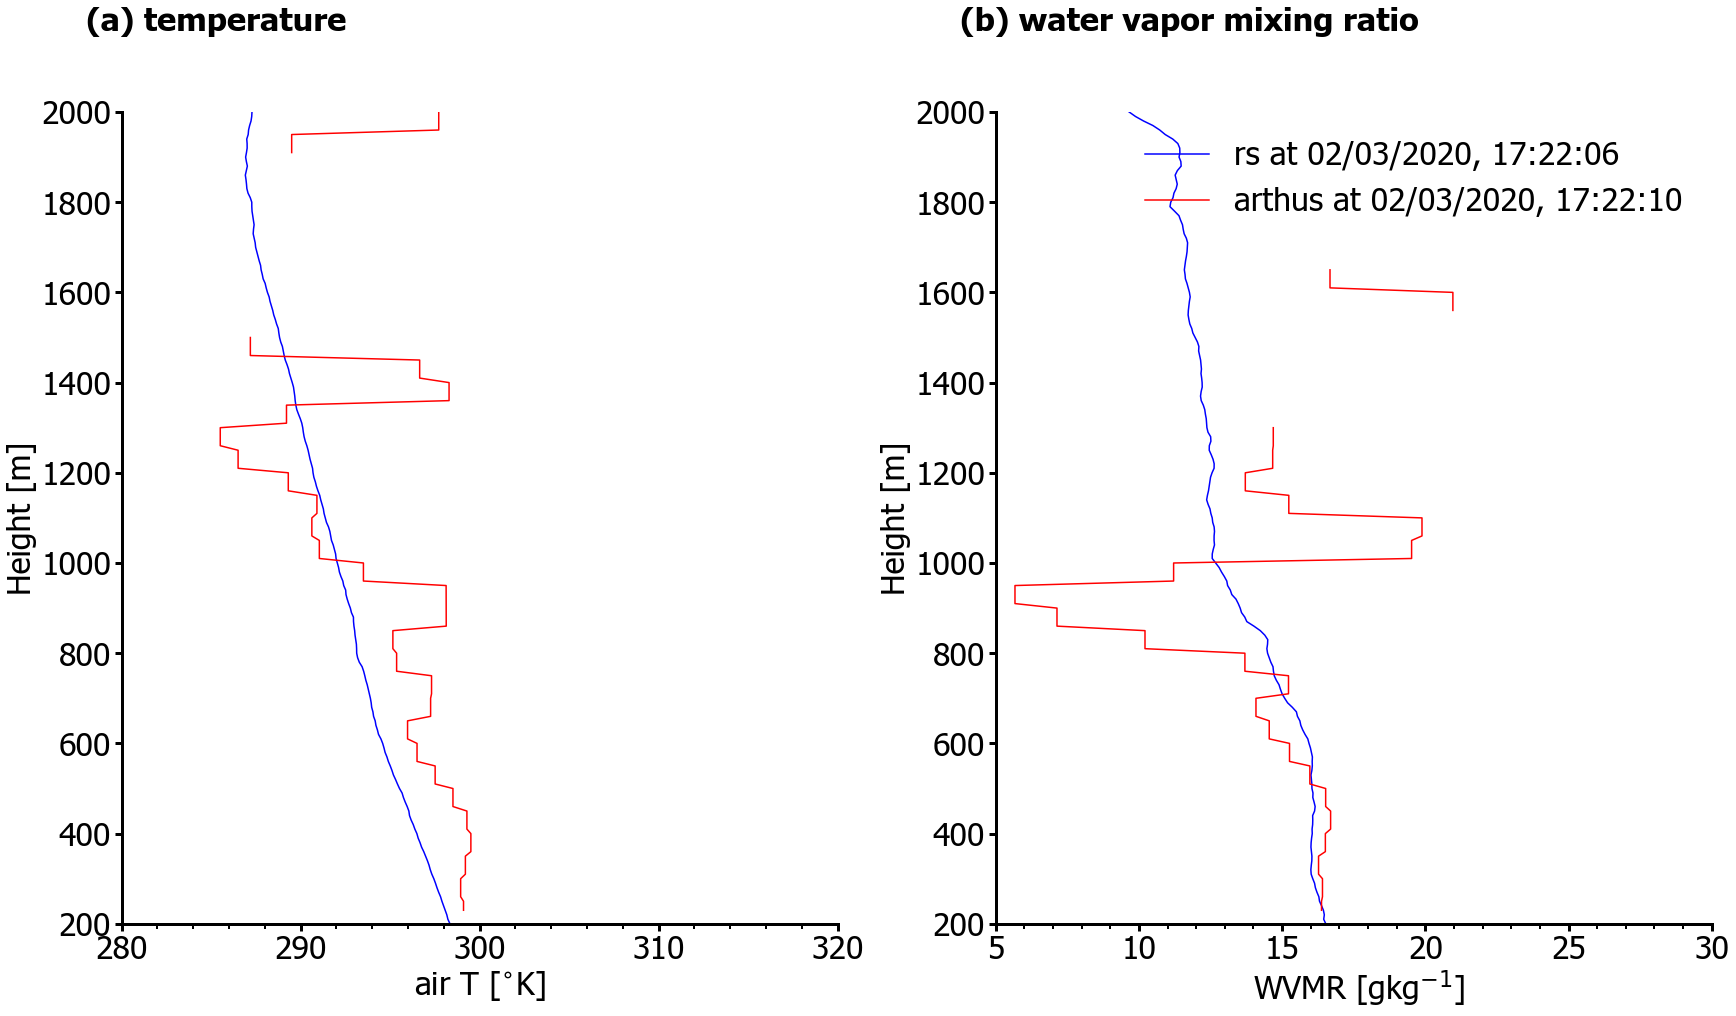

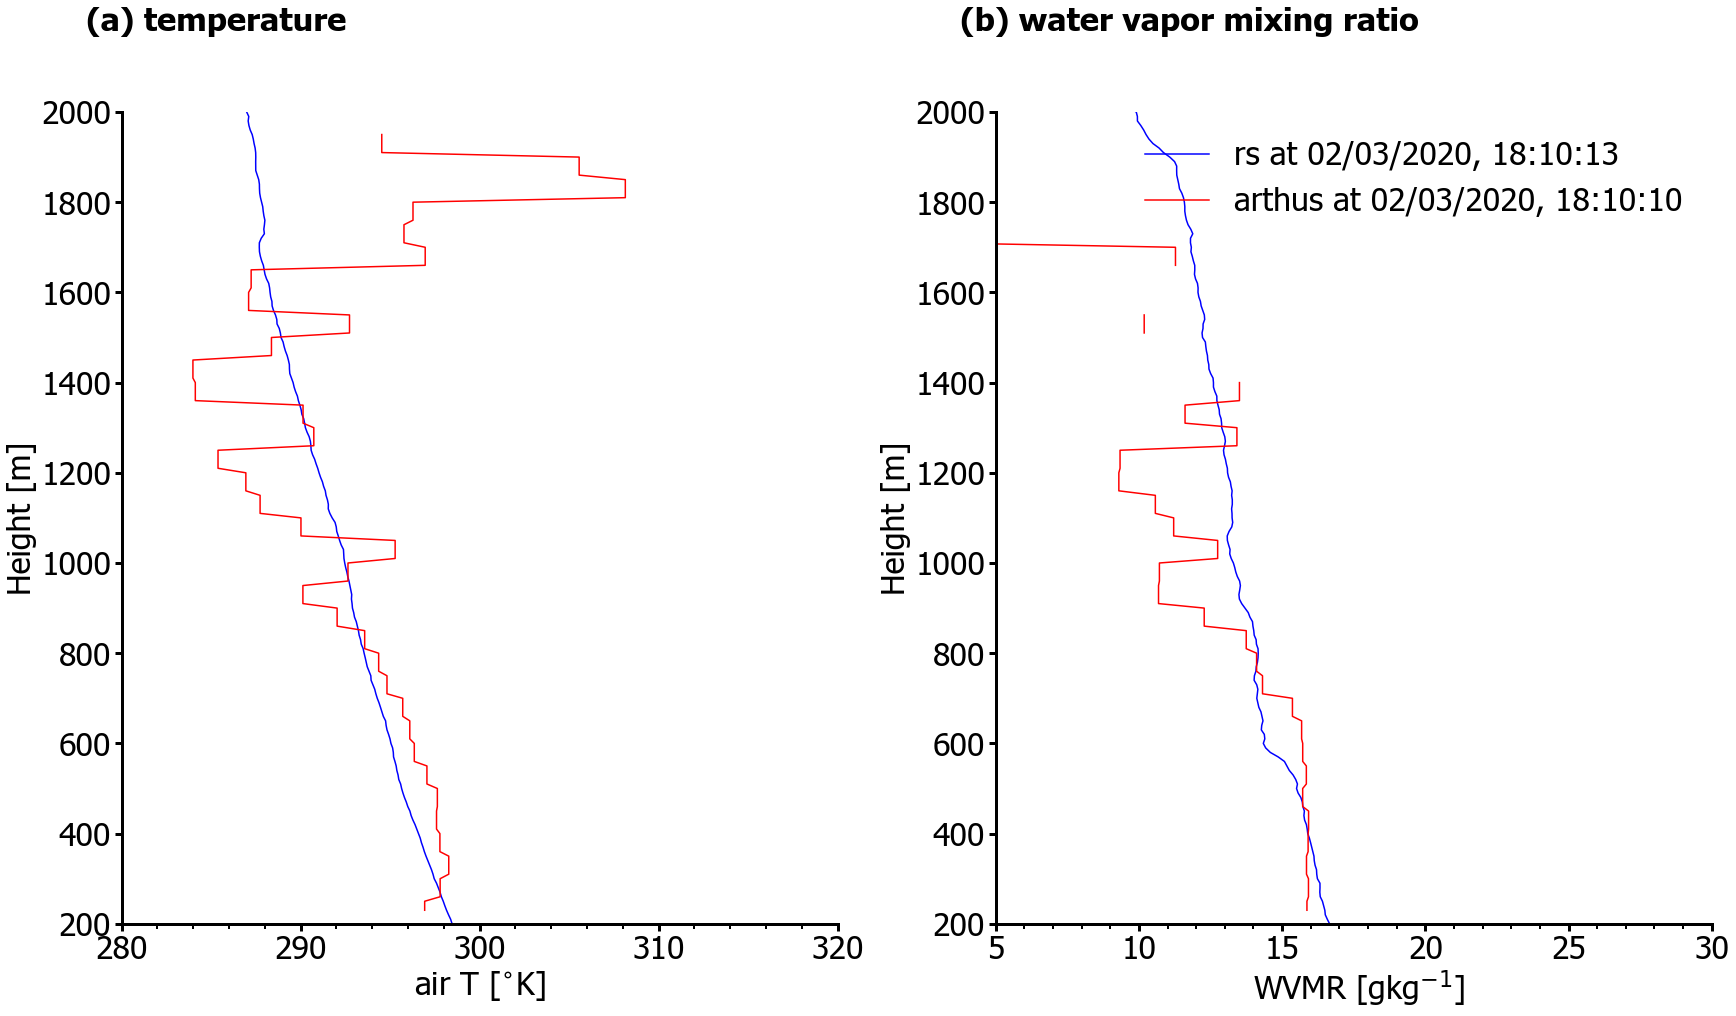

In [8]:
# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/RS_arthus_comparison/'


for ind_time in range(len(vaisala_rs.launch_time.values)):
    
    
    fig, axs = plt.subplots(1,2, figsize=(24,14), constrained_layout=True)

    time_rs = pd.to_datetime(vaisala_rs.launch_time.values[ind_time]).strftime("%m/%d/%Y, %H:%M:%S")
    time_arthus = pd.to_datetime(T_arthus_vaisala.time.values[ind_time]).strftime("%m/%d/%Y, %H:%M:%S")
    print(time_rs, time_arthus)
    axs[0].plot(vaisala_rs.ta.values[ind_time,:],vaisala_rs.alt.values, color='blue', label='rs at '+time_rs)
    axs[0].plot(T_arthus_vaisala.values[ind_time,:], T_arthus_vaisala.height.values, color='red', label='arthus at '+time_arthus)
    axs[0].set_xlim(280.,320.)
    axs[0].set_xlabel('air T [$^{\circ}$K]', fontsize=fontSizeX)

    
    axs[1].plot(vaisala_rs.mr.values[ind_time,:]*1000.,vaisala_rs.alt.values, color='blue', label='rs at '+time_rs)
    axs[1].plot(WVMR_arthus_vaisala.values[ind_time,:], WVMR_arthus_vaisala.height.values, color='red', label='arthus at '+time_arthus)
    axs[1].set_xlim(5.,30.)
    axs[1].set_xlabel(' WVMR [gkg$^{-1}$]', fontsize=fontSizeX)
    axs[1].legend(frameon=False)
    for ax, l in zip(axs[:].flatten(), ['(a) temperature ',  '(b) water vapor mixing ratio ']):
        ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
        #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_linewidth(3)
        ax.spines["left"].set_linewidth(3)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
        ax.tick_params(which='minor', length=5, width=2)
        ax.tick_params(which='major', length=7, width=3)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
        ax.tick_params(axis='both', labelsize=32)
        ax.set_ylabel('Height [m]', fontsize=fontSizeX)
        ax.set_ylim(200.,2000.)
    fig.savefig(path_out_plots+str(ind_time)+'_vaisala_T_wvmr.png', format='png')

for ind_time in range(len(meteomodem_rs.launch_time.values)):
    
    
    fig, axs = plt.subplots(1,2, figsize=(24,14), constrained_layout=True)

    time_rs = pd.to_datetime(meteomodem_rs.launch_time.values[ind_time]).strftime("%m/%d/%Y, %H:%M:%S")
    time_arthus = pd.to_datetime(T_arthus_mm.time.values[ind_time]).strftime("%m/%d/%Y, %H:%M:%S")
    print(time_rs, time_arthus)
    axs[0].plot(meteomodem_rs.ta.values[ind_time,:],meteomodem_rs.alt.values, color='blue', label='rs at '+time_rs)
    axs[0].plot(T_arthus_mm.values[ind_time,:], T_arthus_mm.height.values, color='red', label='arthus at '+time_arthus)
    axs[0].set_xlim(280.,320.)
    axs[0].set_xlabel('air T [$^{\circ}$K]', fontsize=fontSizeX)

    
    axs[1].plot(meteomodem_rs.mr.values[ind_time,:]*1000.,meteomodem_rs.alt.values, color='blue', label='rs at '+time_rs)
    axs[1].plot(WVMR_arthus_mm.values[ind_time,:], WVMR_arthus_mm.height.values, color='red', label='arthus at '+time_arthus)
    axs[1].set_xlim(5.,30.)
    axs[1].set_xlabel(' WVMR [gkg$^{-1}$]', fontsize=fontSizeX)
    axs[1].legend(frameon=False)
    for ax, l in zip(axs[:].flatten(), ['(a) temperature ',  '(b) water vapor mixing ratio ']):
        ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
        #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_linewidth(3)
        ax.spines["left"].set_linewidth(3)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
        ax.tick_params(which='minor', length=5, width=2)
        ax.tick_params(which='major', length=7, width=3)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
        ax.tick_params(axis='both', labelsize=32)
        ax.set_ylabel('Height [m]', fontsize=fontSizeX)
        ax.set_ylim(200.,2000.)
    fig.savefig(path_out_plots+str(ind_time)+'_meteomodem_T_wvmr.png', format='png')



In [33]:
# calculate mean and std of the difference between RS and arthus
diff_T_va = vaisala_rs.ta.values - T_arthus_vaisala.values
diff_T_mean_va = np.nanmean(diff_T_va, axis=0)
diff_T_std_va = np.nanstd(diff_T_va, axis=0)

diff_WVMR_va = vaisala_rs.mr.values*1000. - WVMR_arthus_vaisala.values
diff_WVMR_mean_va = np.nanmean(diff_WVMR_va, axis=0)
diff_WVMR_std_va = np.nanstd(diff_WVMR_va, axis=0)



diff_T_mm = meteomodem_rs.ta.values - T_arthus_mm.values
diff_T_mean_mm = np.nanmean(diff_T_mm, axis=0)
diff_T_std_mm = np.nanstd(diff_T_mm, axis=0)

diff_WVMR_mm = meteomodem_rs.mr.values - WVMR_arthus_mm.values
diff_WVMR_mean_mm = np.nanmean(diff_WVMR_mm, axis=0)
diff_WVMR_std_mm = np.nanstd(diff_WVMR_mm, axis=0)



/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_7851/2875572310.py:3: RuntimeWarning: Mean of empty slice
  diff_T_mean_va = np.nanmean(diff_T_va, axis=0)
/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_7851/2875572310.py:7: RuntimeWarning: Mean of empty slice
  diff_WVMR_mean_va = np.nanmean(diff_WVMR_va, axis=0)
/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_7851/2875572310.py:13: RuntimeWarning: Mean of empty slice
  diff_T_mean_mm = np.nanmean(diff_T_mm, axis=0)
/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_7851/2875572310.py:17: RuntimeWarning: Mean of empty slice
  diff_WVMR_mean_mm = np.nanmean(diff_WVMR_mm, axis=0)


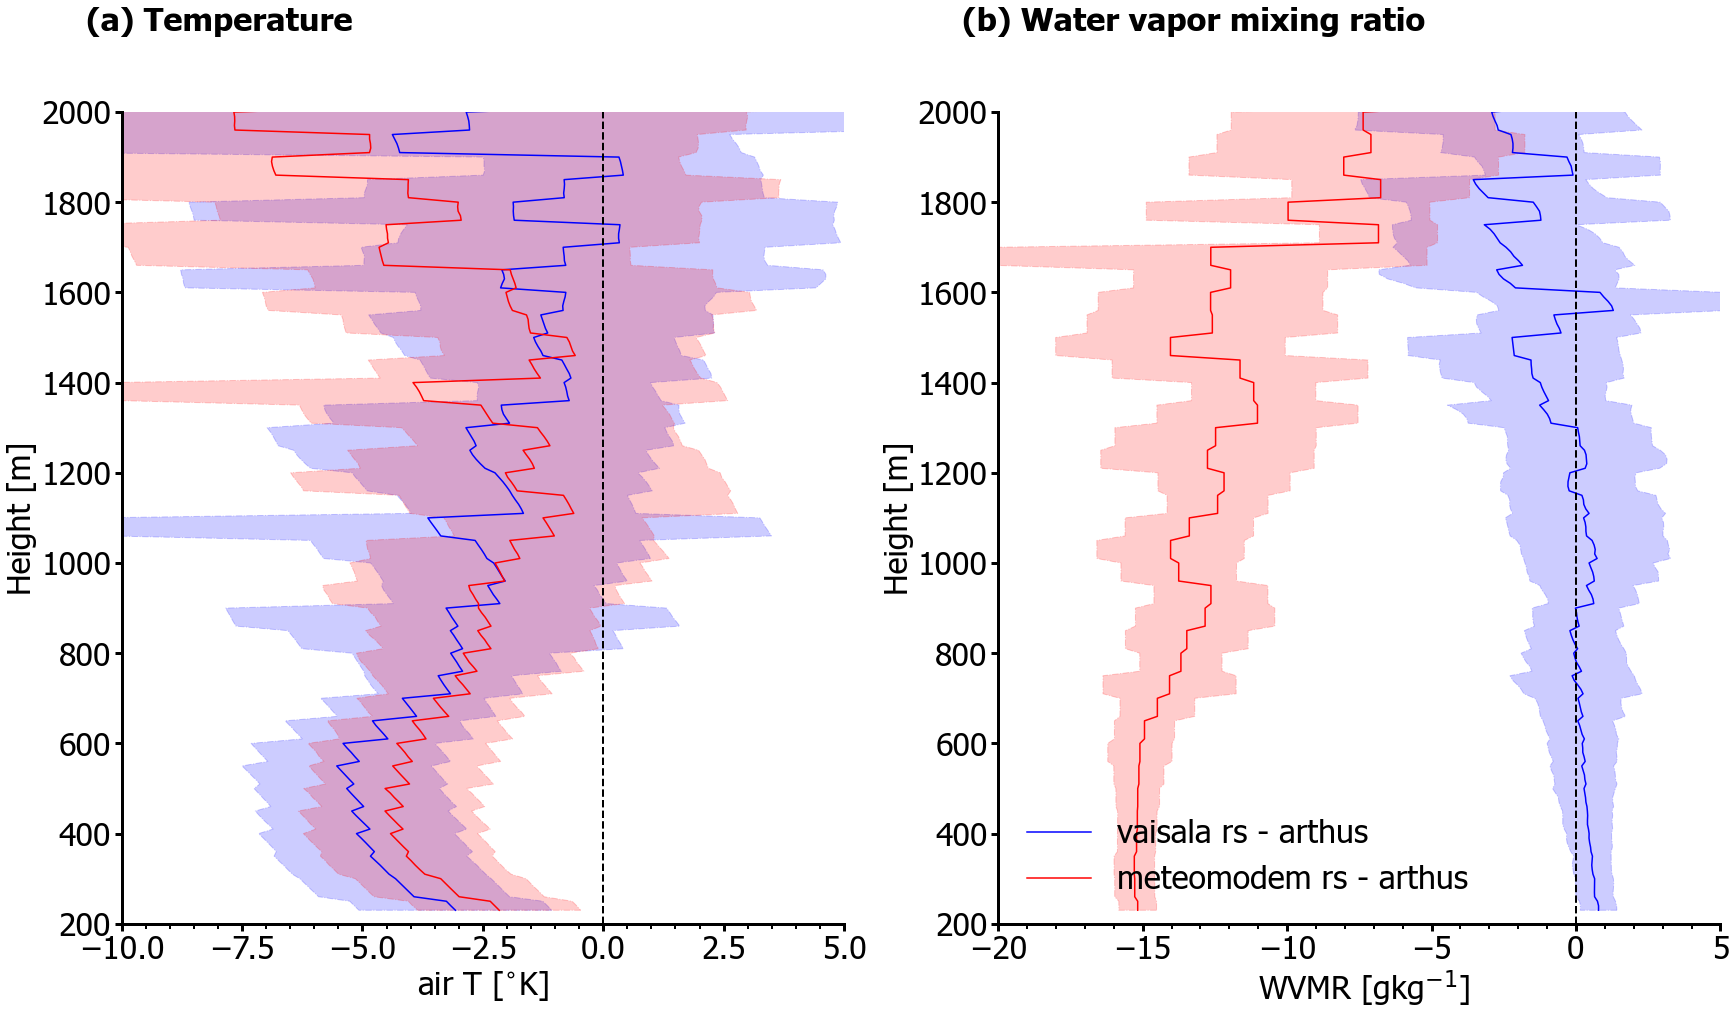

In [34]:


fig, axs = plt.subplots(1,2, figsize=(24,14), constrained_layout=True)

axs[0].plot(diff_T_mean_va, vaisala_rs.alt.values,color='blue', label='vaisala rs - arthus')
axs[0].fill_betweenx(vaisala_rs.alt.values, diff_T_mean_va-diff_T_std_va, diff_T_mean_va+diff_T_std_va, color='blue', alpha=0.2, linestyle='dashdot', antialiased=True)
axs[0].plot(diff_T_mean_mm, meteomodem_rs.alt.values, color='red', label='meteomodem rs - arthus')
axs[0].fill_betweenx(meteomodem_rs.alt.values, diff_T_mean_mm-diff_T_std_mm, diff_T_mean_mm+diff_T_std_mm, color='red', alpha=0.2, linestyle='dashdot', antialiased=True)
axs[0].set_xlim(-10., 5.)
axs[0].set_xlabel('air T [$^{\circ}$K]', fontsize=fontSizeX)
axs[0].axvline(0., ymin=0, ymax=1., linewidth=2, linestyle='--', color='black')

axs[1].plot(diff_WVMR_mean_va, vaisala_rs.alt.values, color='blue', label='vaisala rs - arthus')
axs[1].fill_betweenx(vaisala_rs.alt.values, diff_WVMR_mean_va-diff_WVMR_std_va, diff_WVMR_mean_va+diff_WVMR_std_va, color='blue', alpha=0.2, linestyle='dashdot', antialiased=True)
axs[1].plot(diff_WVMR_mean_mm, meteomodem_rs.alt.values, color='red', label='meteomodem rs - arthus')
axs[1].fill_betweenx(meteomodem_rs.alt.values, diff_WVMR_mean_mm-diff_WVMR_std_mm, diff_WVMR_mean_mm+diff_WVMR_std_mm, color='red', alpha=0.2, linestyle='dashdot', antialiased=True)
axs[1].set_xlim(-20., 5.)
axs[1].set_xlabel(' WVMR [gkg$^{-1}$]', fontsize=fontSizeX)
axs[1].legend(frameon=False)
axs[1].axvline(0., ymin=0, ymax=1., linewidth=2, linestyle='--', color='black')

for ax, l in zip(axs[:].flatten(), ['(a) Temperature ',  '(b) Water vapor mixing ratio ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=32)
    ax.set_ylabel('Height [m]', fontsize=fontSizeX)
    ax.set_ylim(200.,2000.)
fig.savefig(path_out_plots+'stats_T_wvmr.png', format='png')

